In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
def distort(m, p=0.1):
    """ Flip the sign of a randomly chosen percentage `p` of the input matrix """
    N = int(len(m) * p) if p < 1.0 else len(m)
    idx = list(np.random.permutation(len(m)))
    distorted = np.array(m)
    distorted[idx[:N]] *= -1
    return distorted


In [39]:
class Hopfield():
    def __init__(self, neurons, bias = 0.5, eps = 1e-6):
        self.neurons = neurons
        self.eps = eps
        self.bias = bias
        self.x = np.zeros(neurons)
        
    def setup(self):
        self.W = np.sum([p @ p.T for p in self.patterns], axis=0) / self.neurons
        self.W[np.diag_indices(self.neurons)] = 0
        assert np.all(self.W == self.W.T), "Weight matrix is not symmetric"
        
    def store(self, patterns):
        self.patterns = patterns.copy()
        self.setup()
        
    def overlap(self, i):
        return np.dot(self.patterns[i].squeeze(), self.x.squeeze()) / self.neurons
    
    def energy(self, index = None, reduce = True):
        if index:
            # Optimized energy update:
            # The cost of calculating the outer product xx^T is quadratic in the
            # number of neurons. Since this has to be computed at every time step for each neuron,
            # we incrementally update only the elements that actually change in the energy matrix.
            # At every update step, only x_i is changed, so it is sufficient to only recompute
            # the i-th row and column of the resulting energy matrix, leaving the rest untouched.
            row = -0.5 * (self.W[index, :] * self.x[index] * self.x.squeeze())
            col = -0.5 * (self.W[:, index] * self.x[index] * self.x.squeeze())
            self._energy_temp[index, :] = row
            self._energy_temp[:, index] = col
            energy_matrix = self._energy_temp
        else:
            # Full matrix calculation
            energy_matrix = -0.5 * (self.W * np.outer(self.x, self.x))
        
        if reduce:
            return energy_matrix.sum()
        return energy_matrix

    def update(self, i):
        self.x[i] = np.sign(self.W[i, :] @ self.x.squeeze() + self.bias)
        
    def update_all(self):
        old = self.retrieve()
        for i in np.random.permutation(self.neurons):
            self.update(i)
            self.overlap_history.append([self.overlap(j) for j in range(len(self.patterns))])
            self.energy_history.append(self.energy(index=i))
        
        return np.linalg.norm(old - self.retrieve()) > self.eps
        
        
    def probe(self, x):
        self.x = x.copy()
        self._energy_temp = self.energy(reduce=False)
        self.overlap_history = []
        self.energy_history = []
        
    def retrieve(self):
        return self.x.copy()

In [40]:
p0 = pd.read_csv('p0.csv', header=None).values
p1 = pd.read_csv('p1.csv', header=None).values
p2 = pd.read_csv('p2.csv', header=None).values

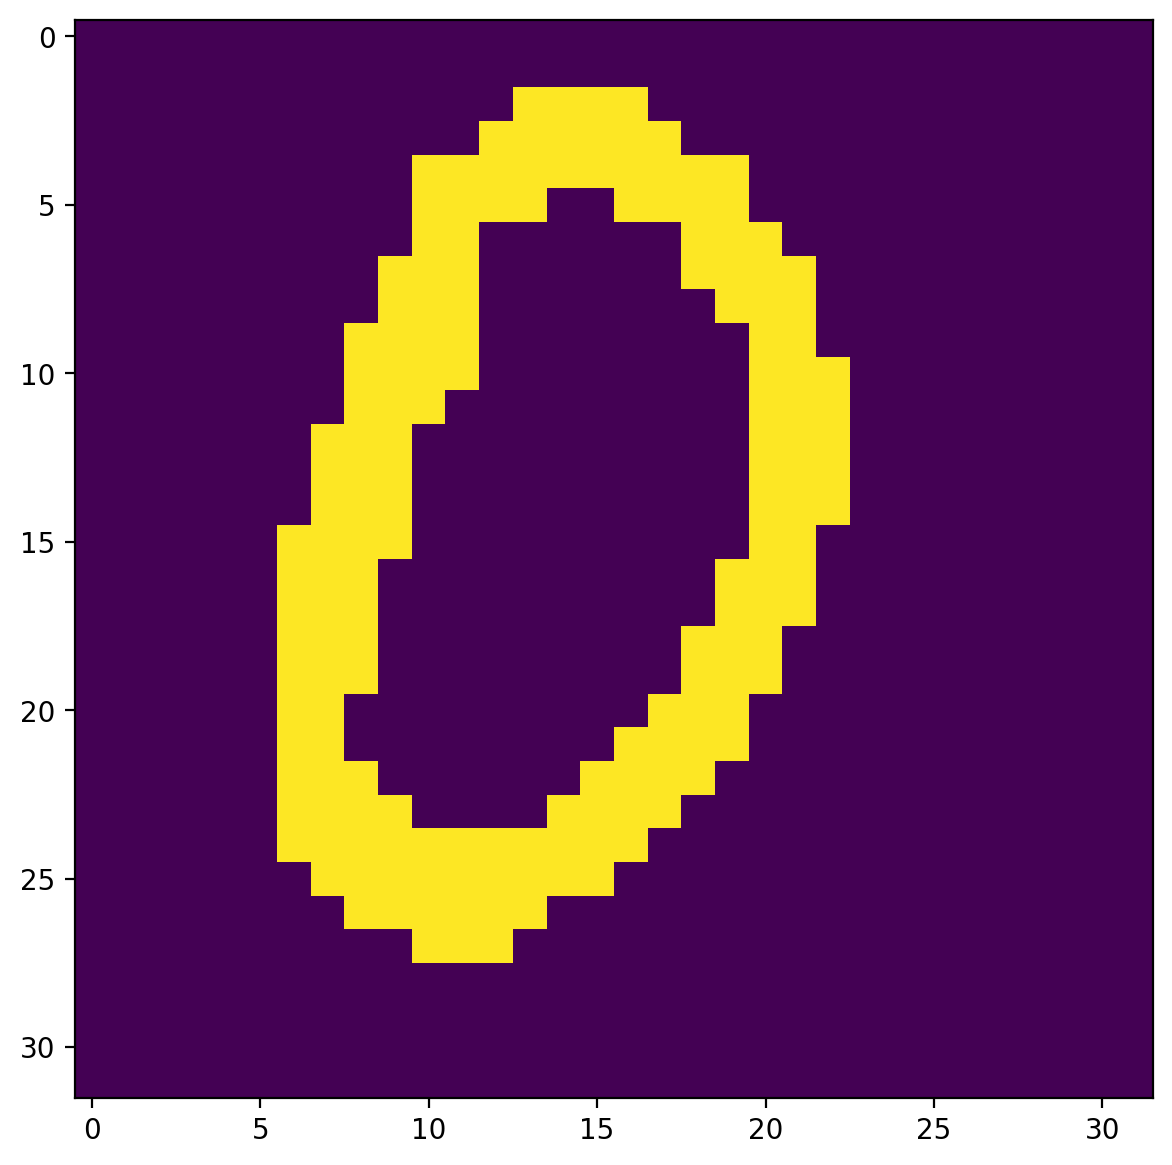

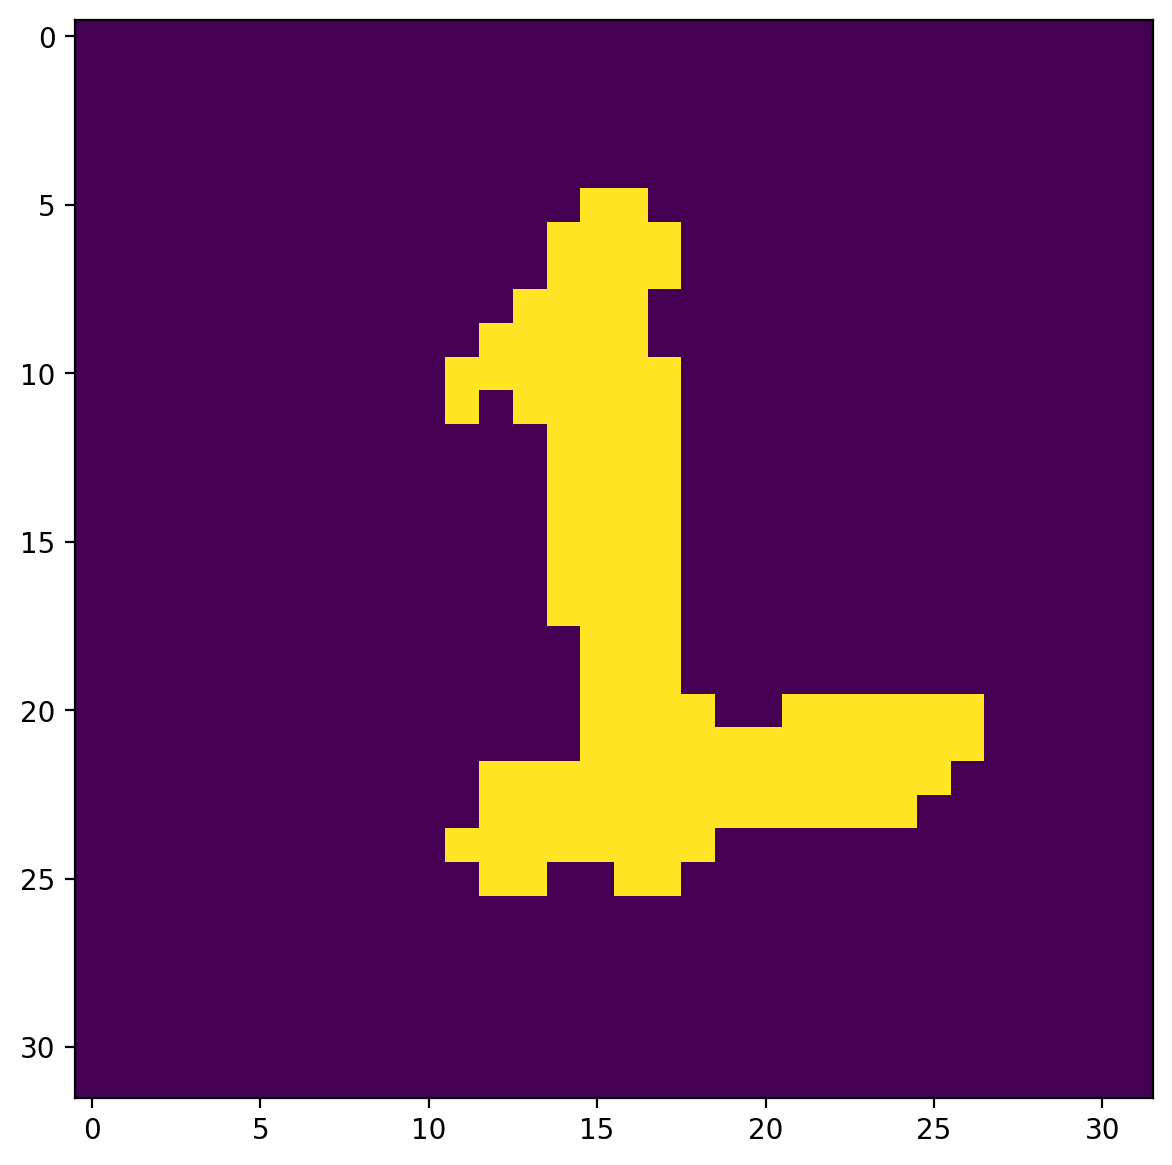

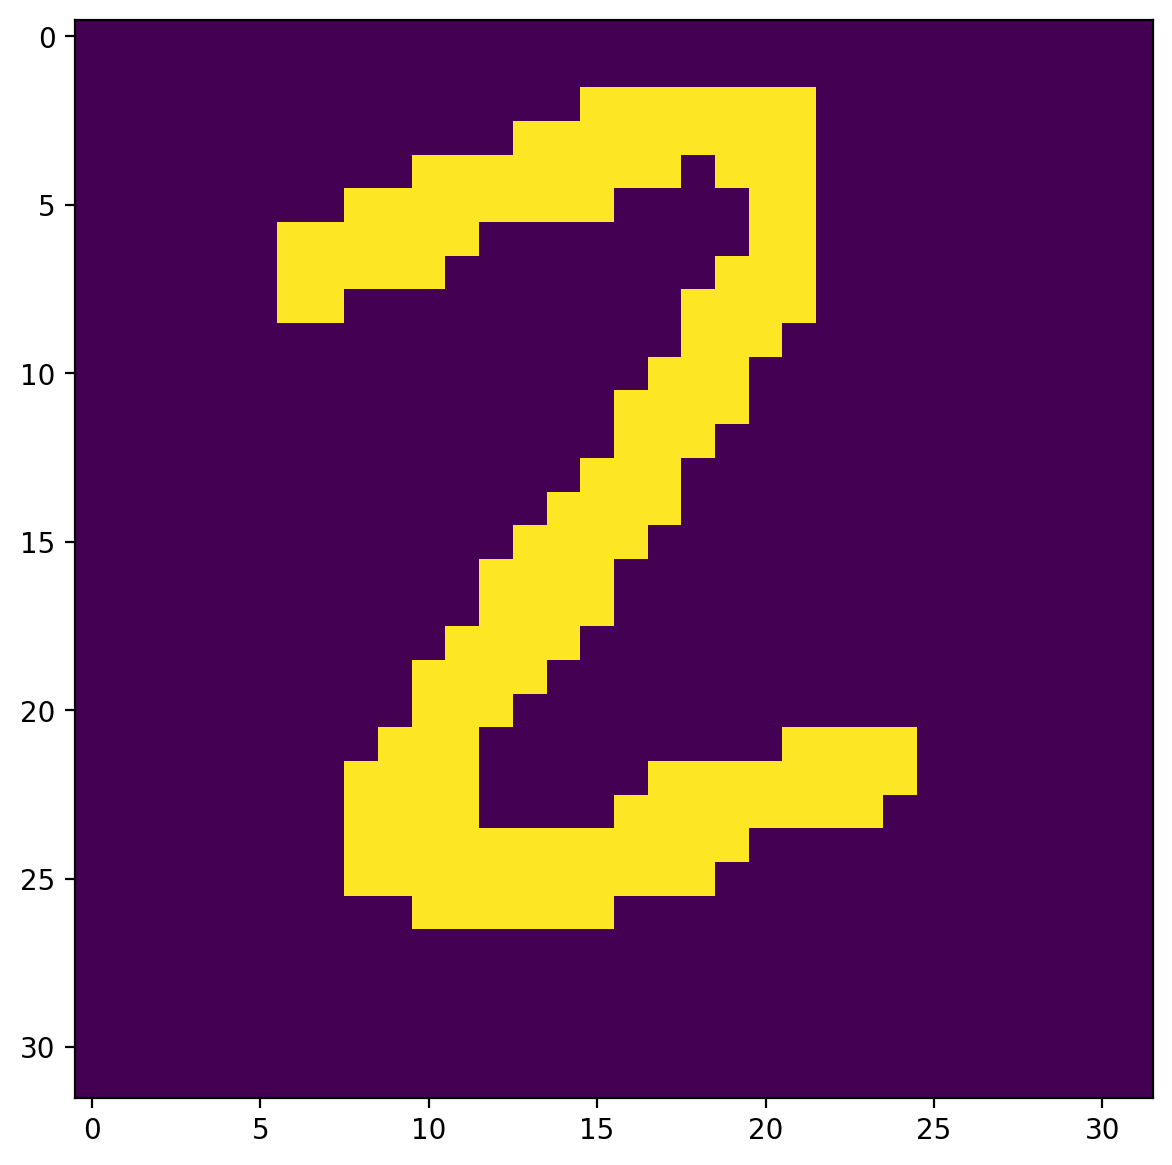

In [41]:
def reshape_plot(p, title=None, filename=None):
    dim = int(np.sqrt(len(p)))
    plt.imshow(p.reshape(dim, dim).T)
    if title:
        plt.title(title)
        
    if filename:
        plt.savefig(filename)
    plt.show()
    
reshape_plot(p0)
reshape_plot(p1)
reshape_plot(p2)

In [42]:
def plot_overlaps(hopfield, labels, filename):
    overlaps = np.array(hopfield.overlap_history)
    plt.plot(range(len(overlaps)), overlaps, label=labels)
    plt.title('Overlap(t)')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot_energy(hopfield, filename):
    energy = np.array(hopfield.energy_history)
    plt.plot(range(len(energy)), energy, label='energy')
    plt.title('Energy(t)')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot_reconstruction(hopfield, filename):
    reconstructed = hopfield.retrieve()
    errors = [np.linalg.norm(reconstructed - p) for p in hopfield.patterns]
    optimal = np.argmin(errors)

    reshape_plot(reconstructed, f'Reconstruction error: {errors[optimal]}', filename)
    reshape_plot(hopfield.patterns[optimal])

Retrieving pattern 0 with p = 0.05


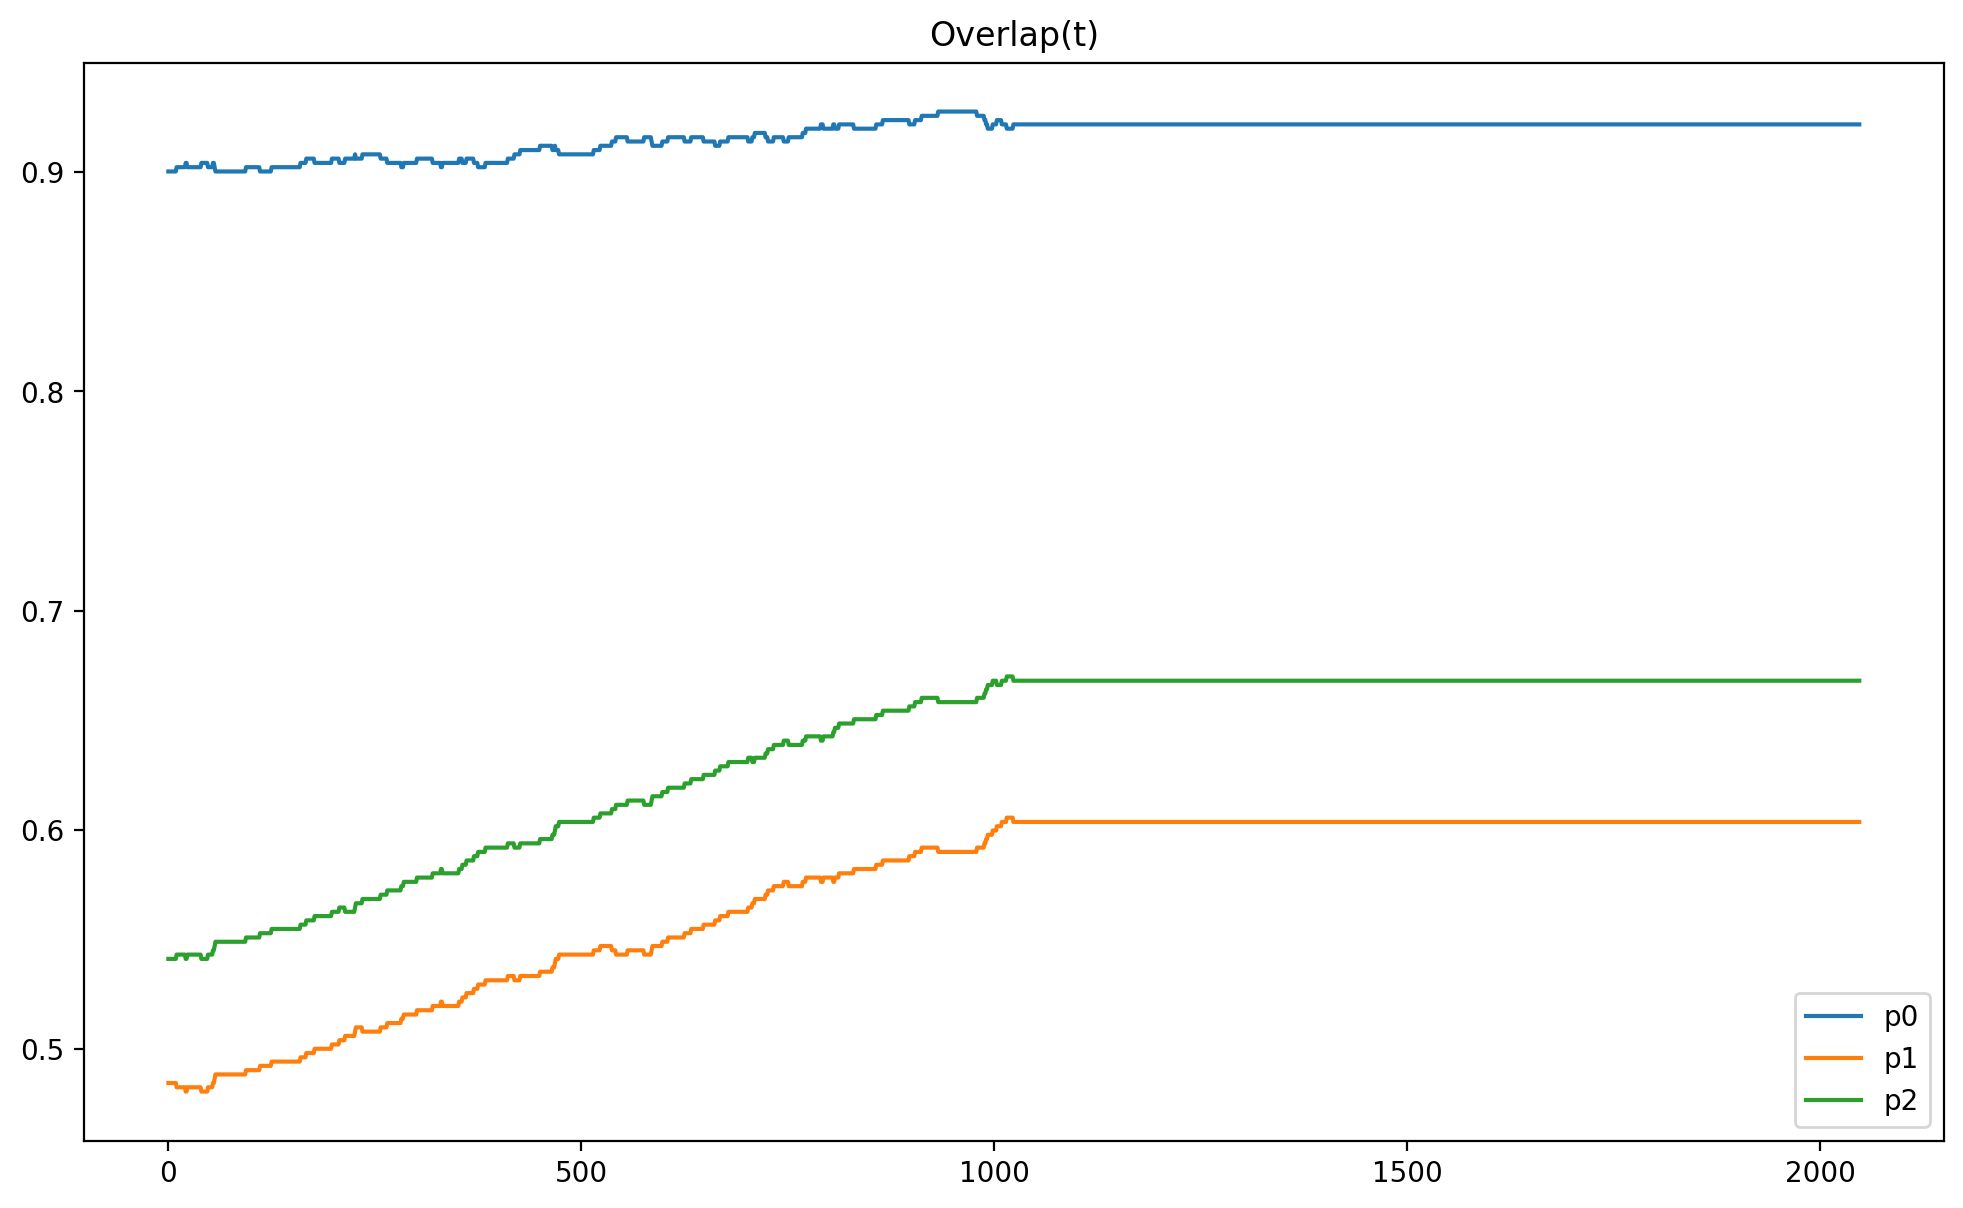

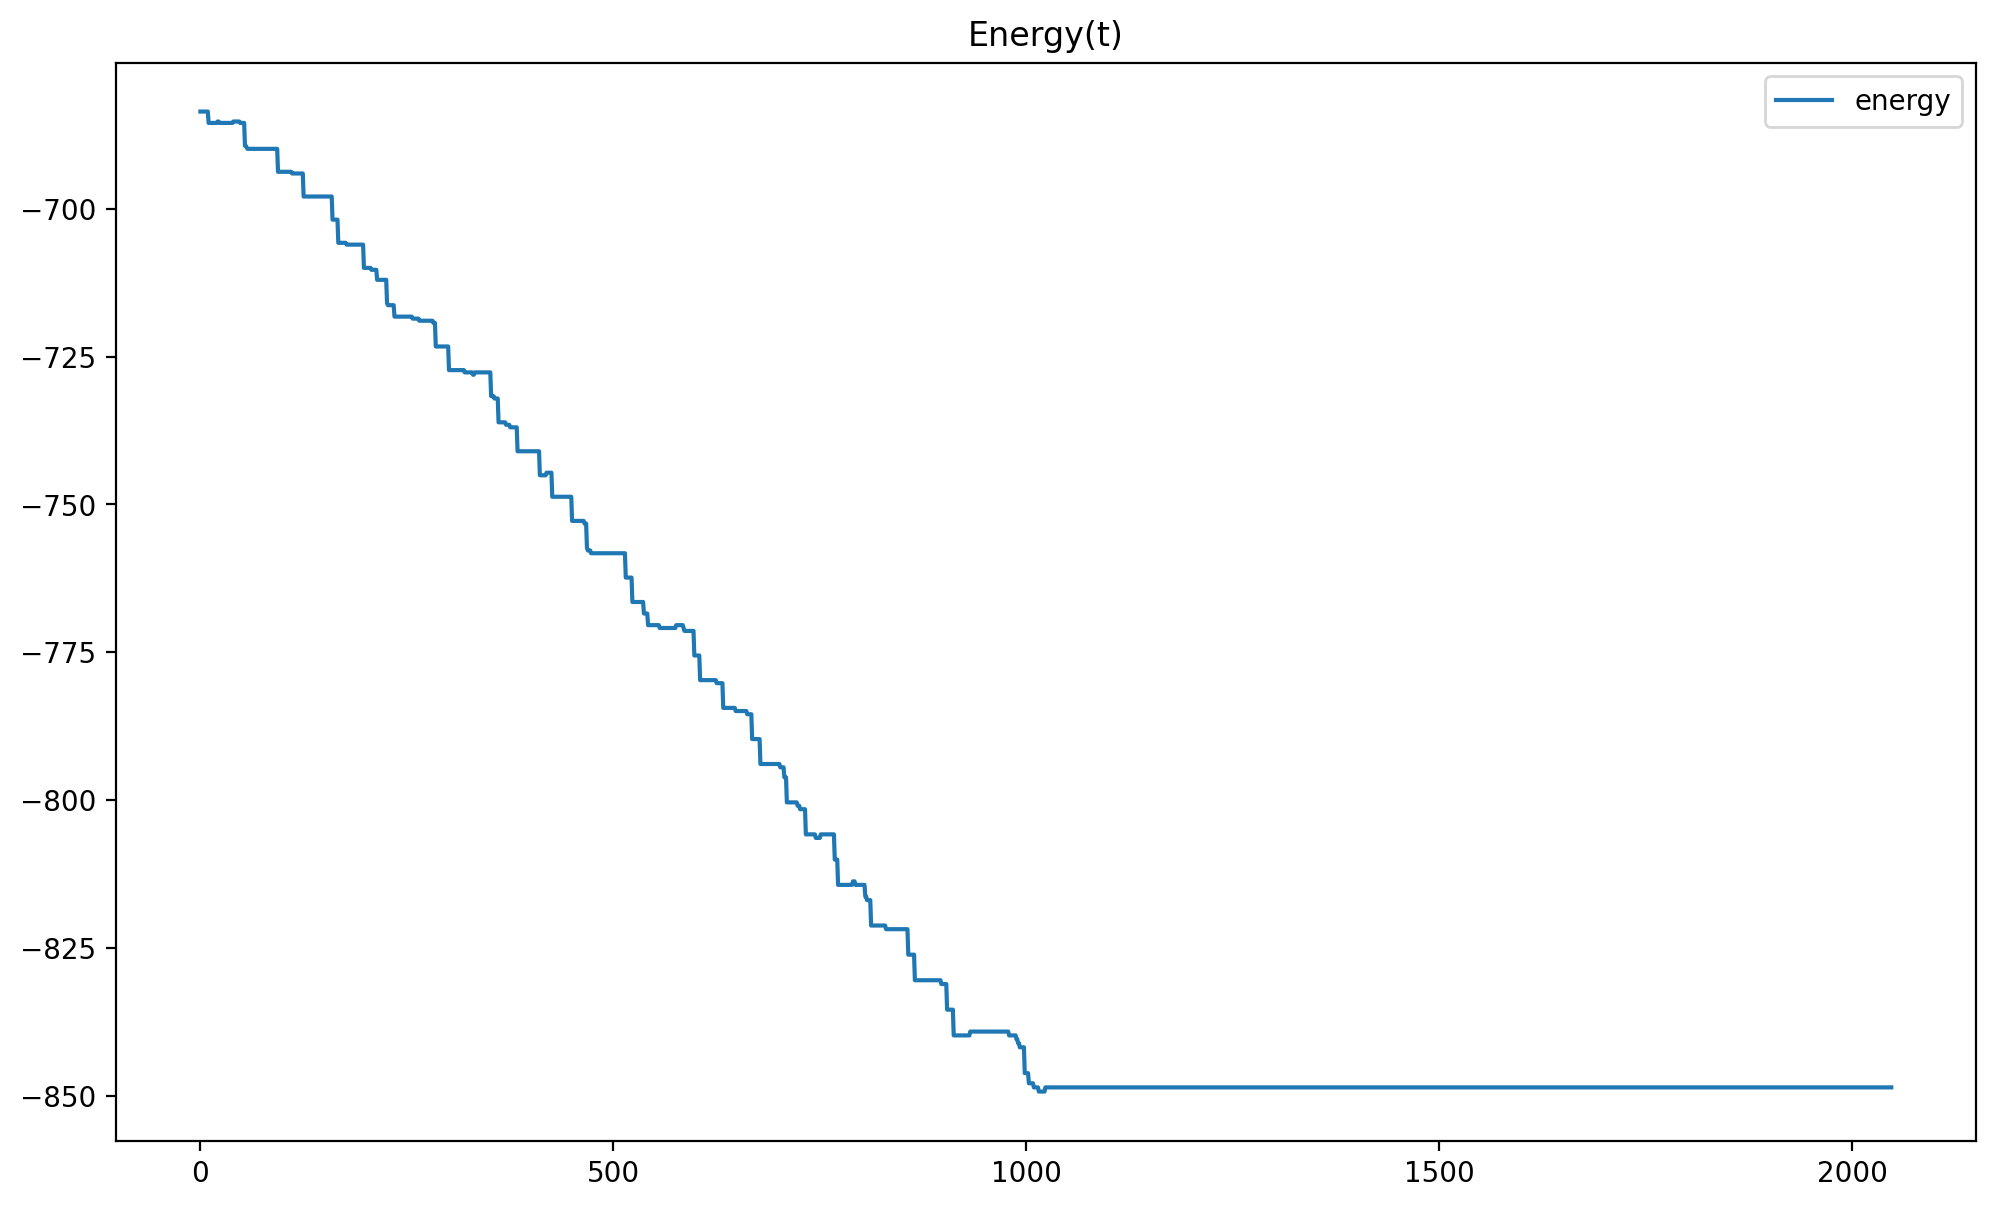

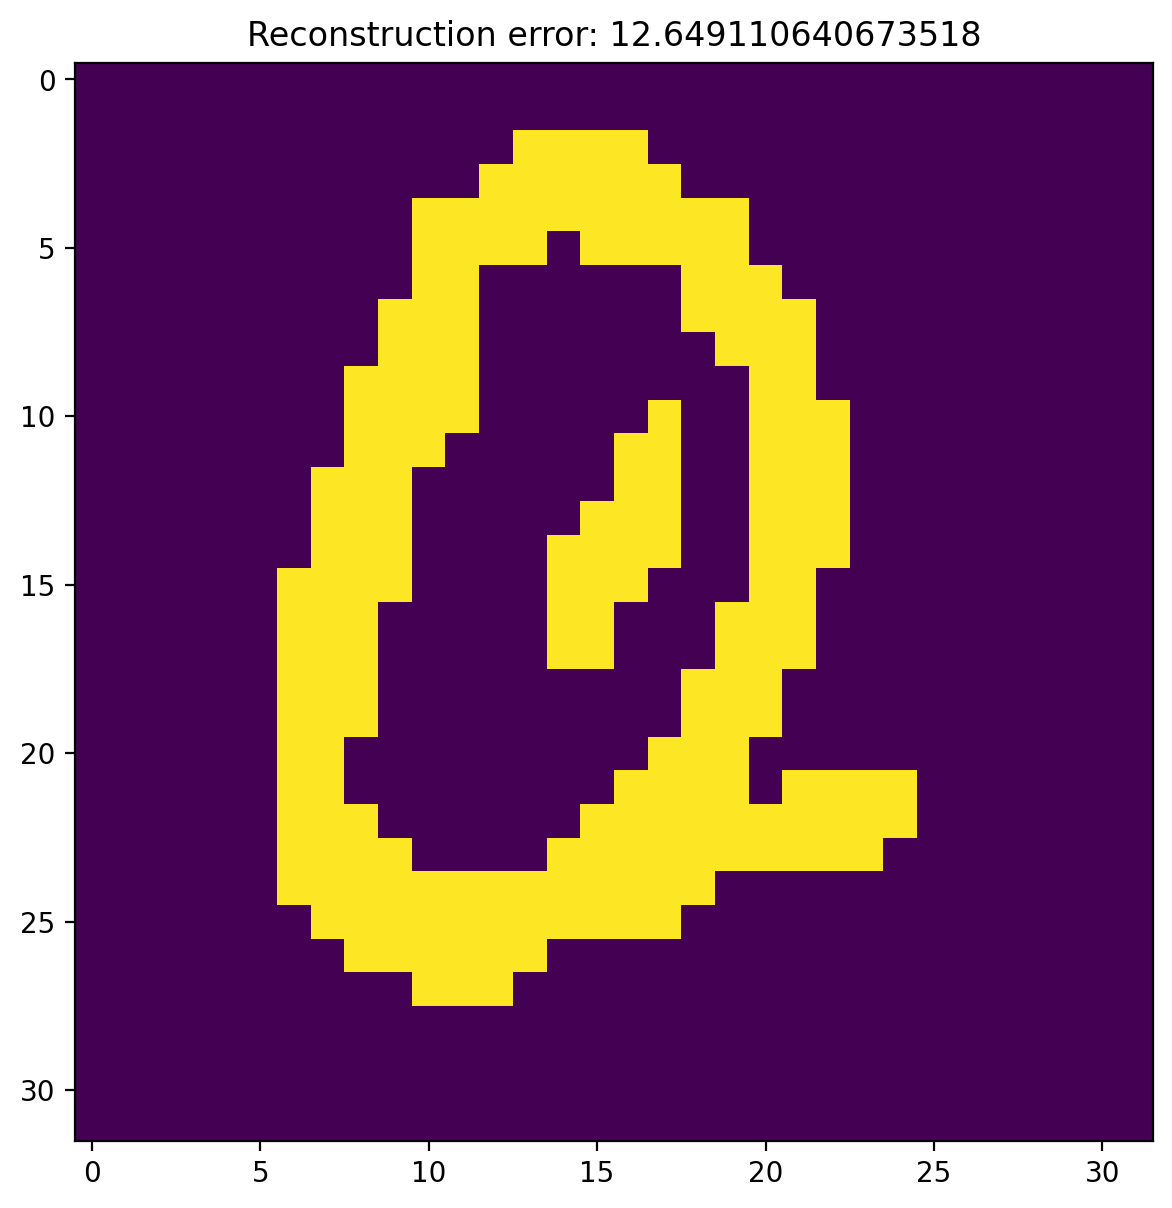

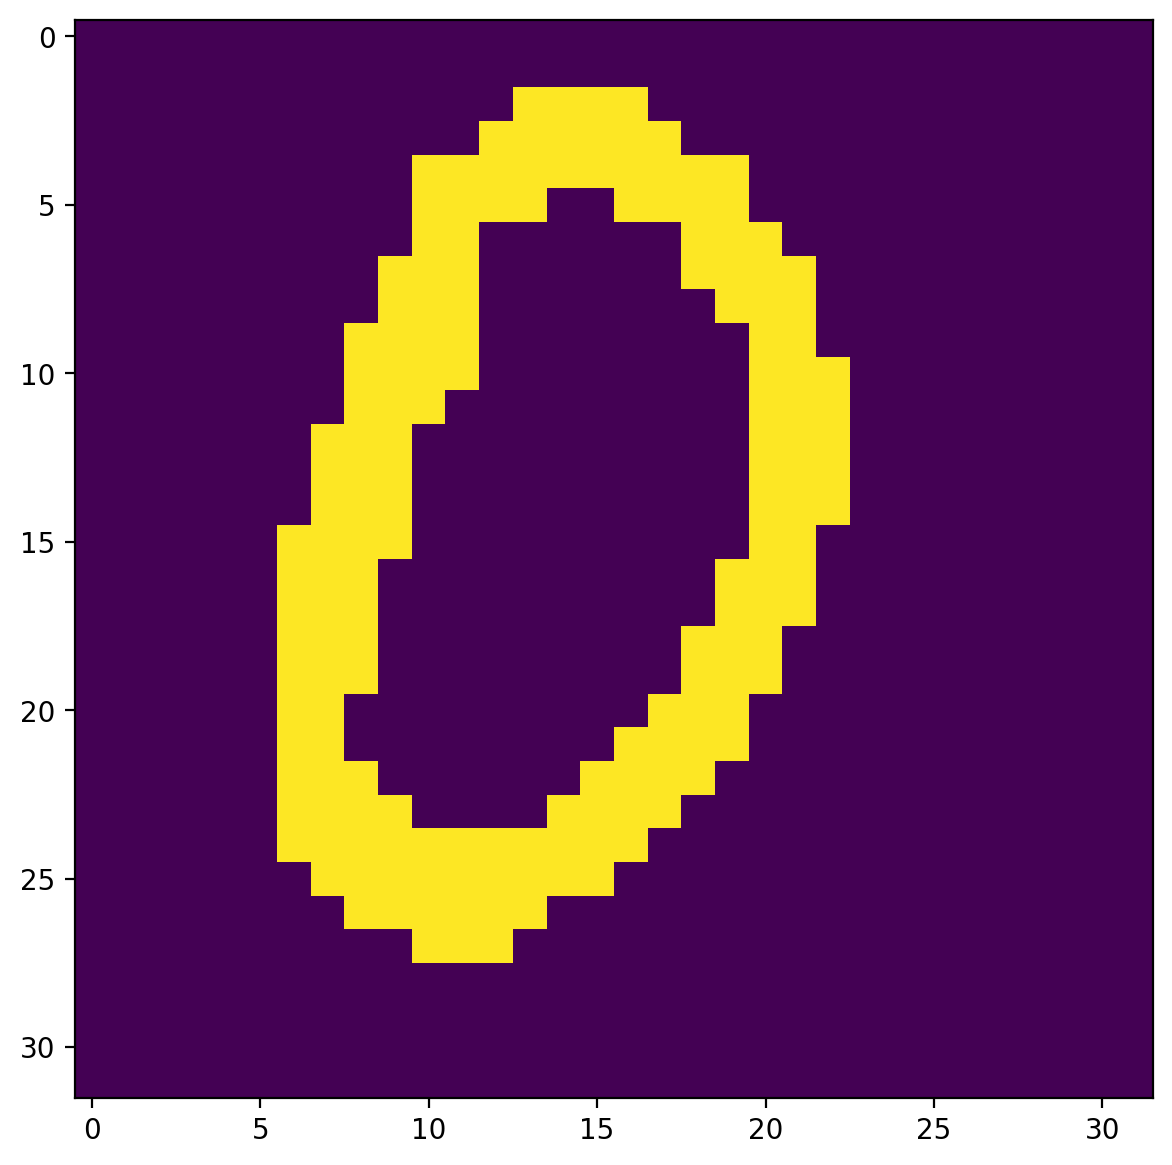

Retrieving pattern 0 with p = 0.1


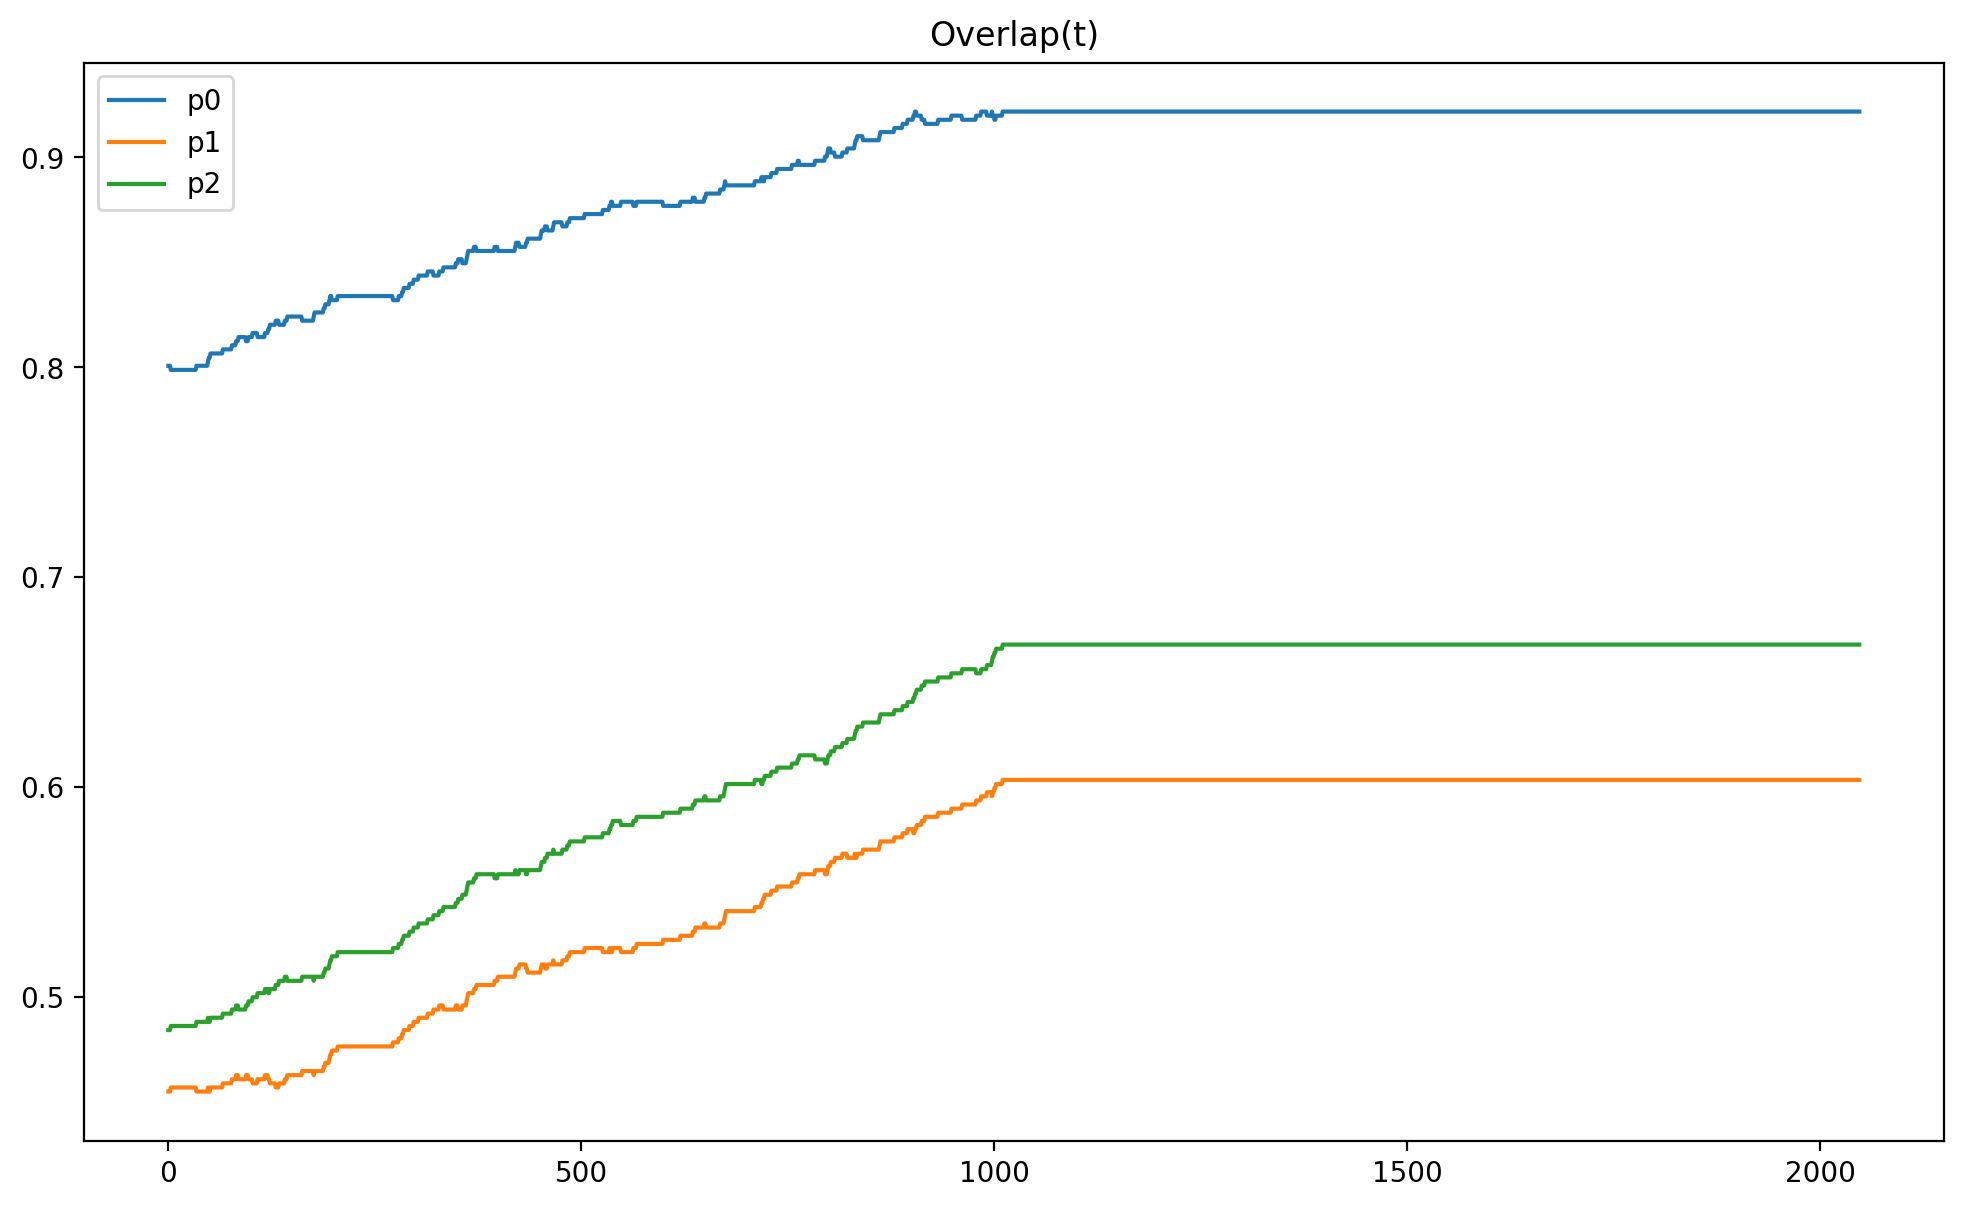

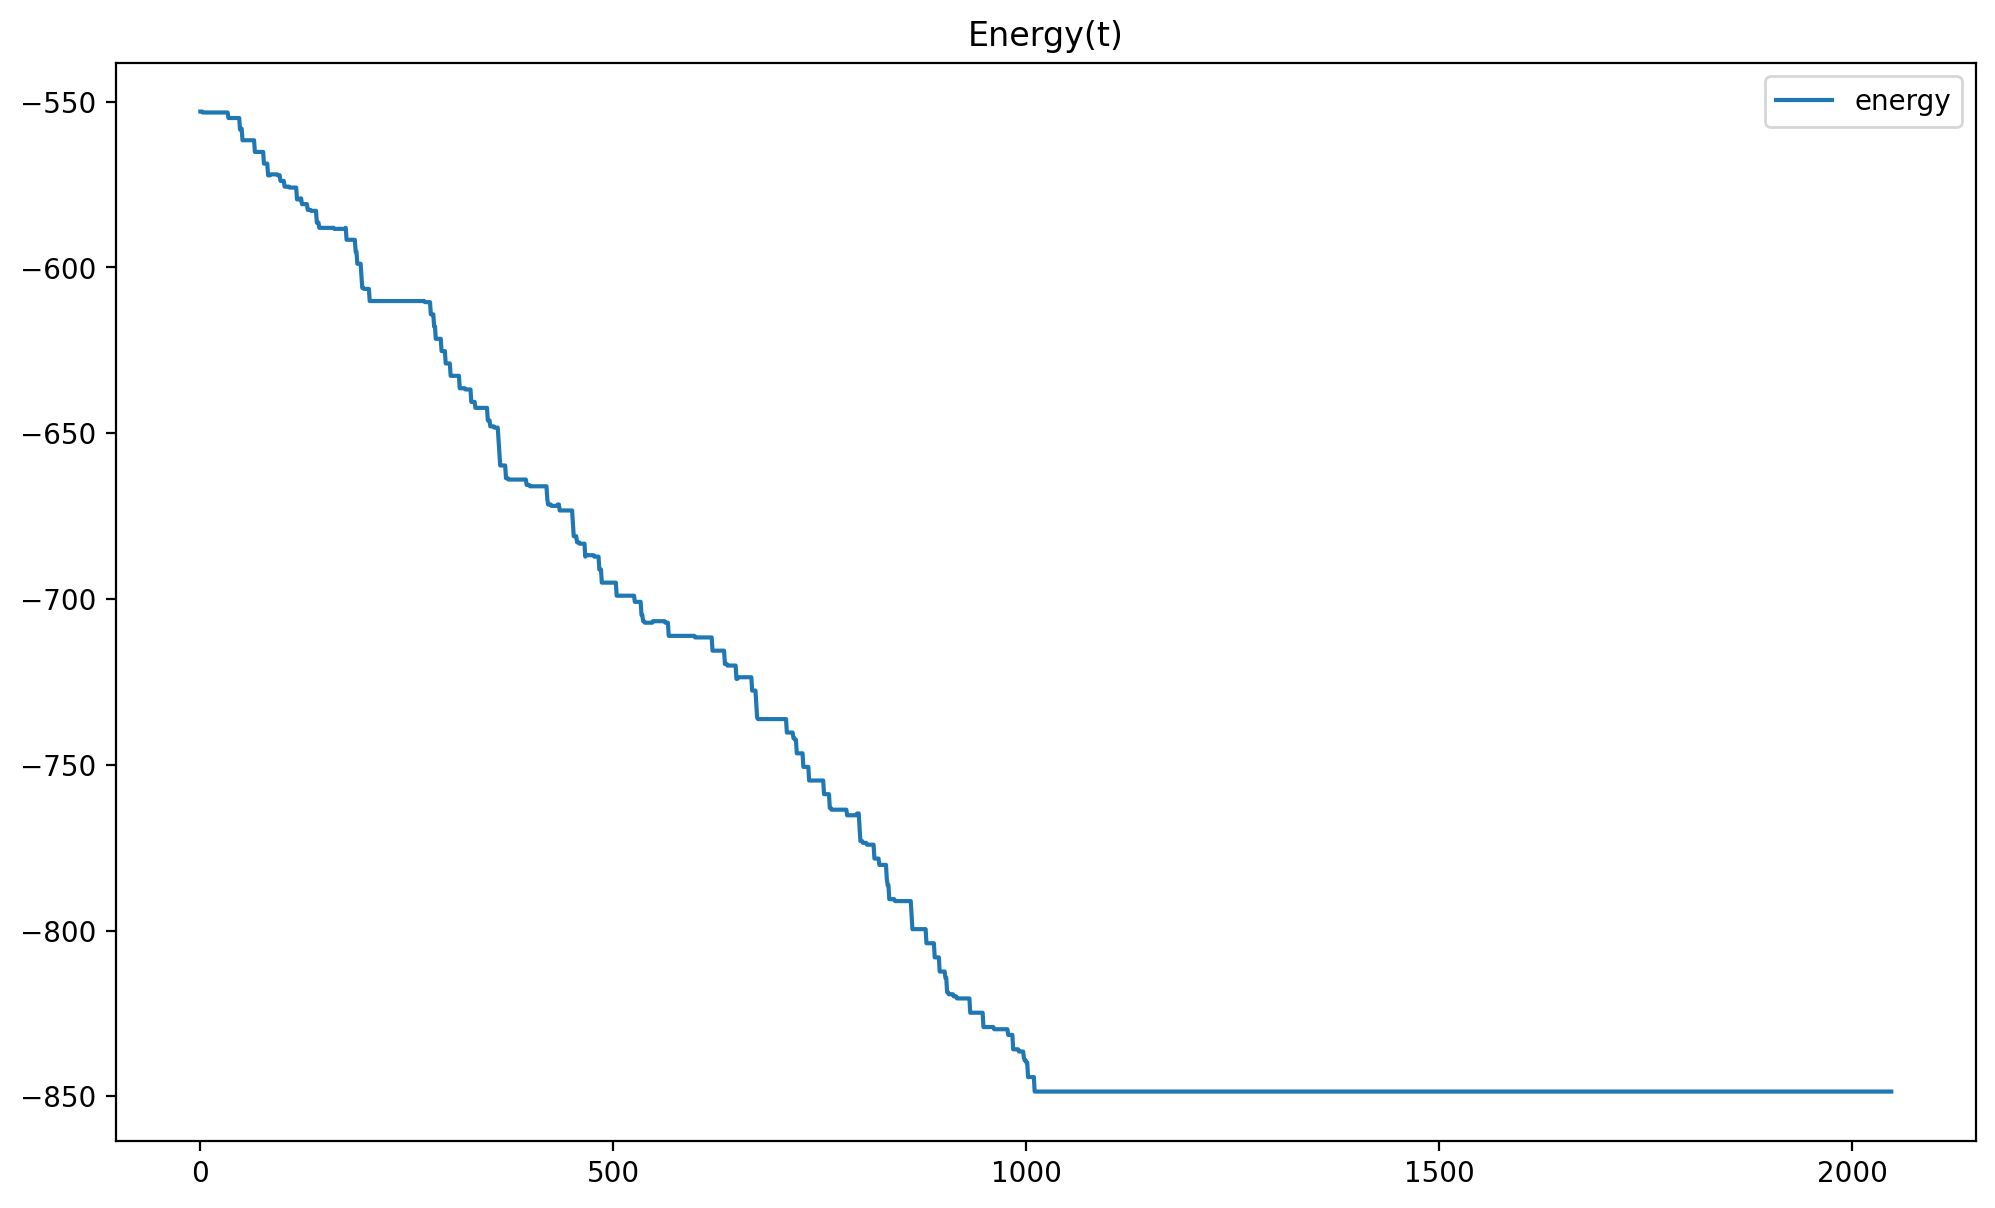

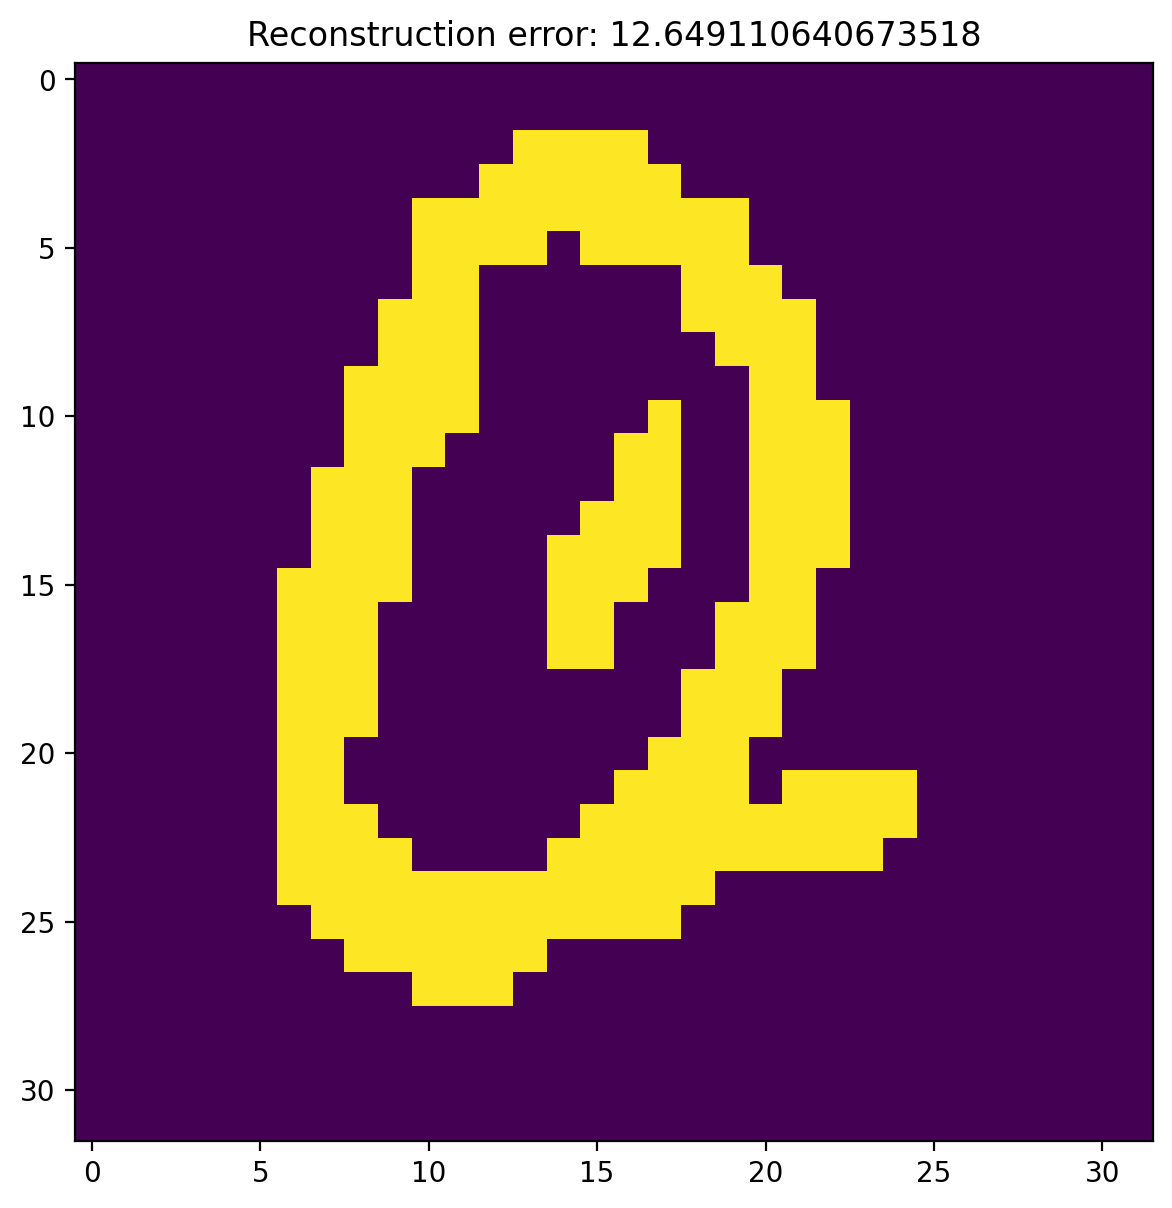

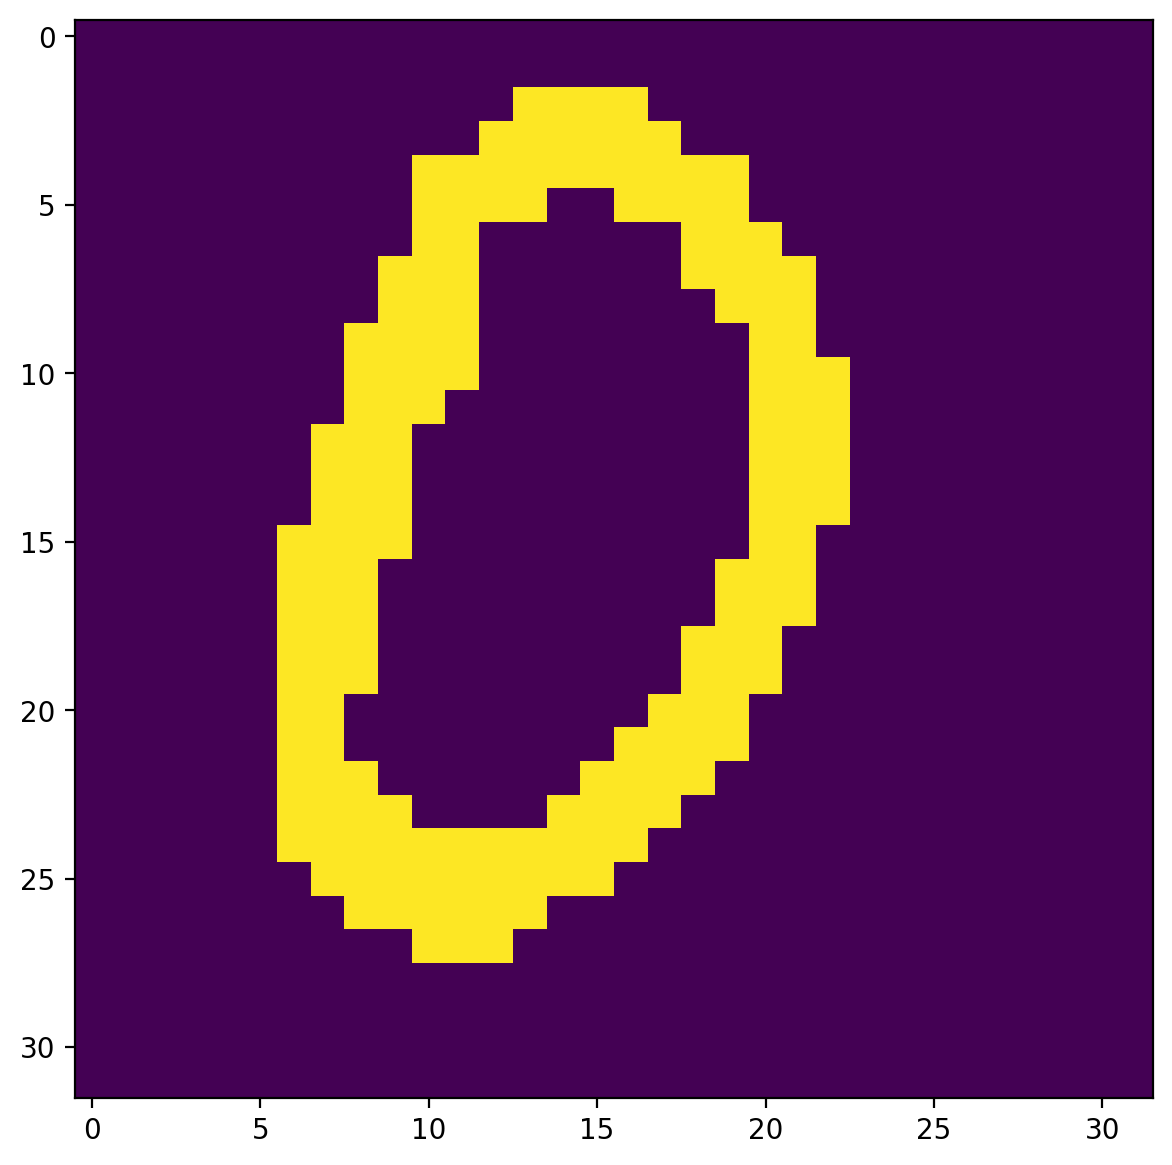

Retrieving pattern 0 with p = 0.25


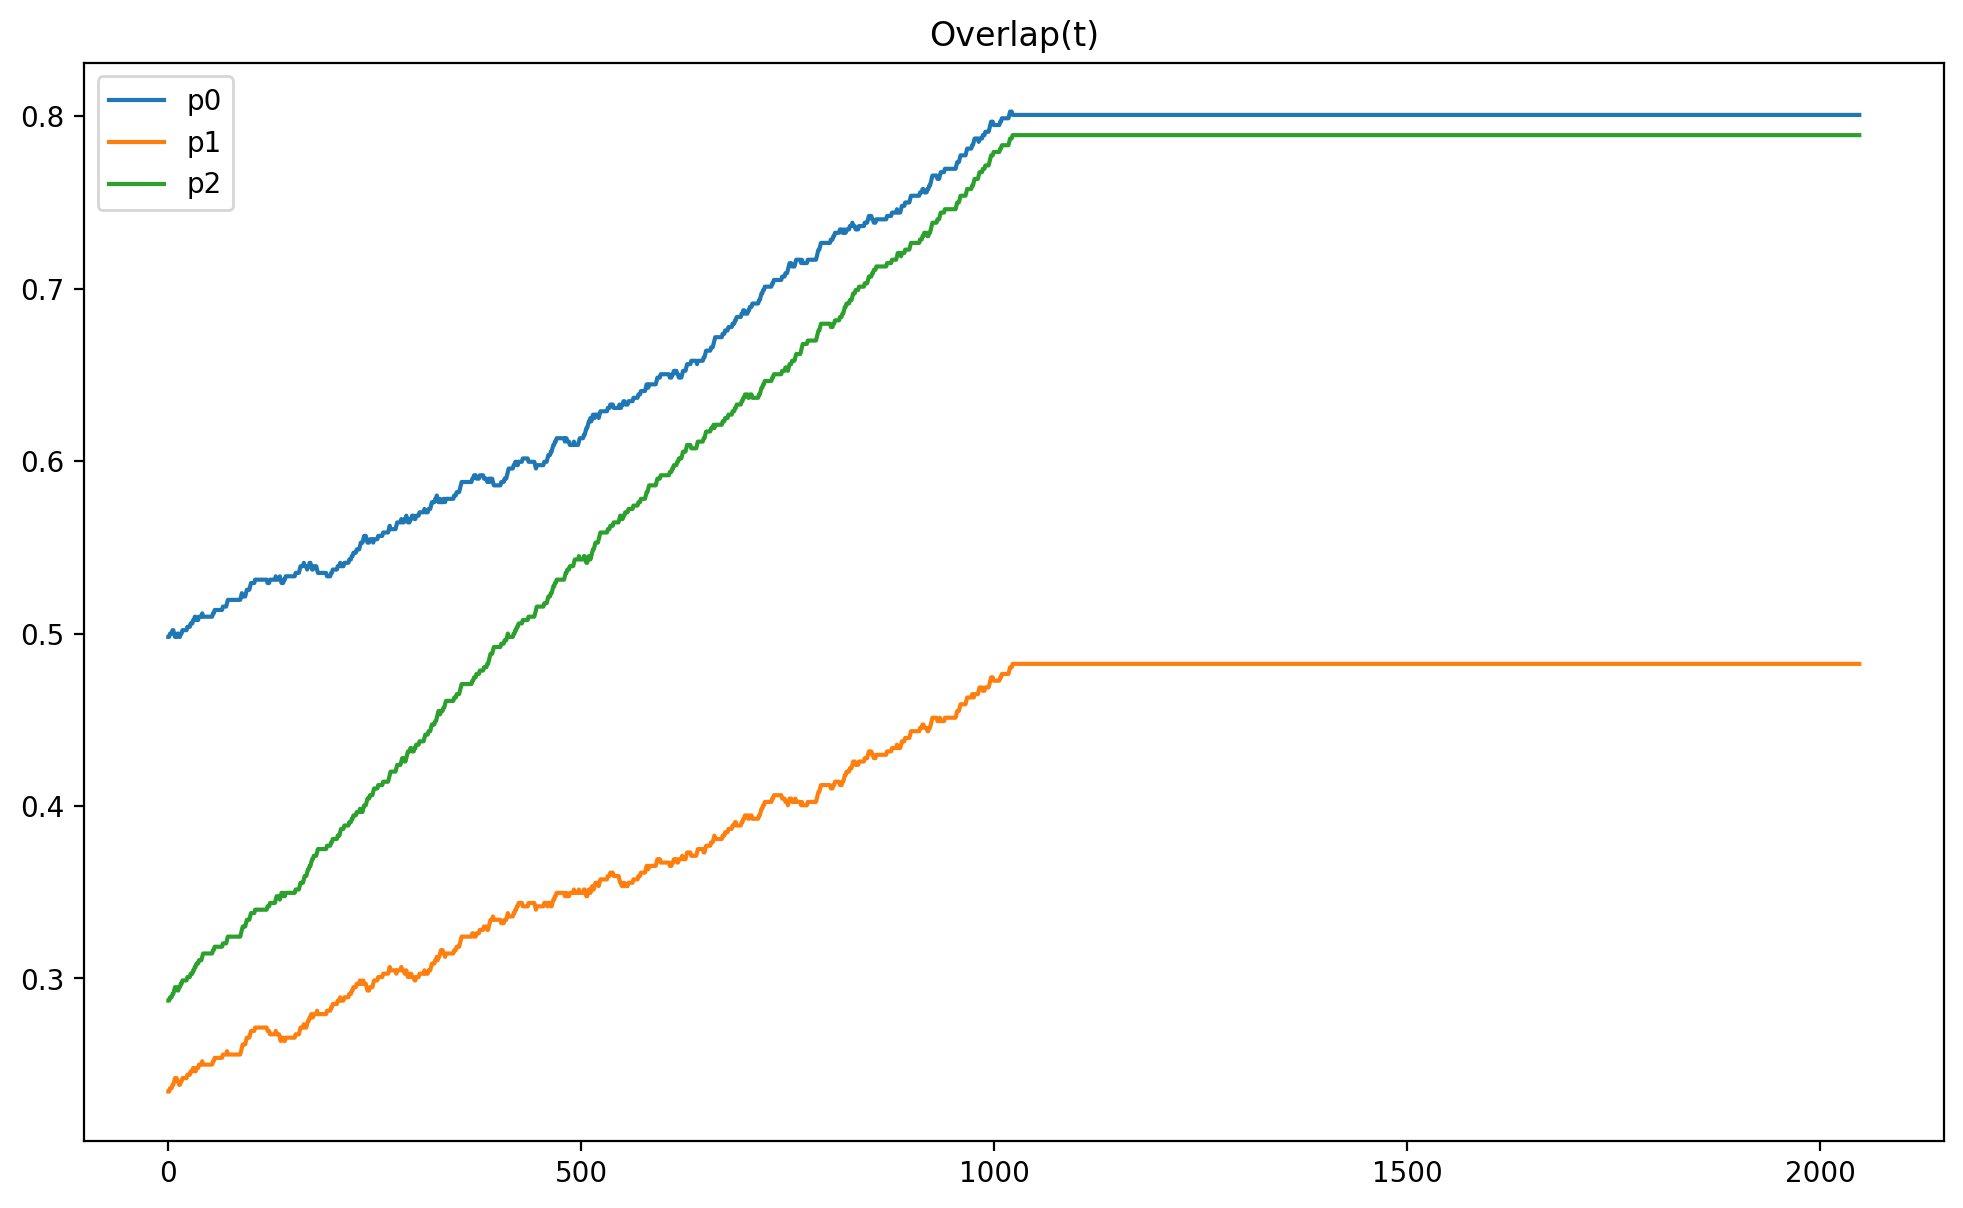

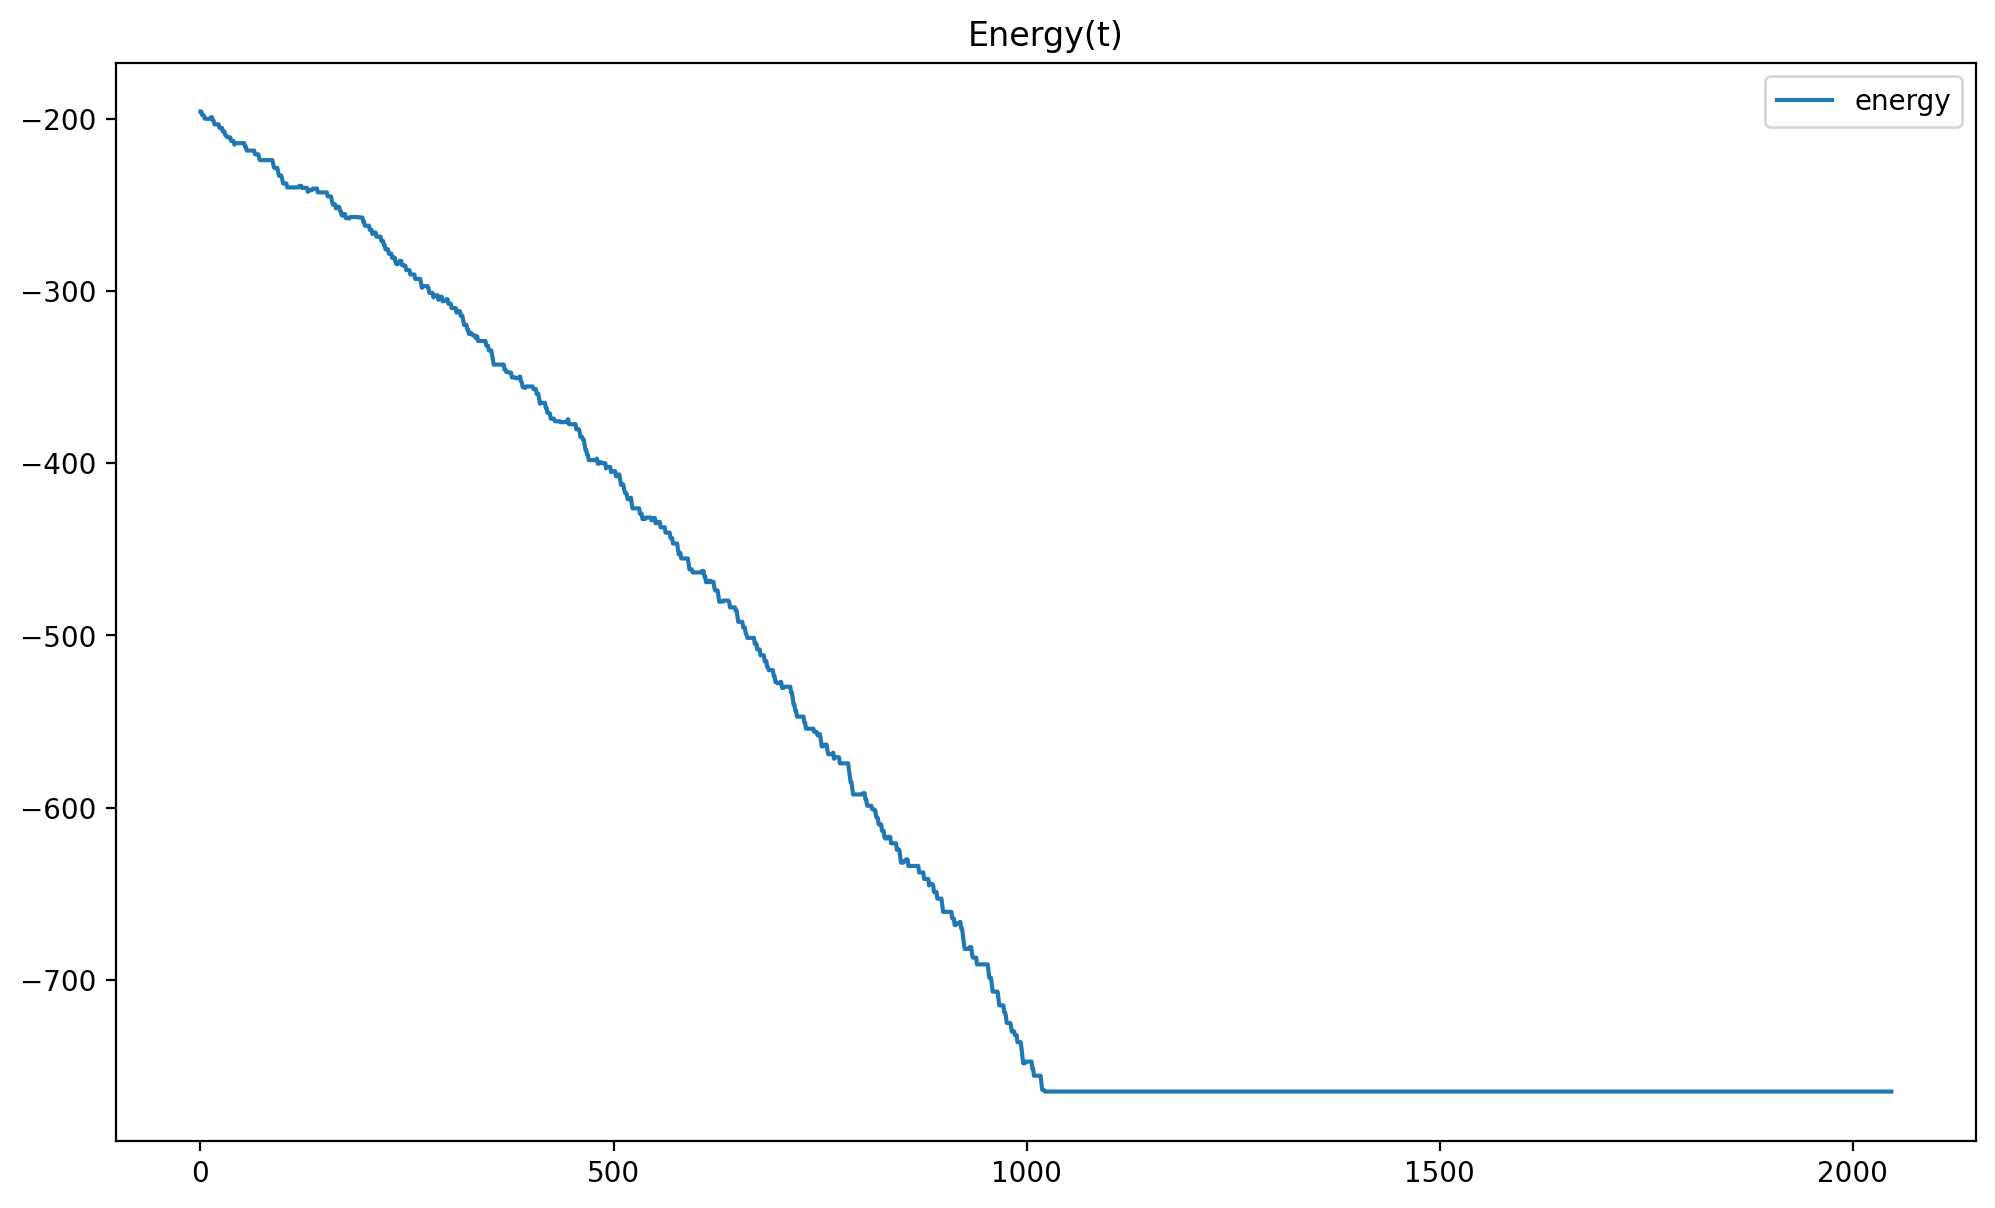

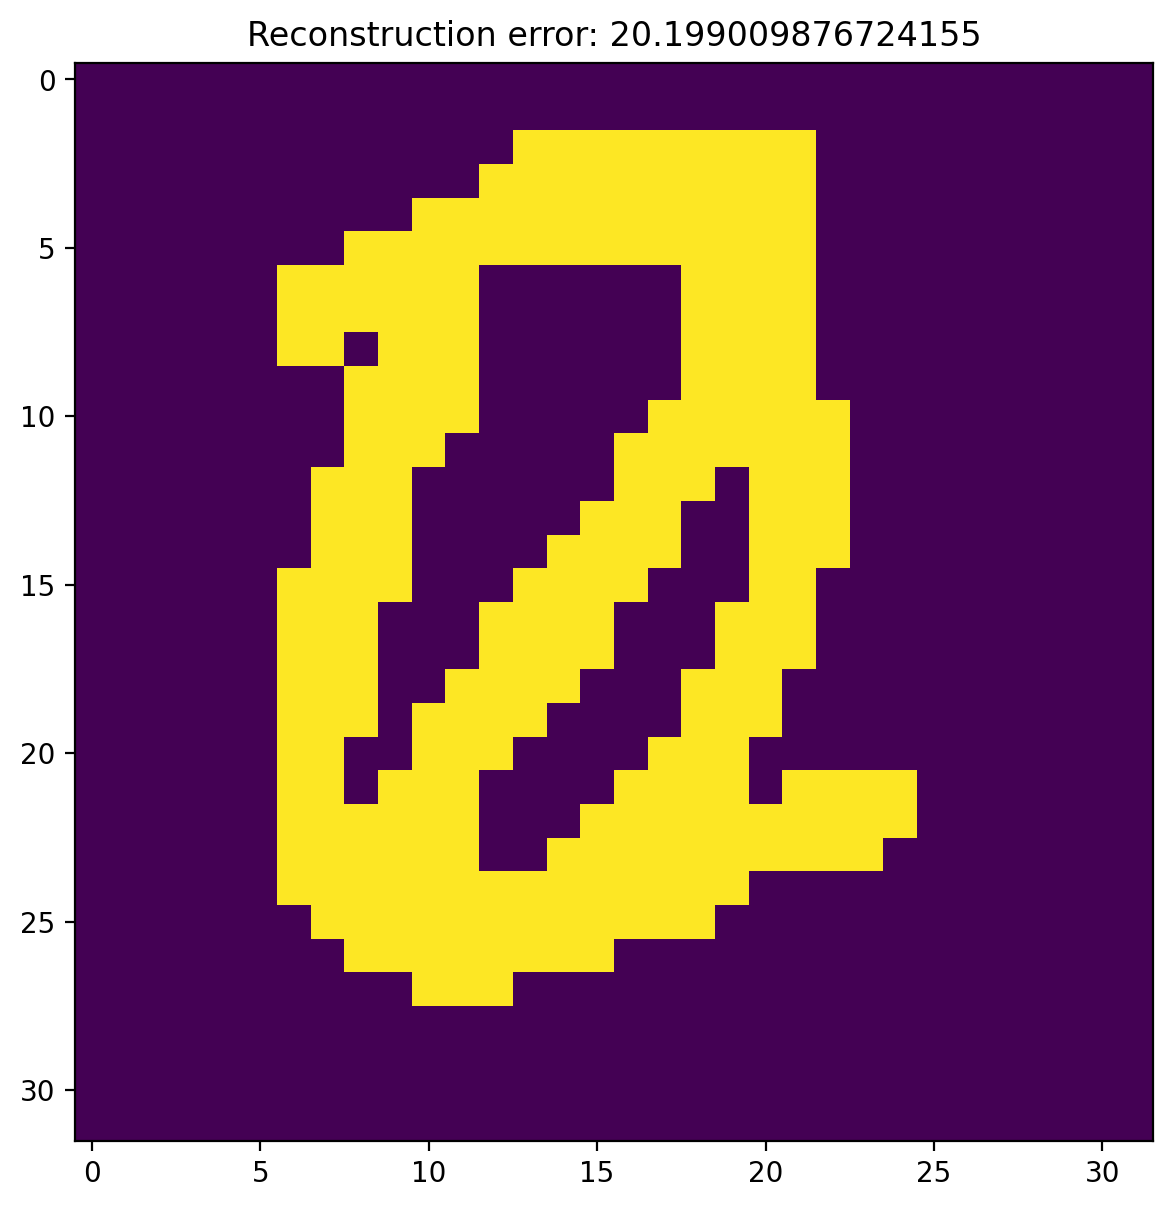

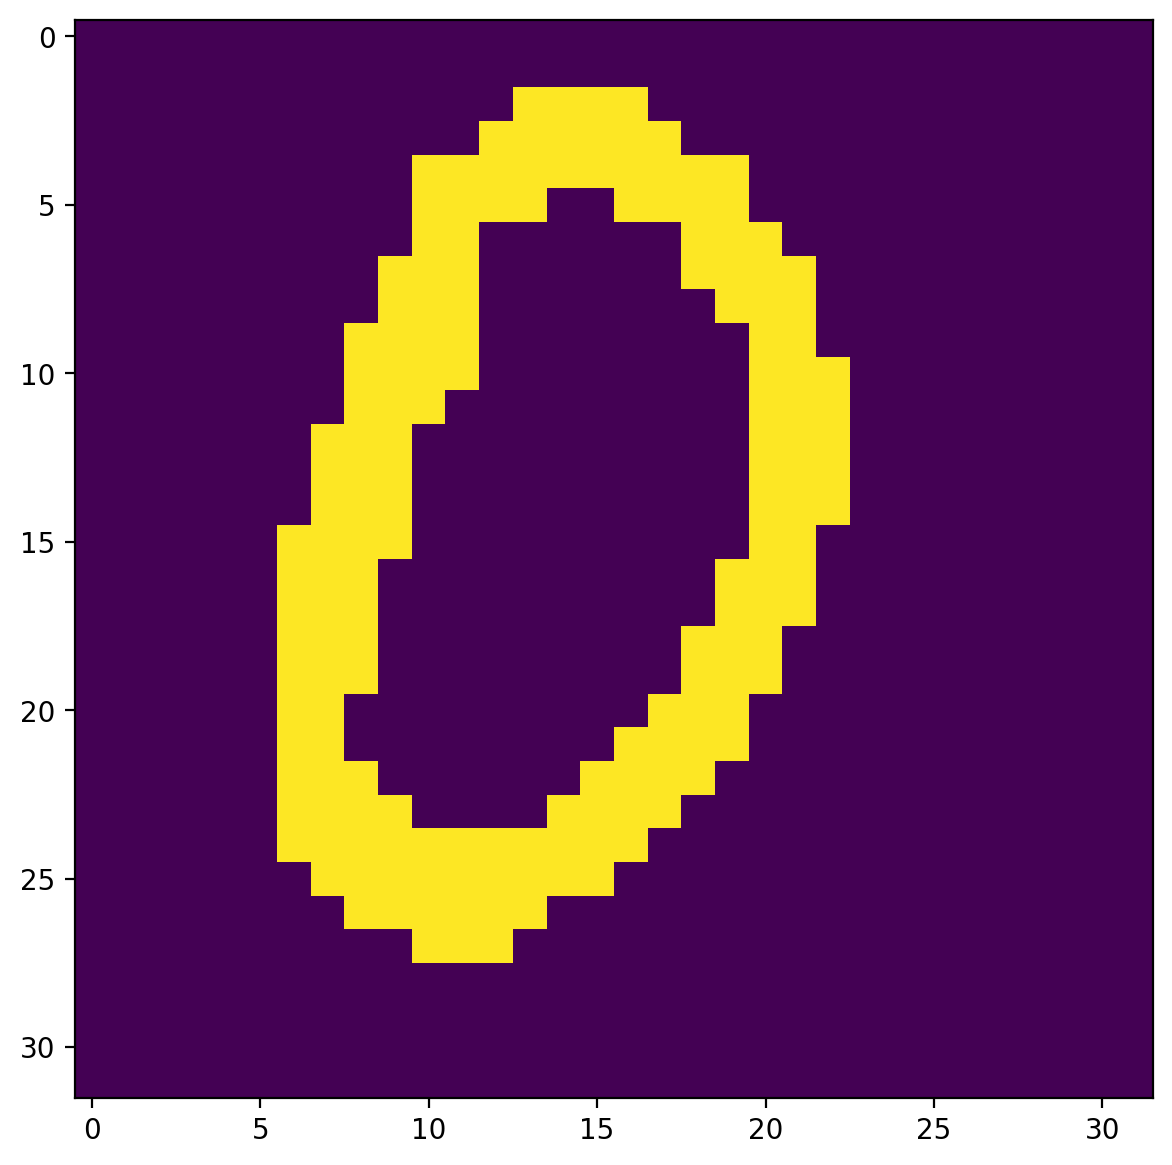

Retrieving pattern 1 with p = 0.05


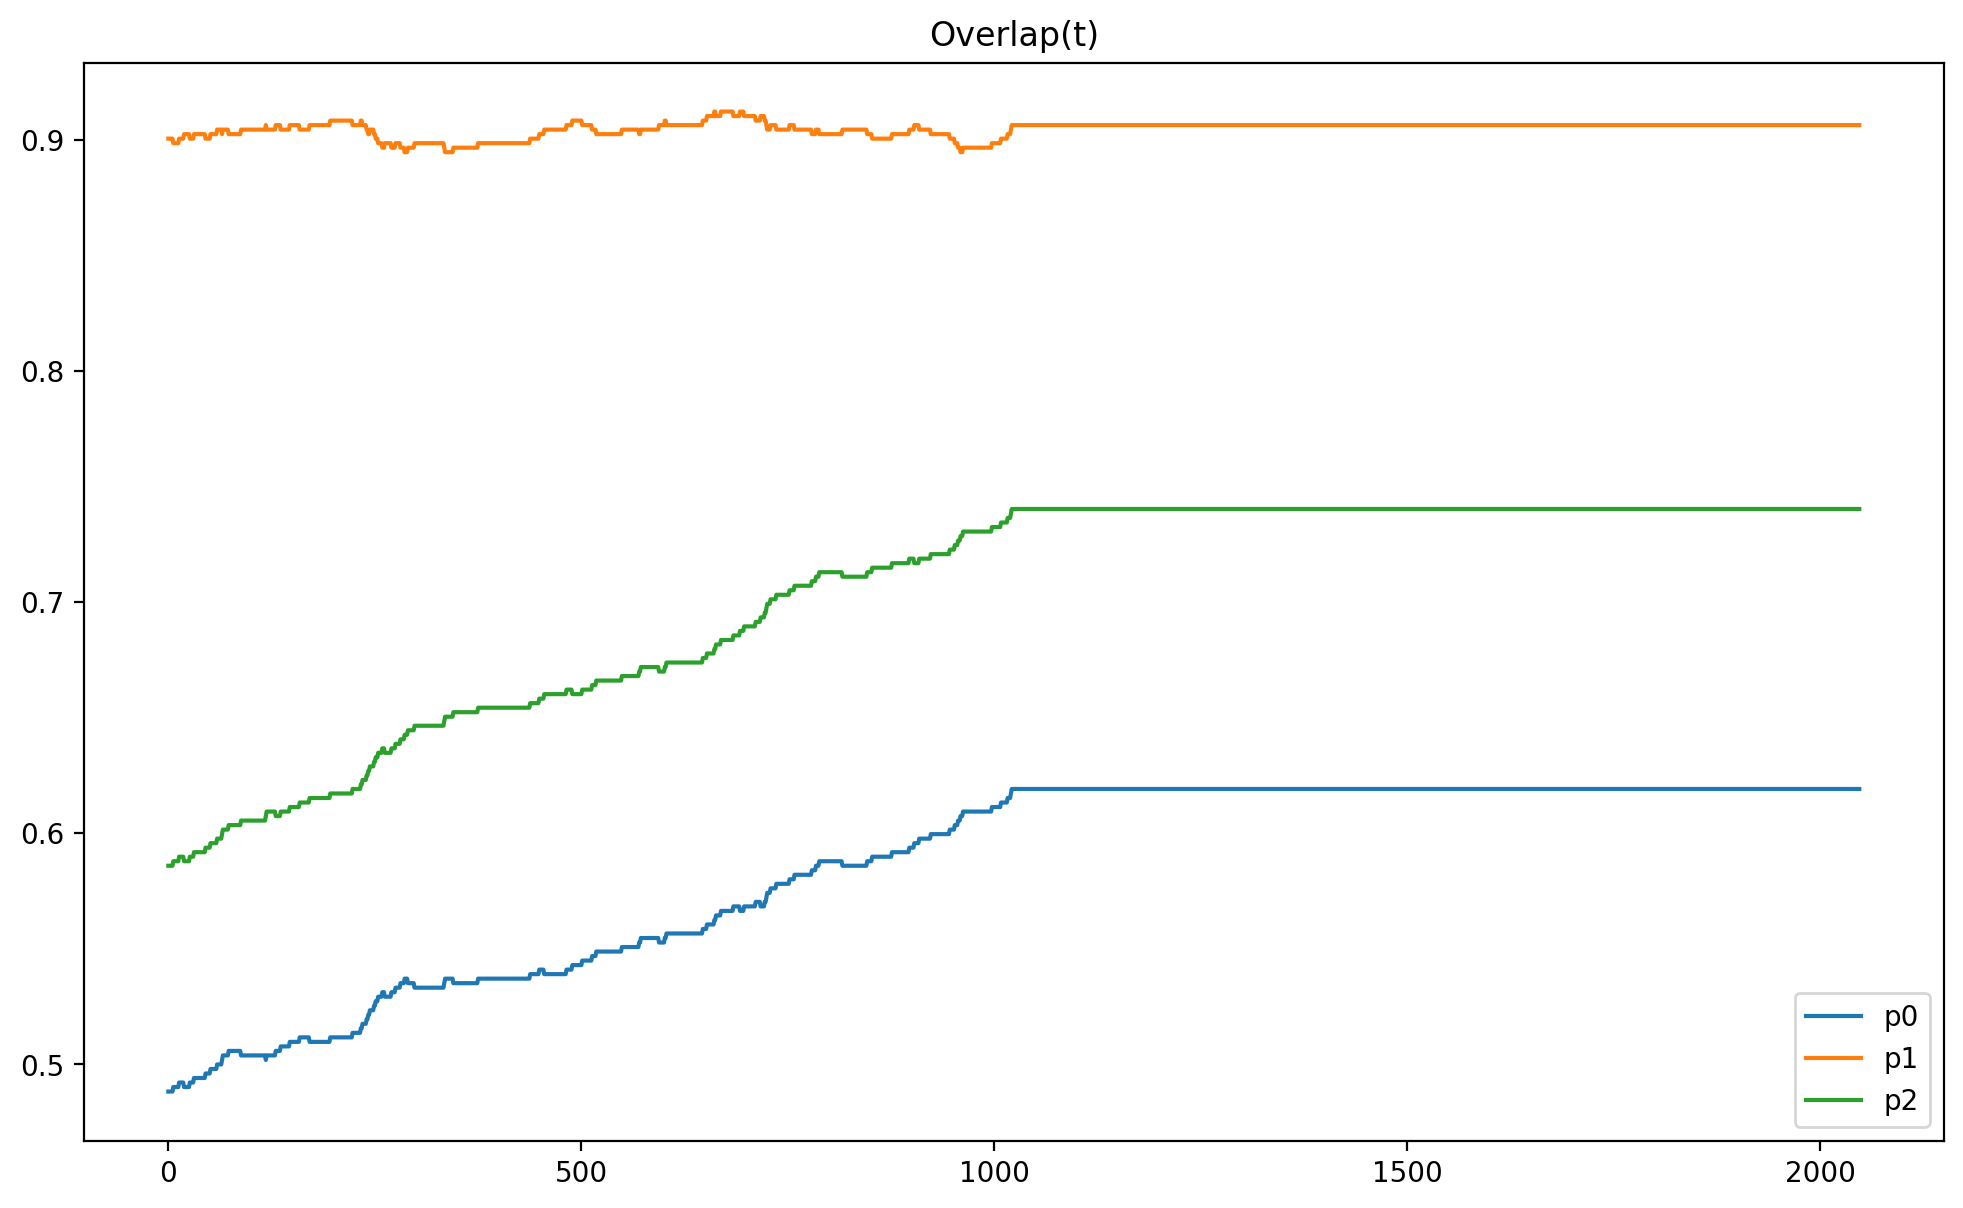

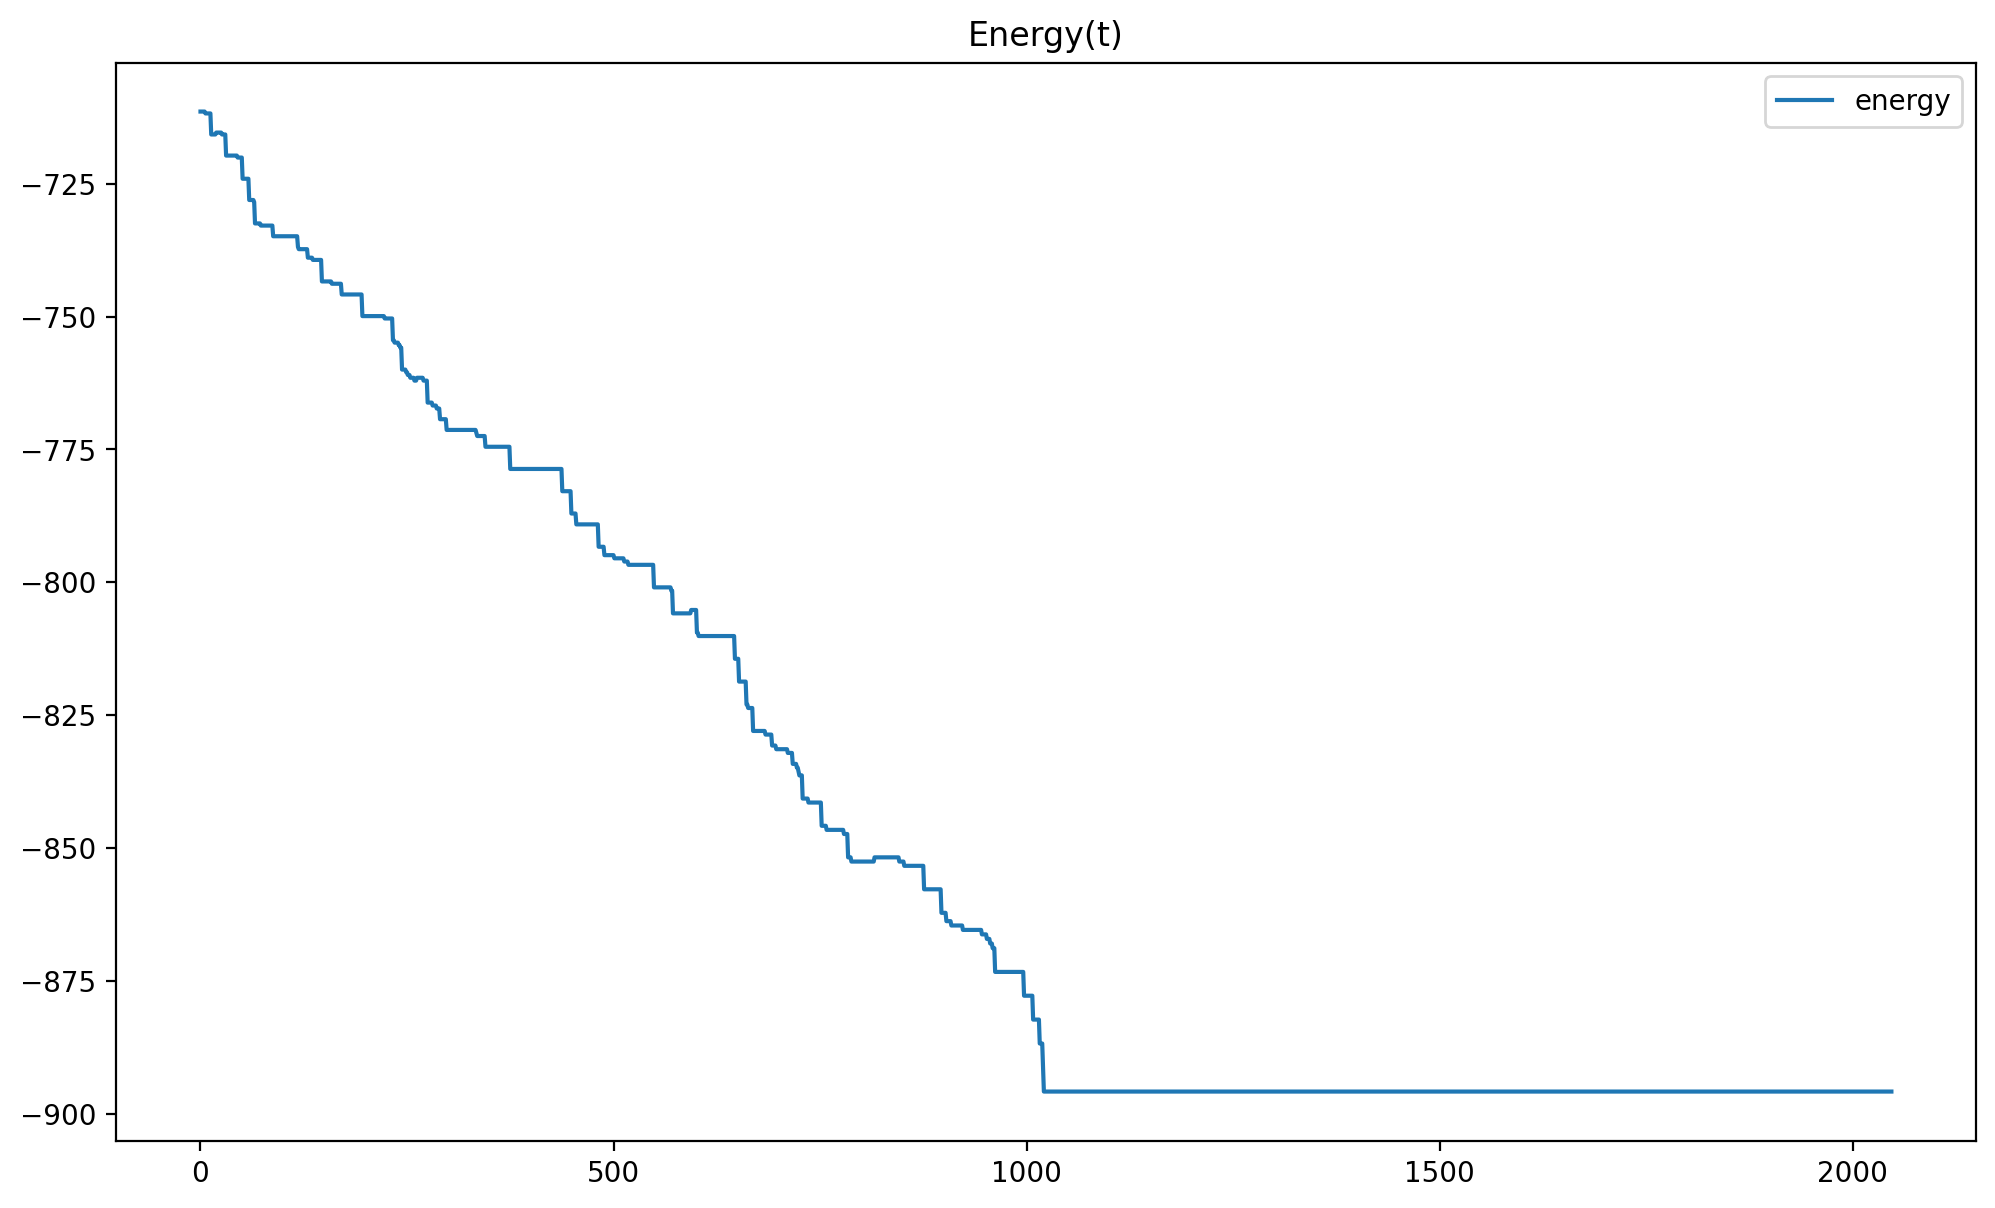

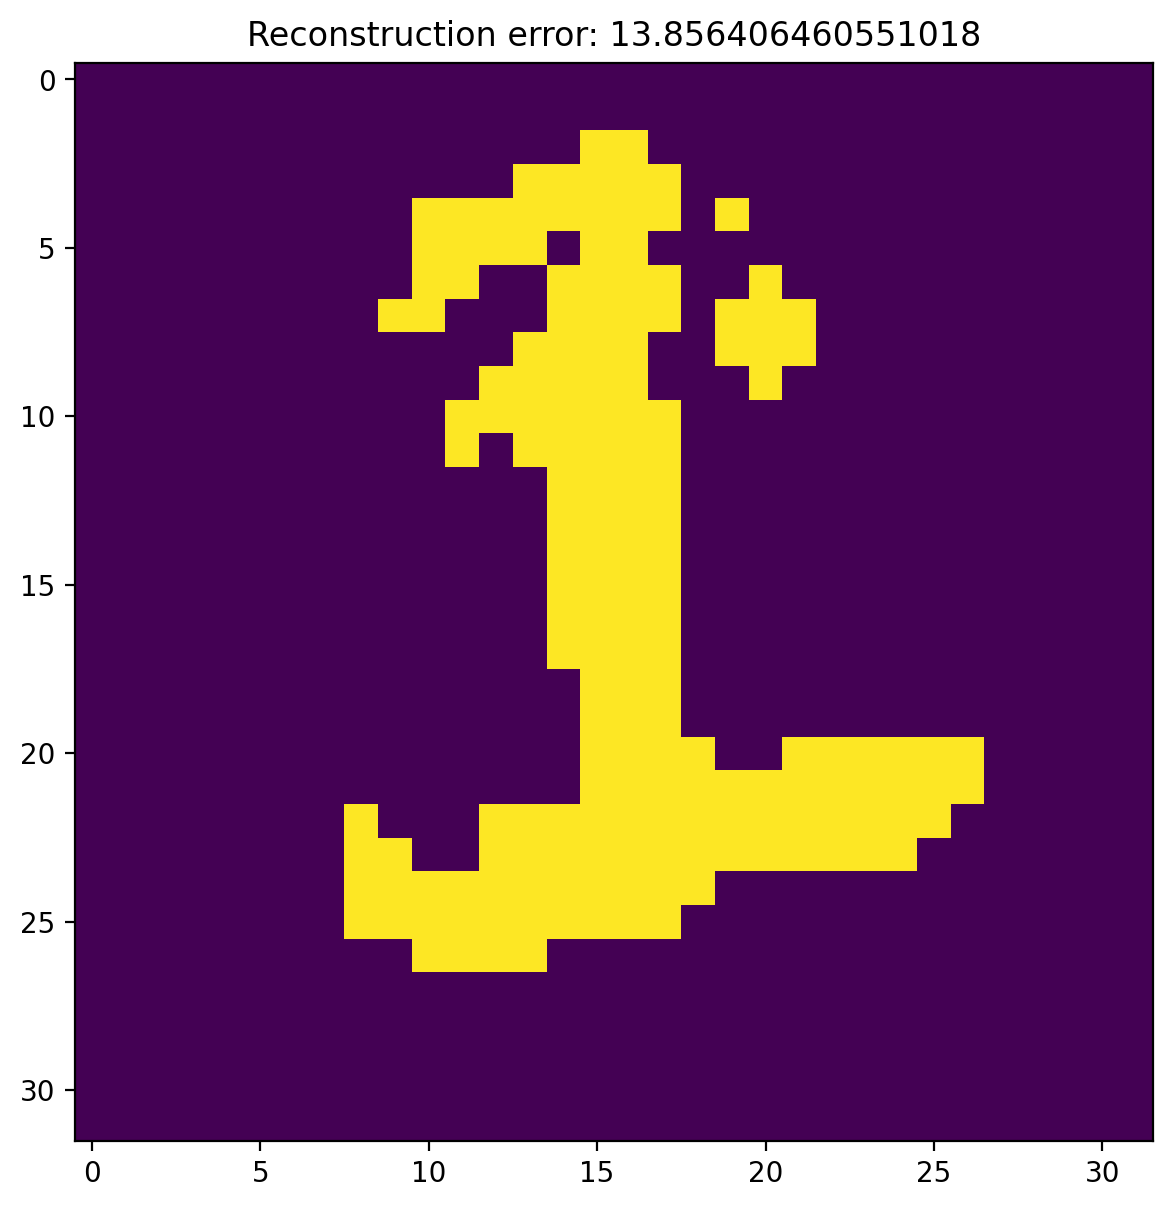

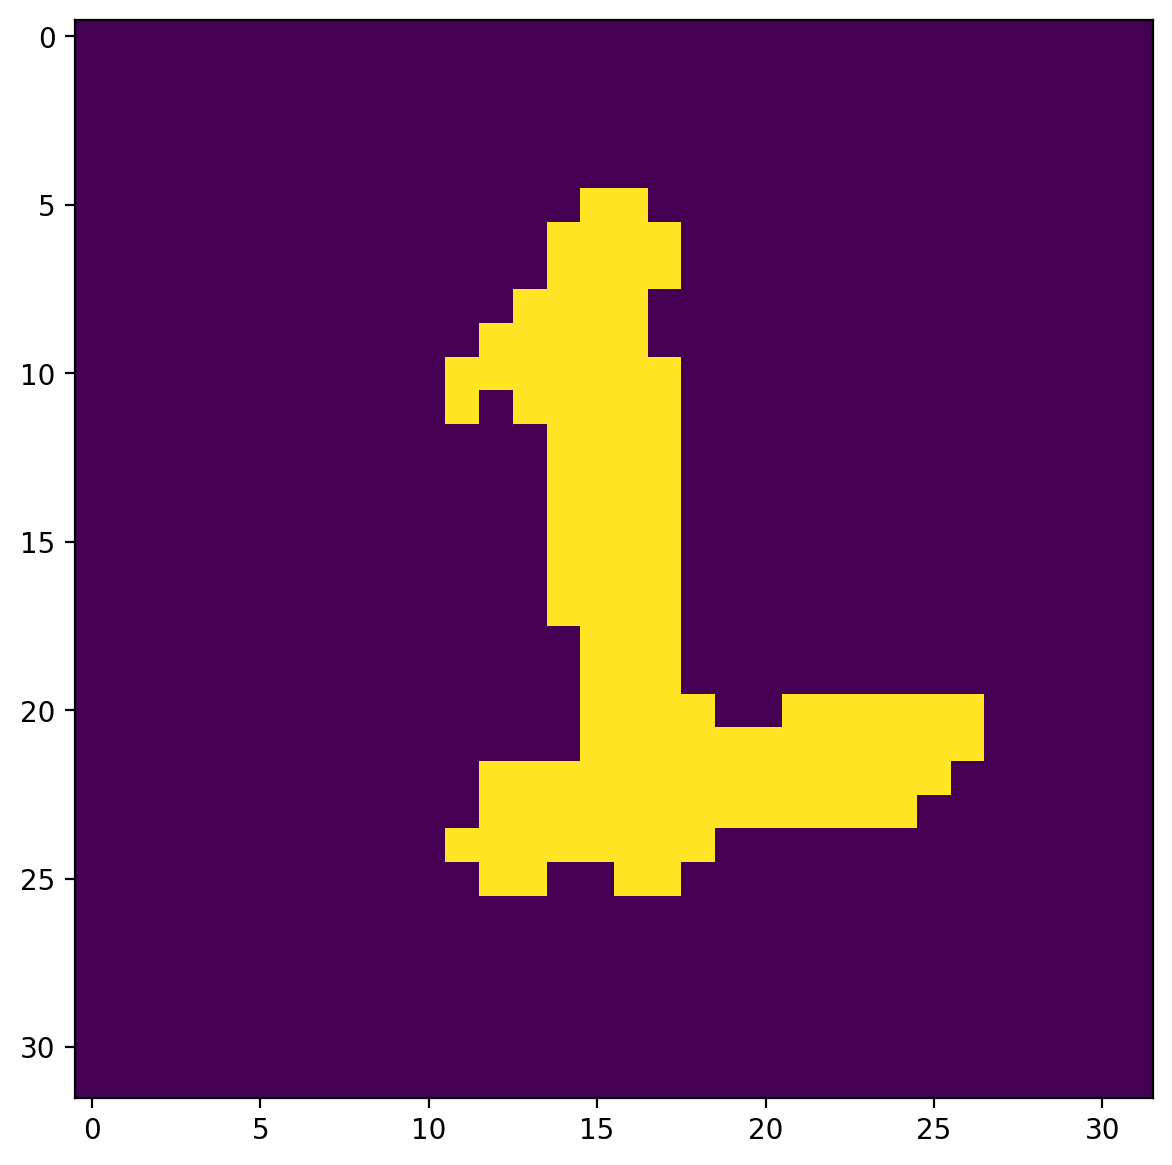

Retrieving pattern 1 with p = 0.1


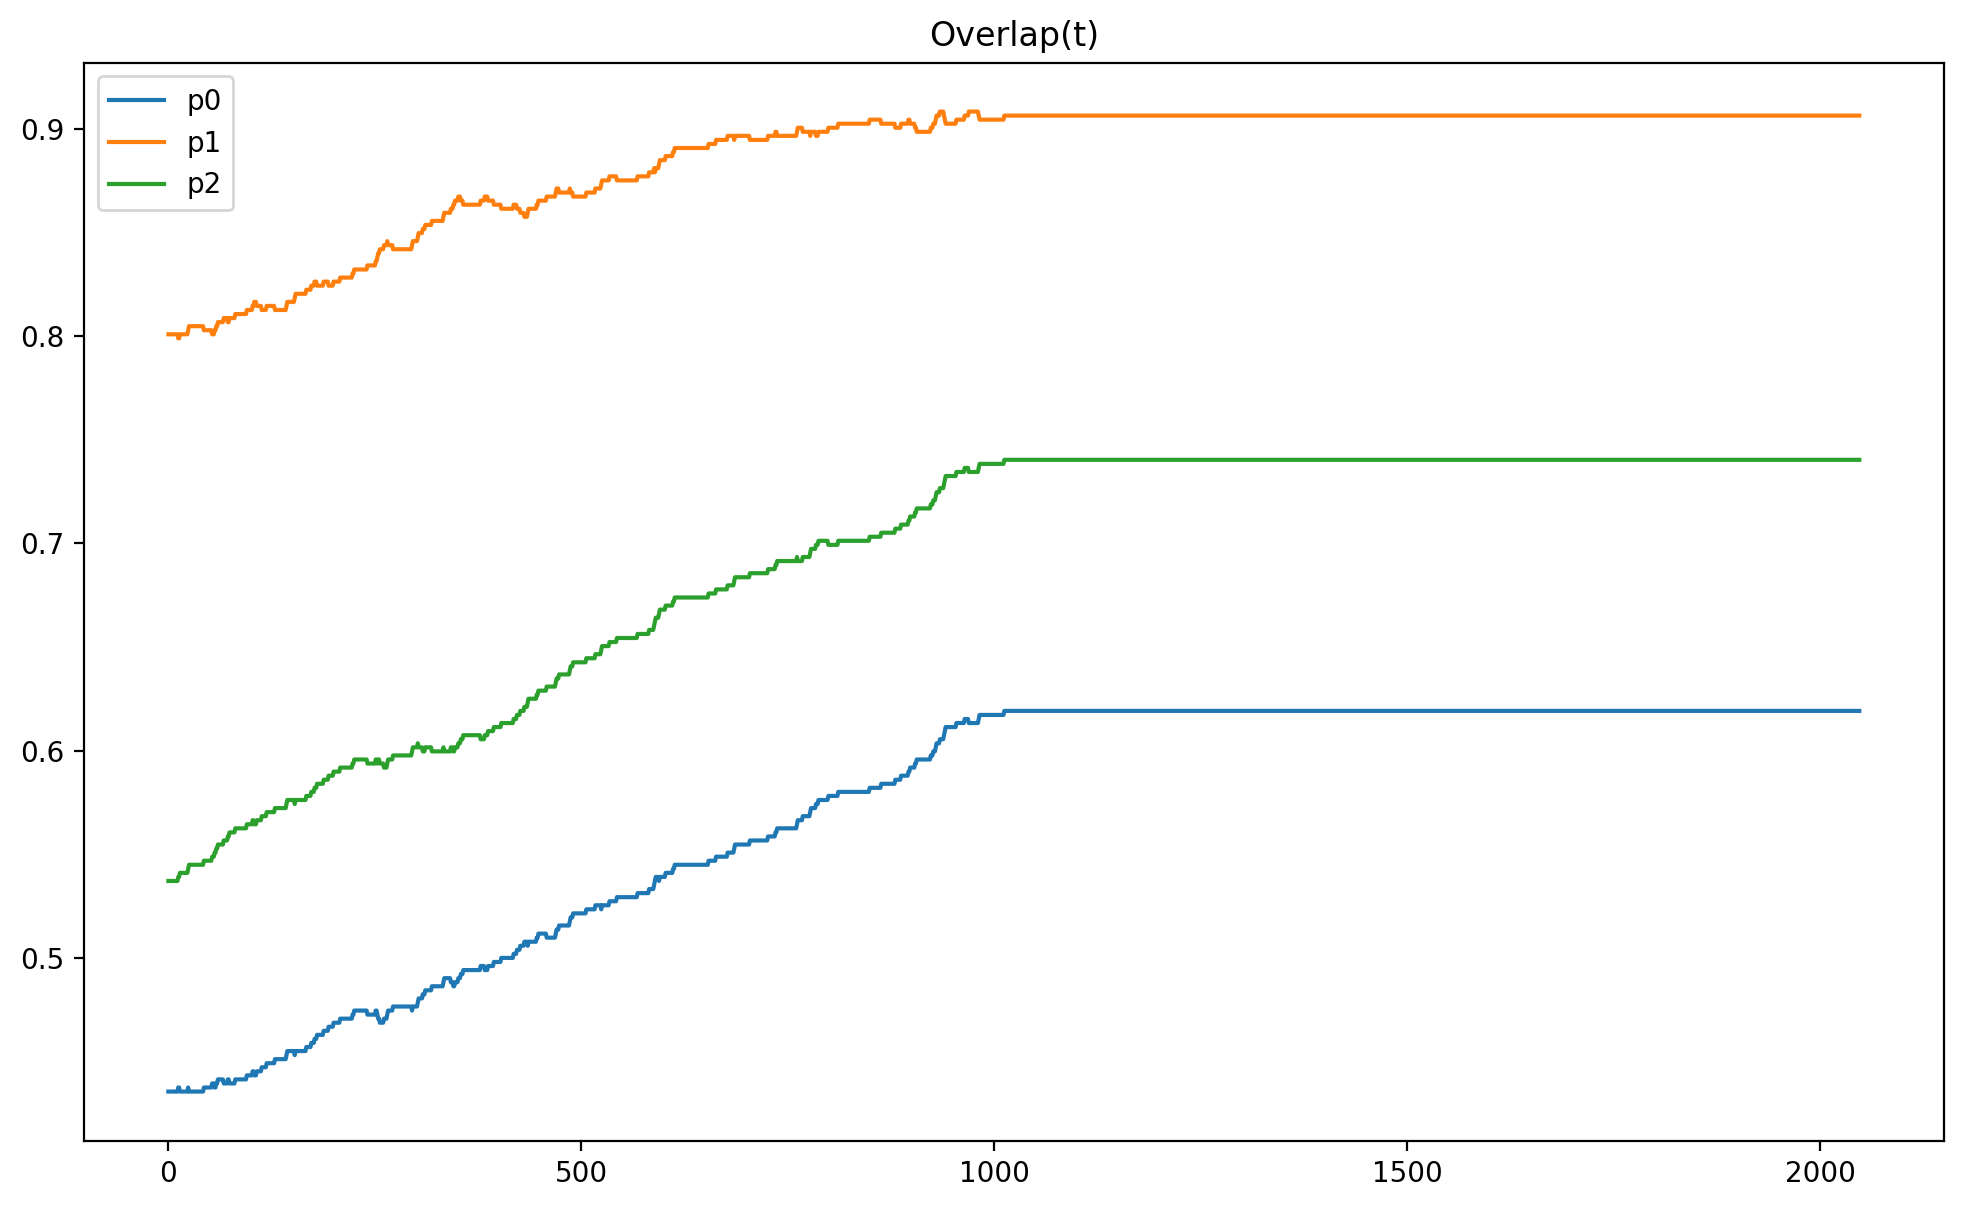

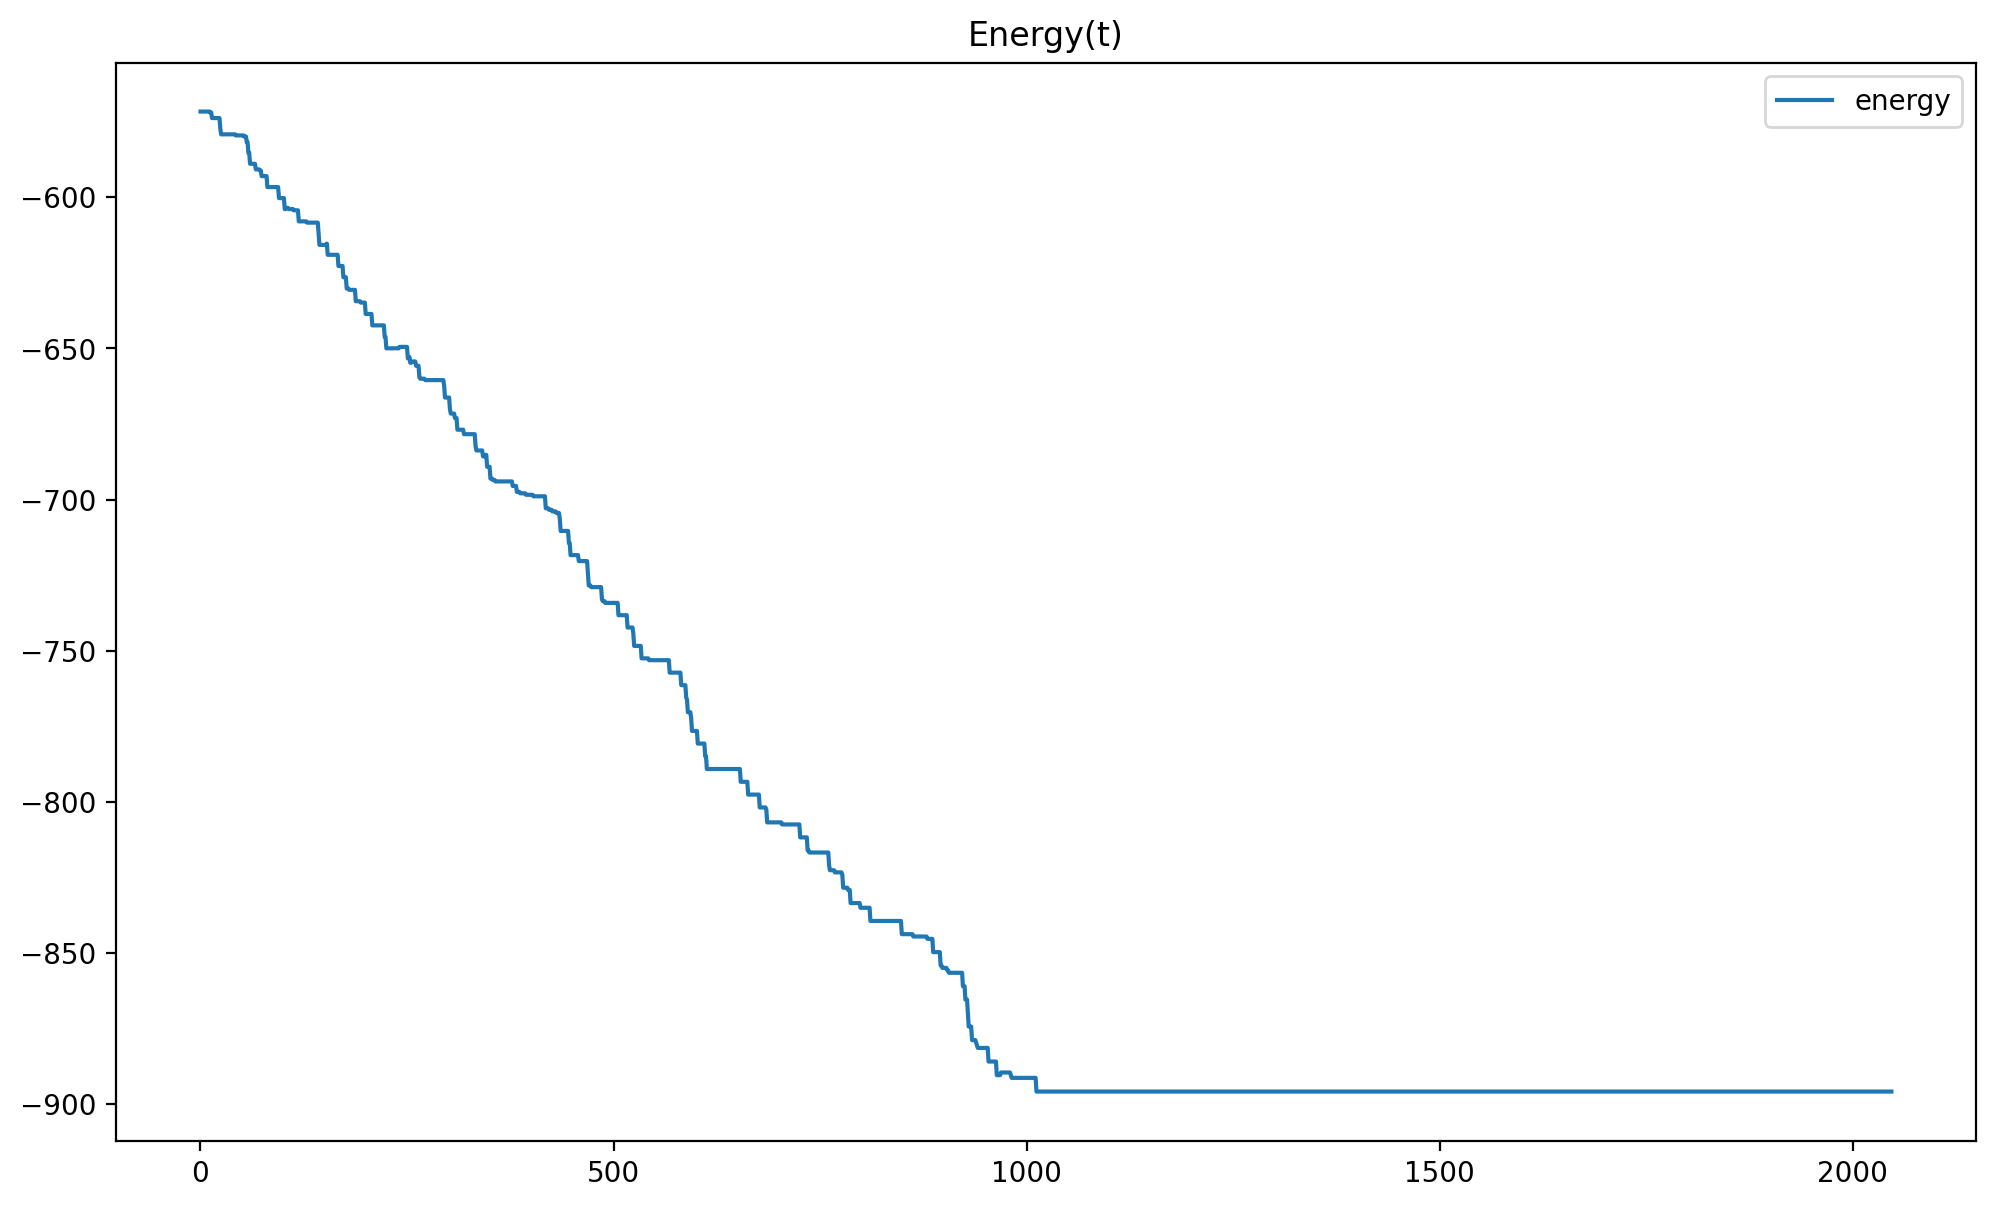

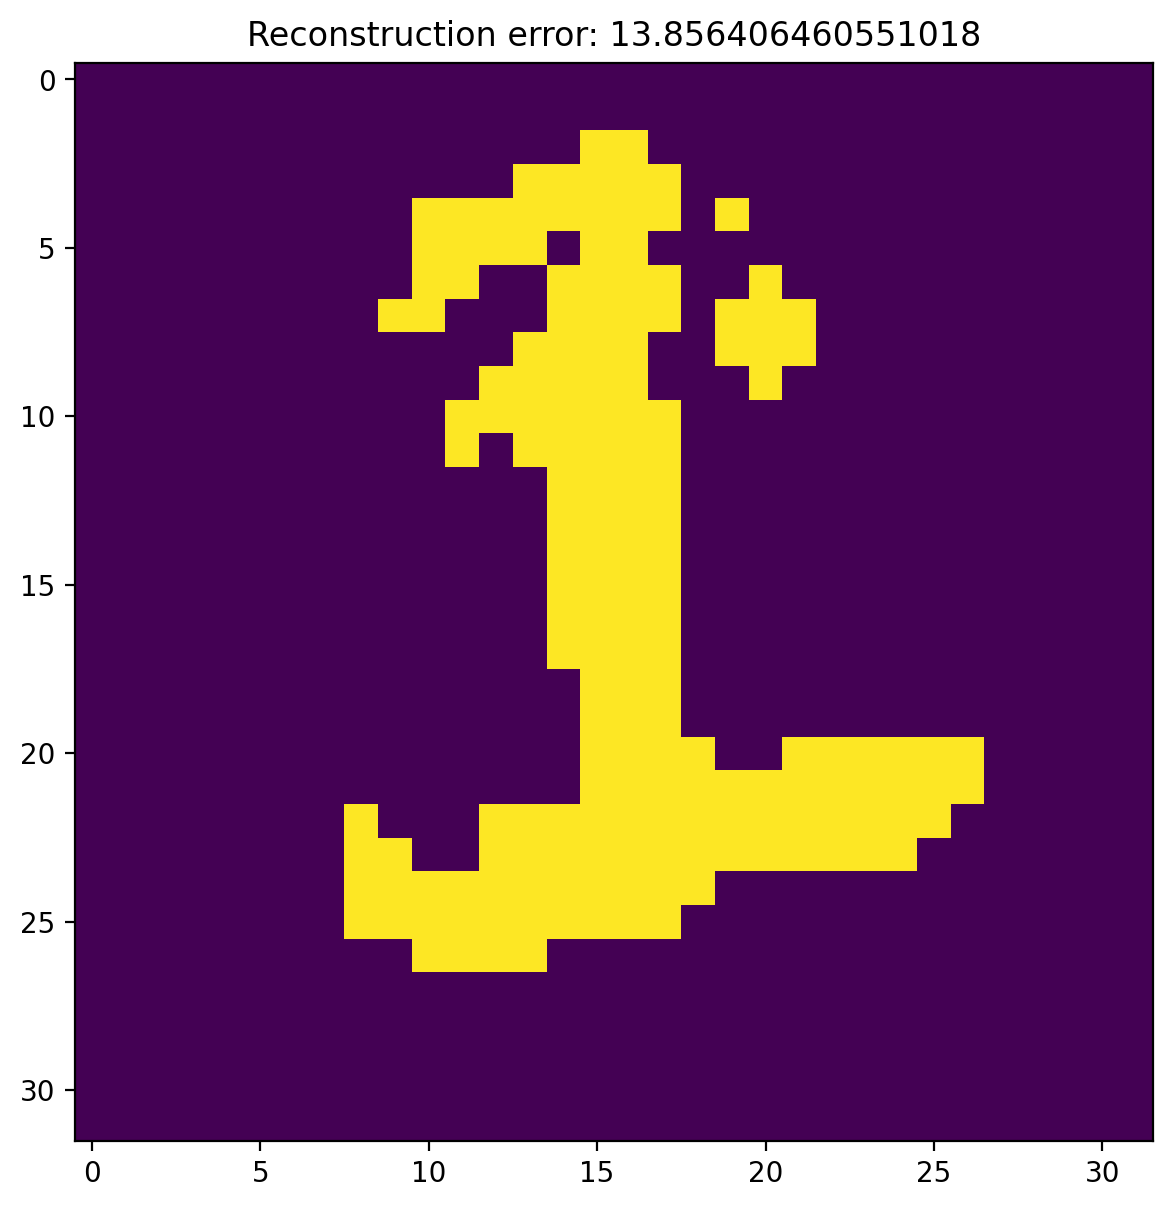

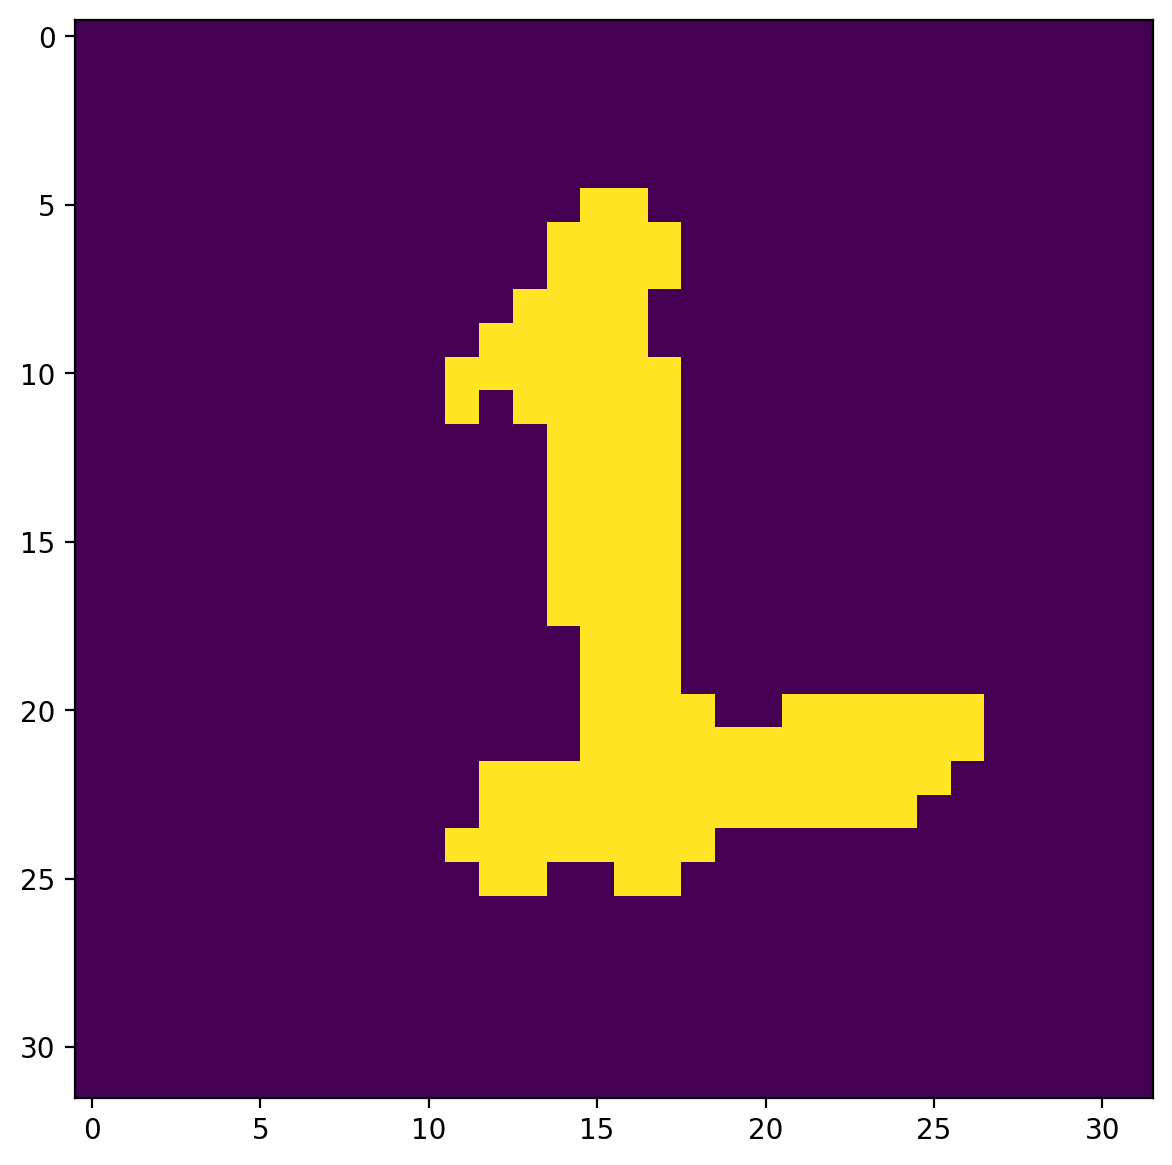

Retrieving pattern 1 with p = 0.25


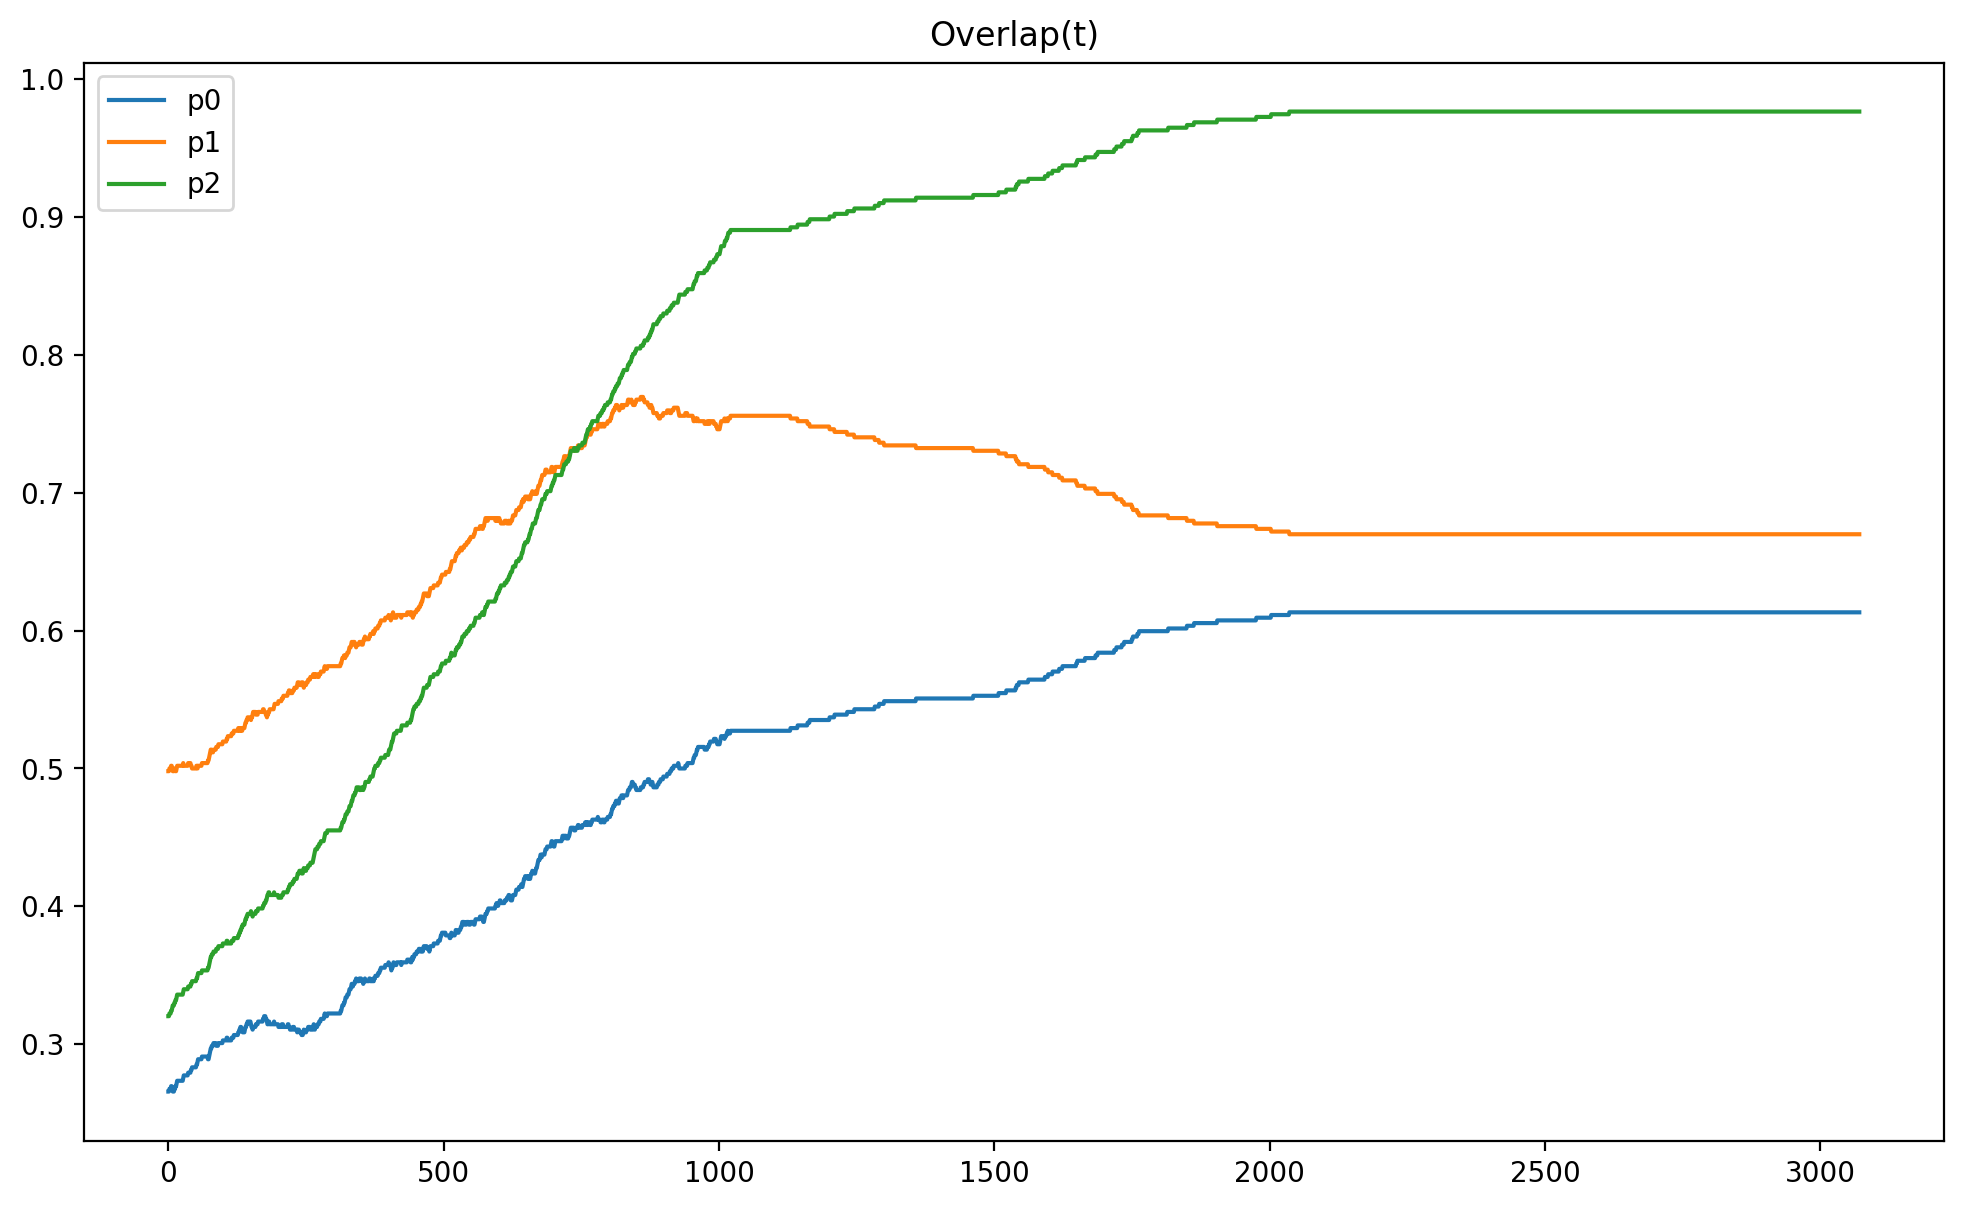

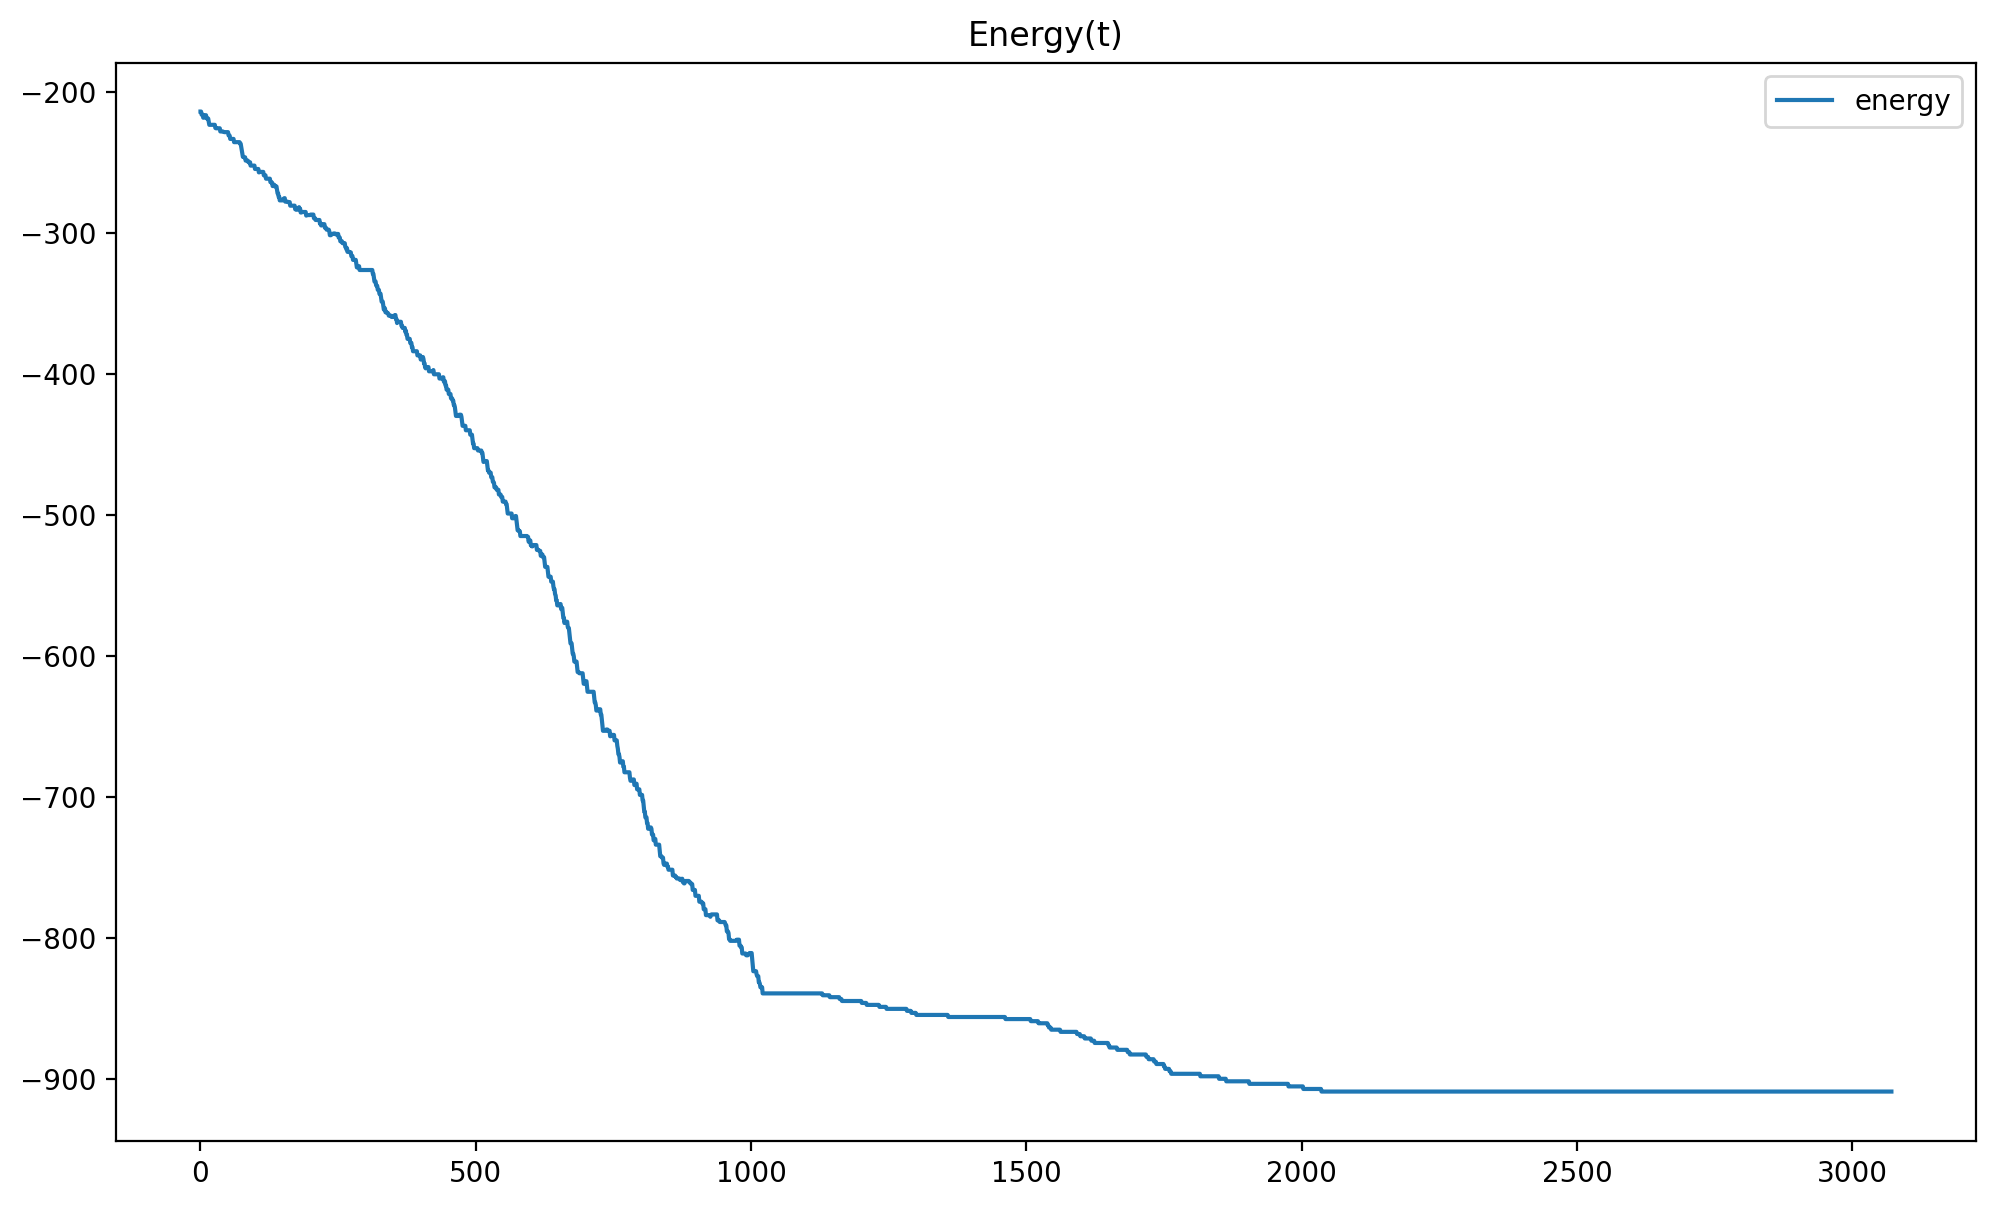

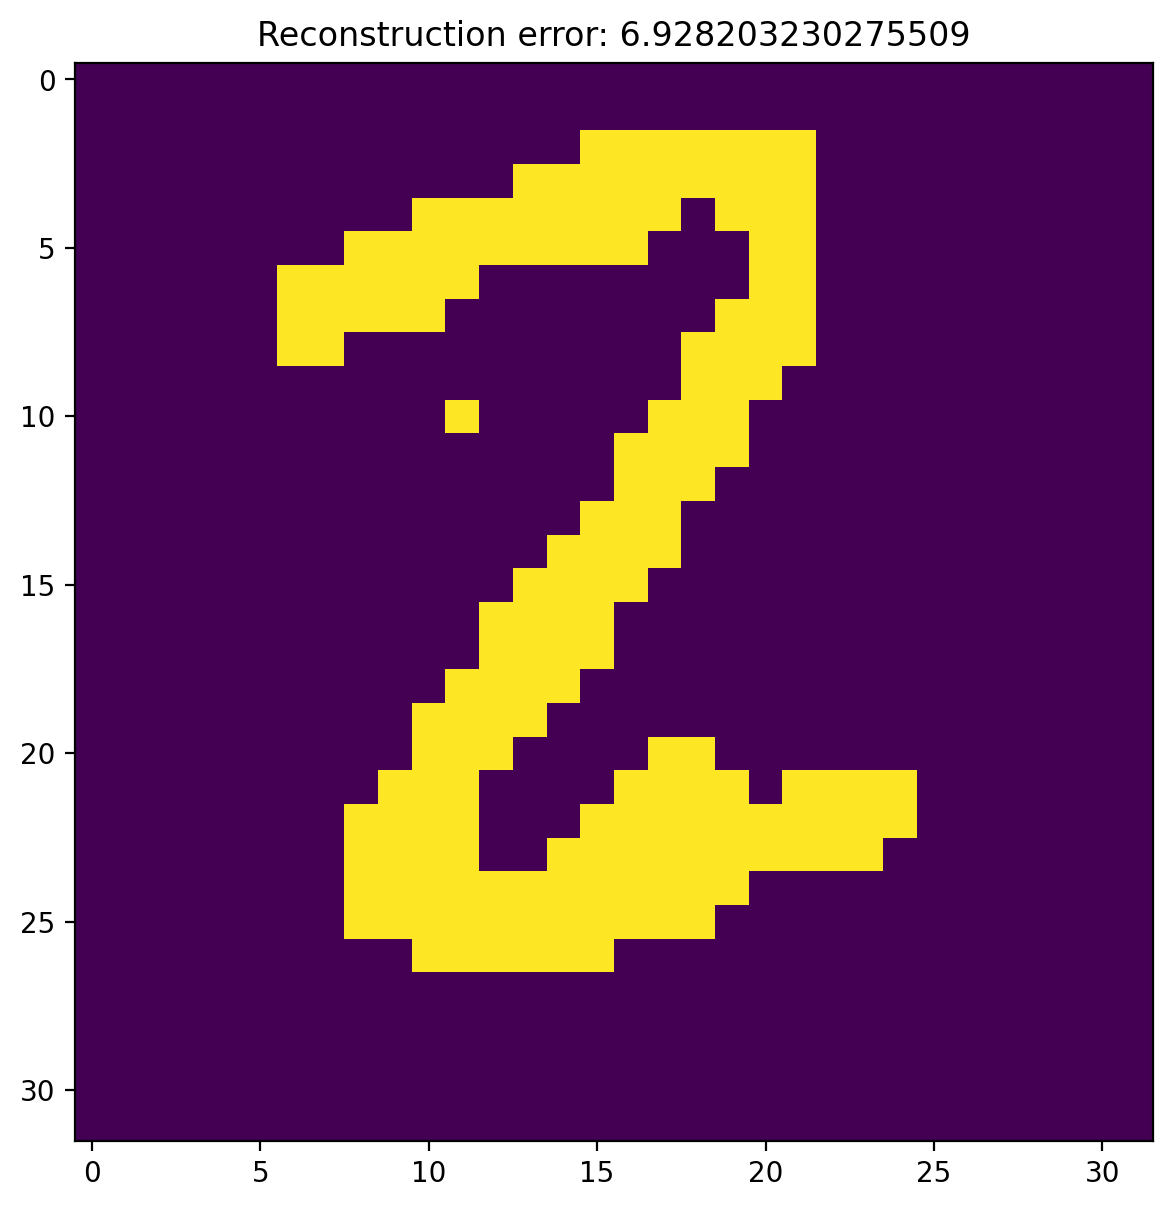

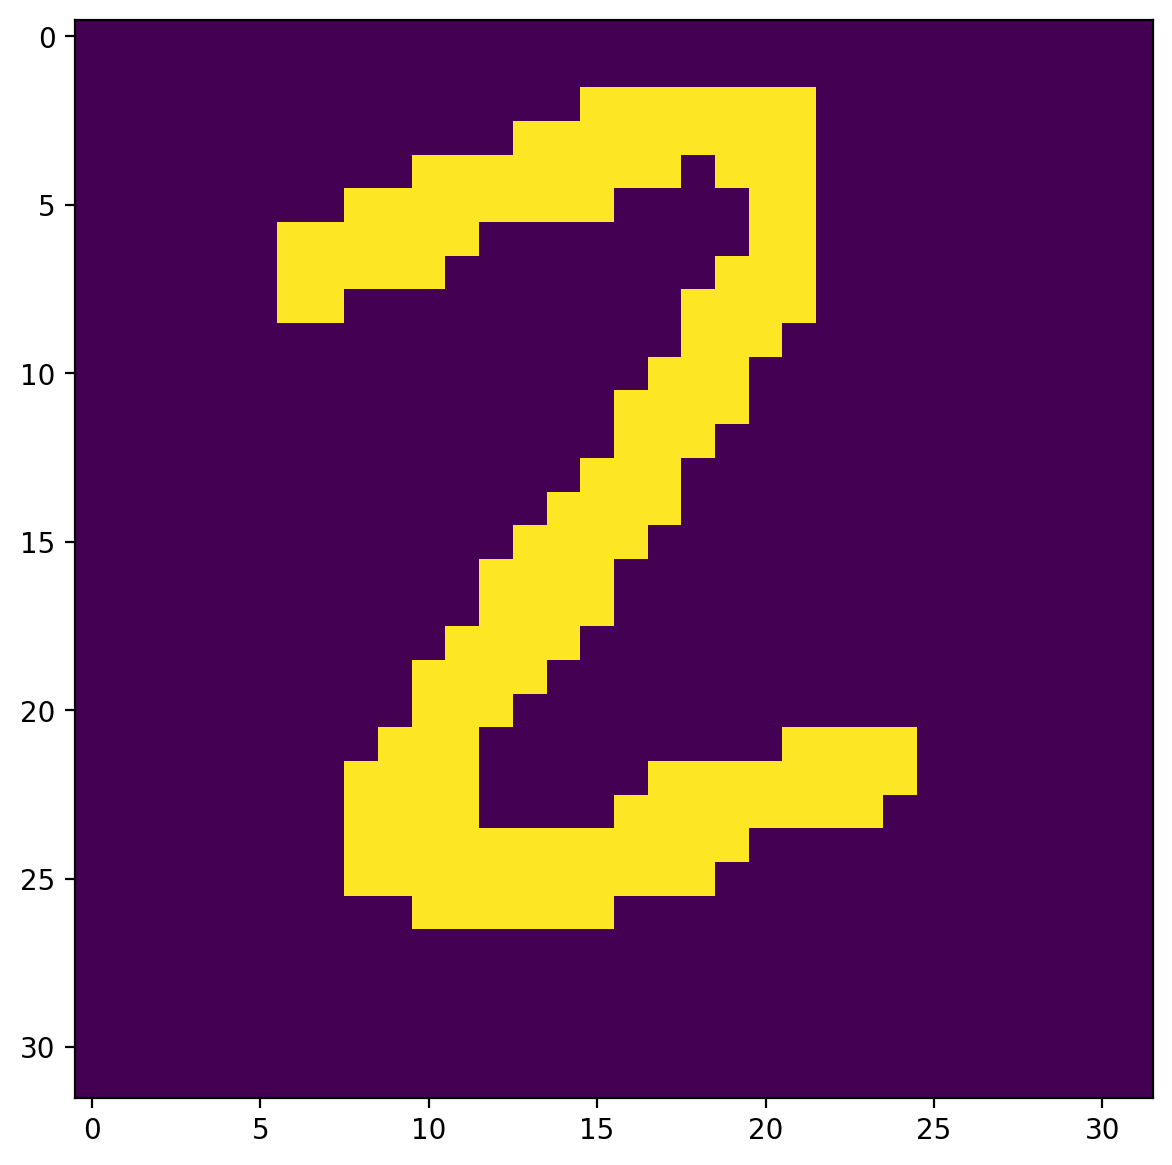

Retrieving pattern 2 with p = 0.05


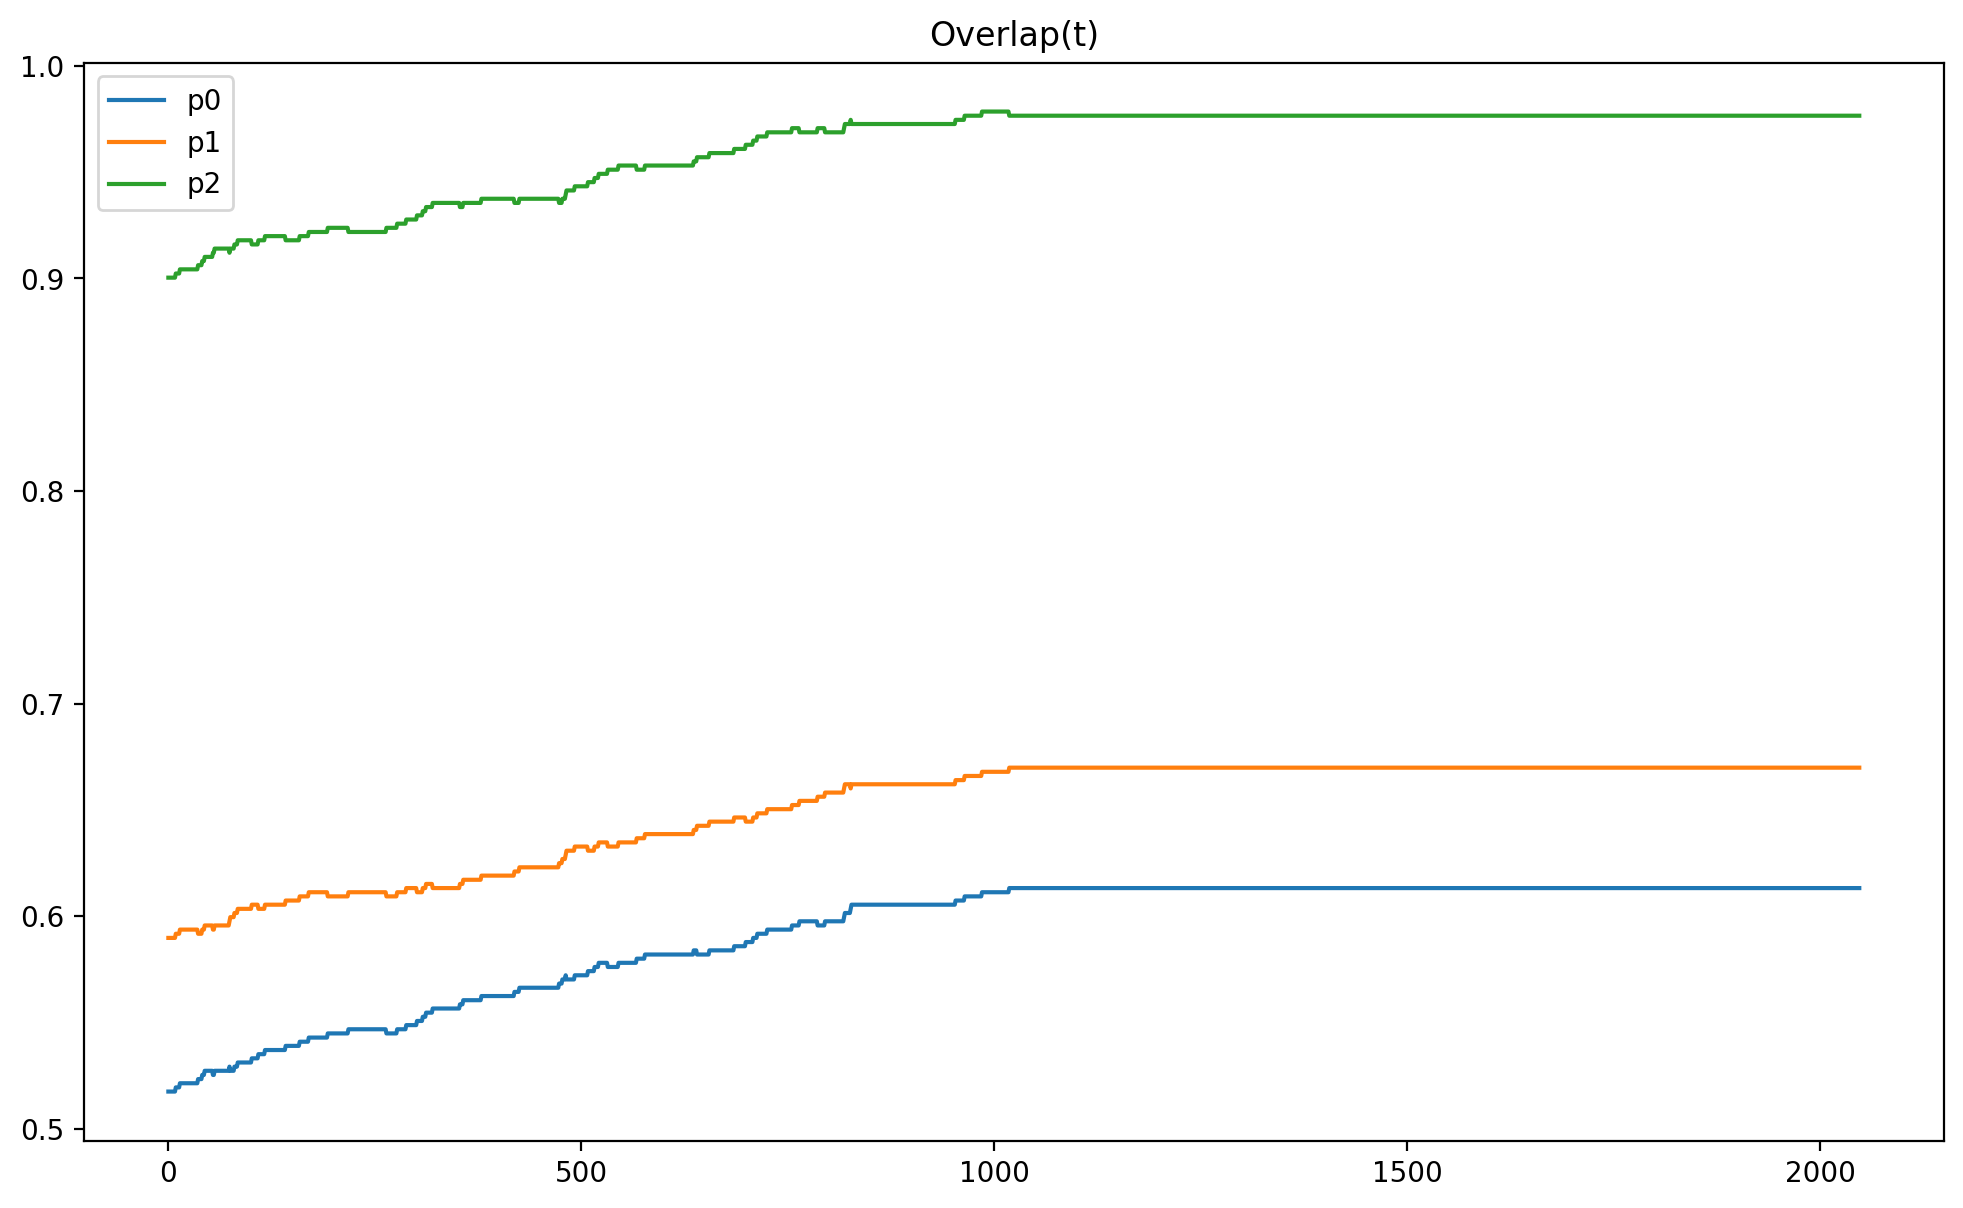

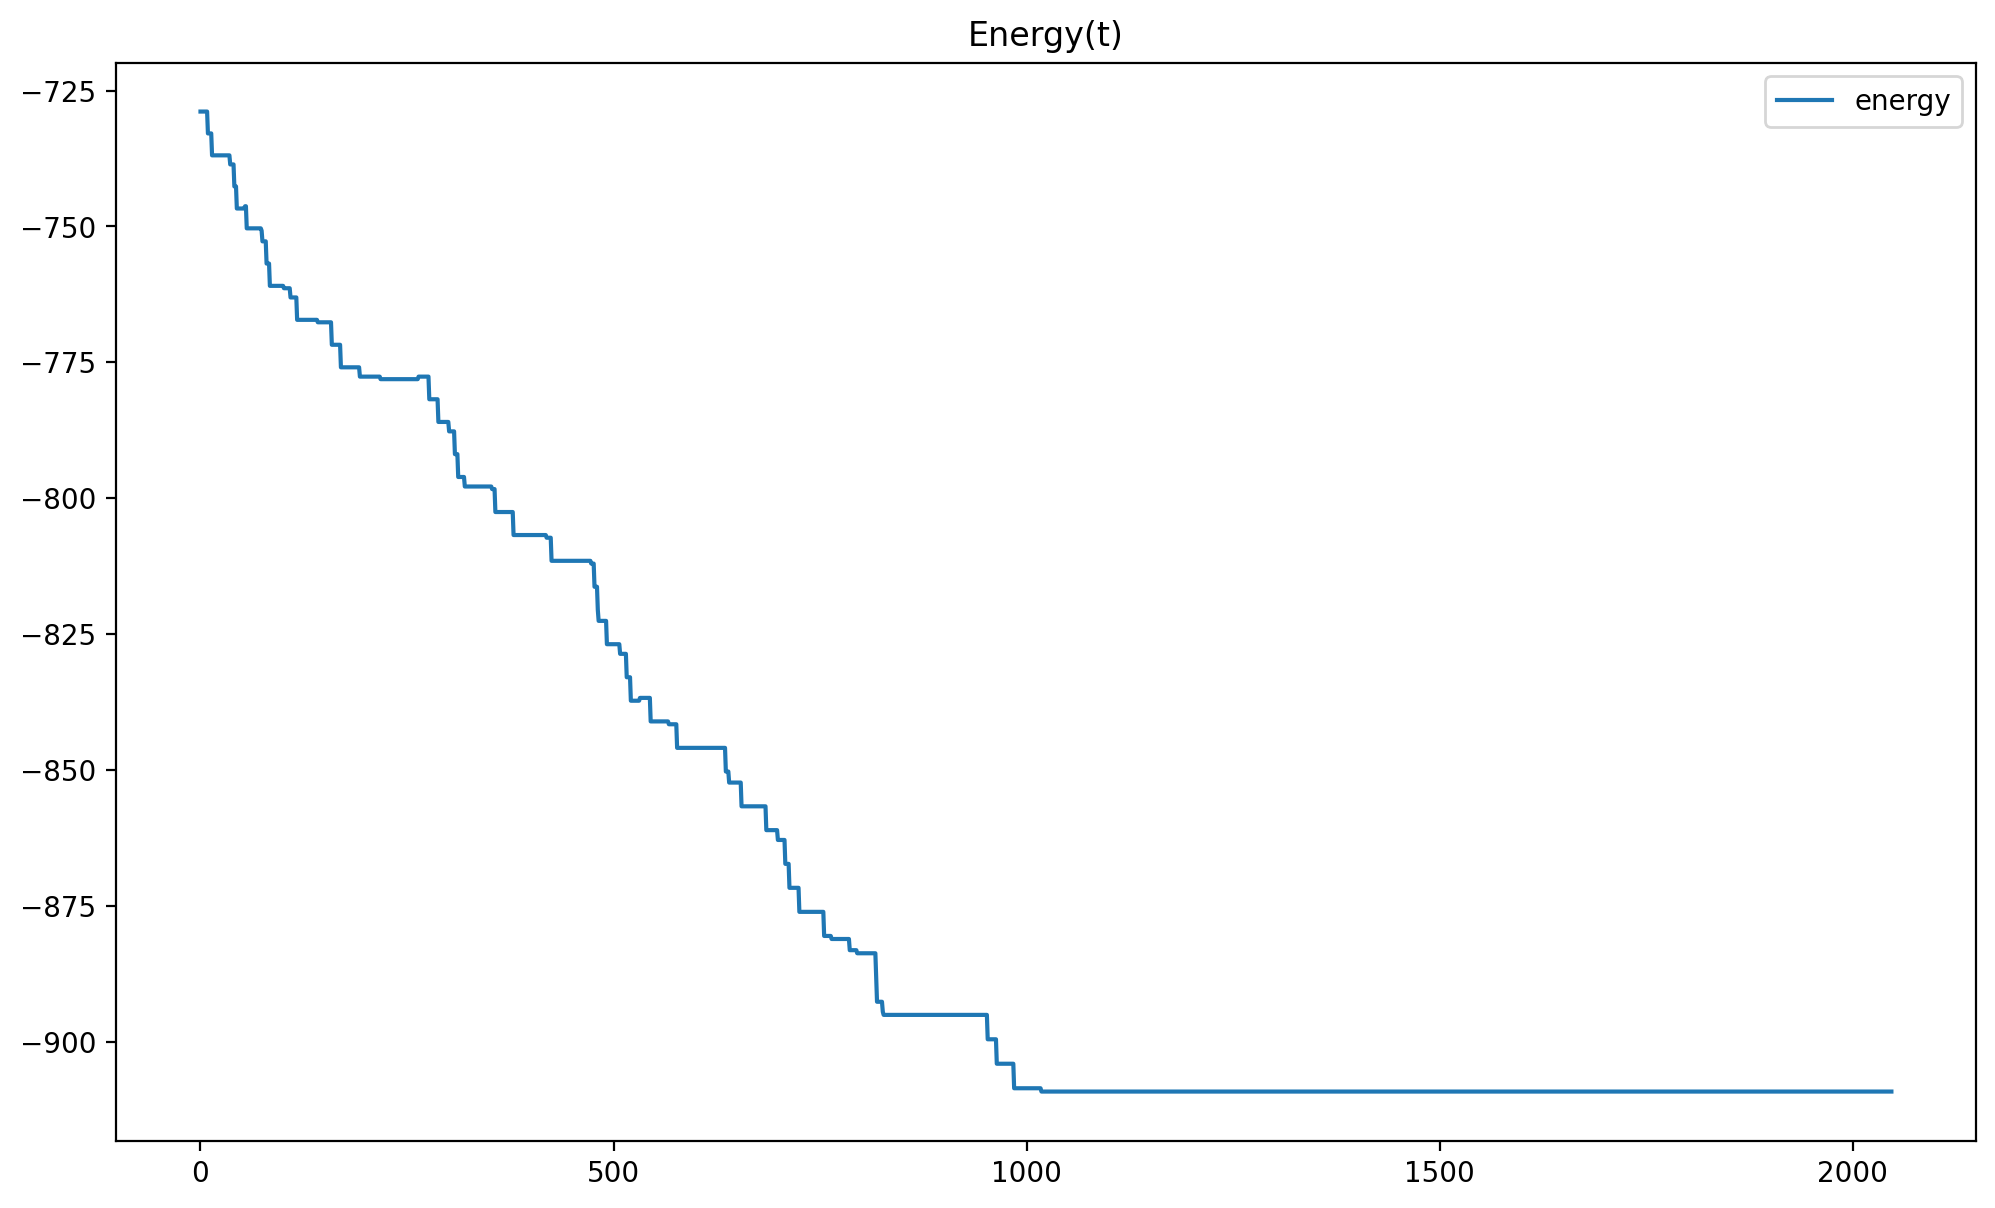

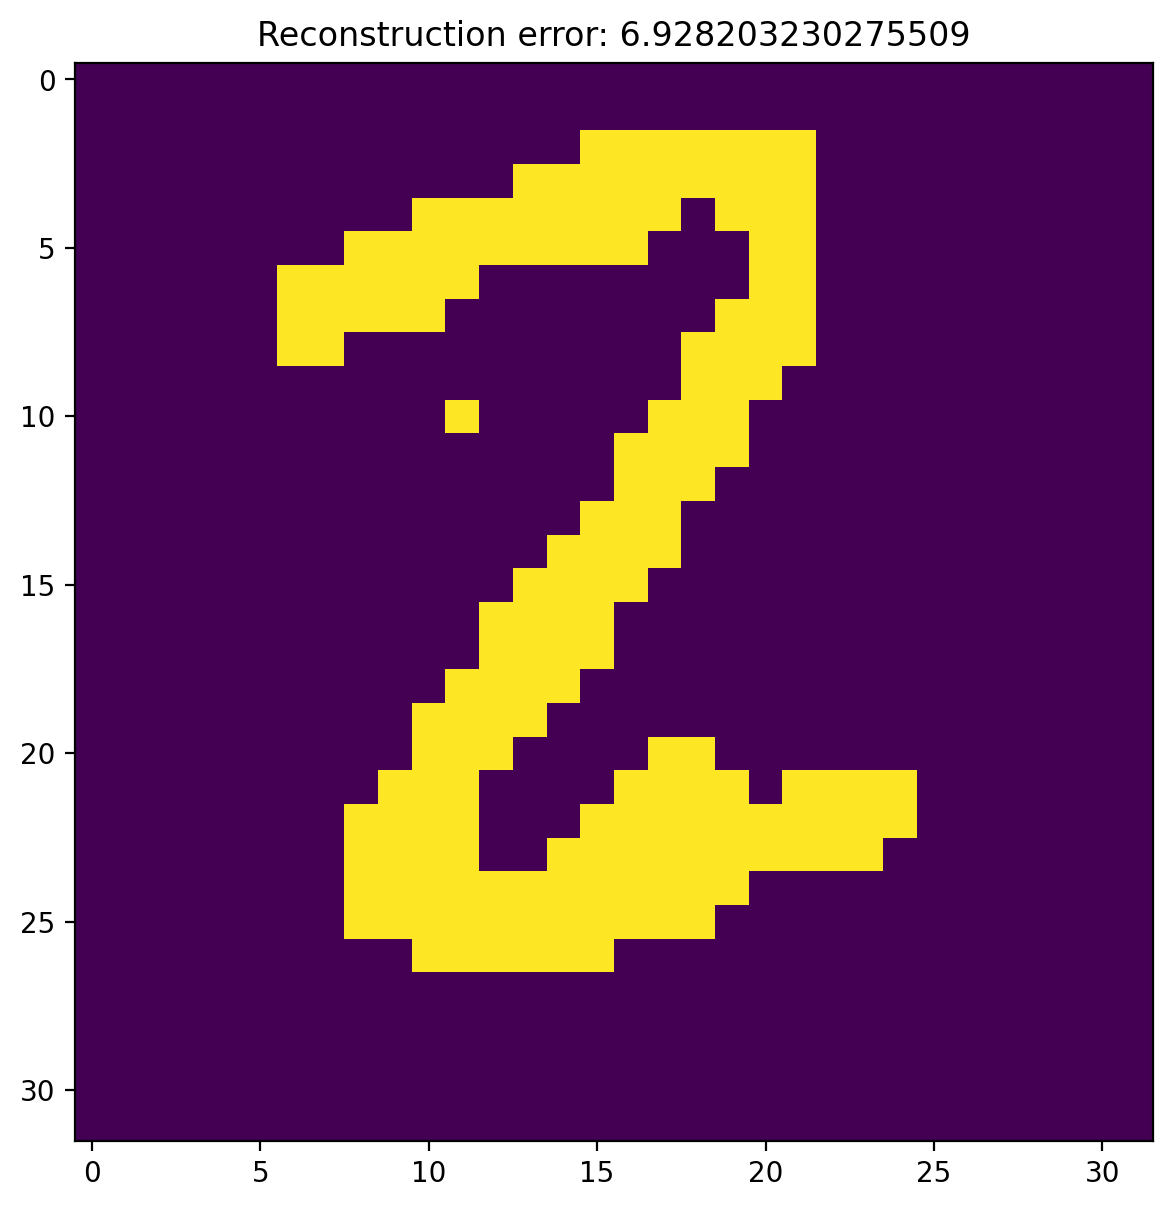

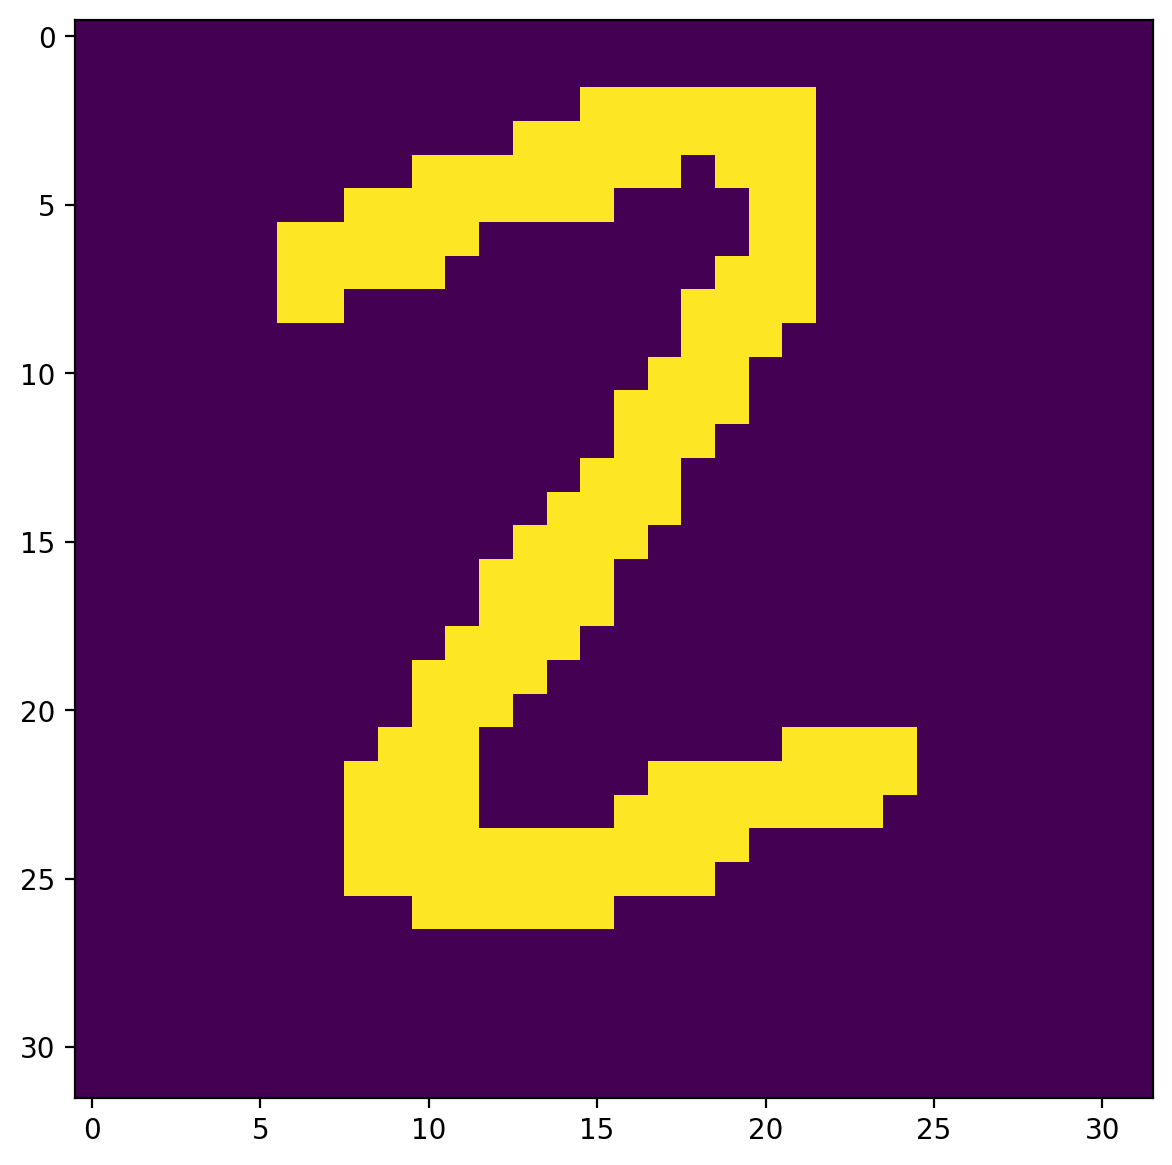

Retrieving pattern 2 with p = 0.1


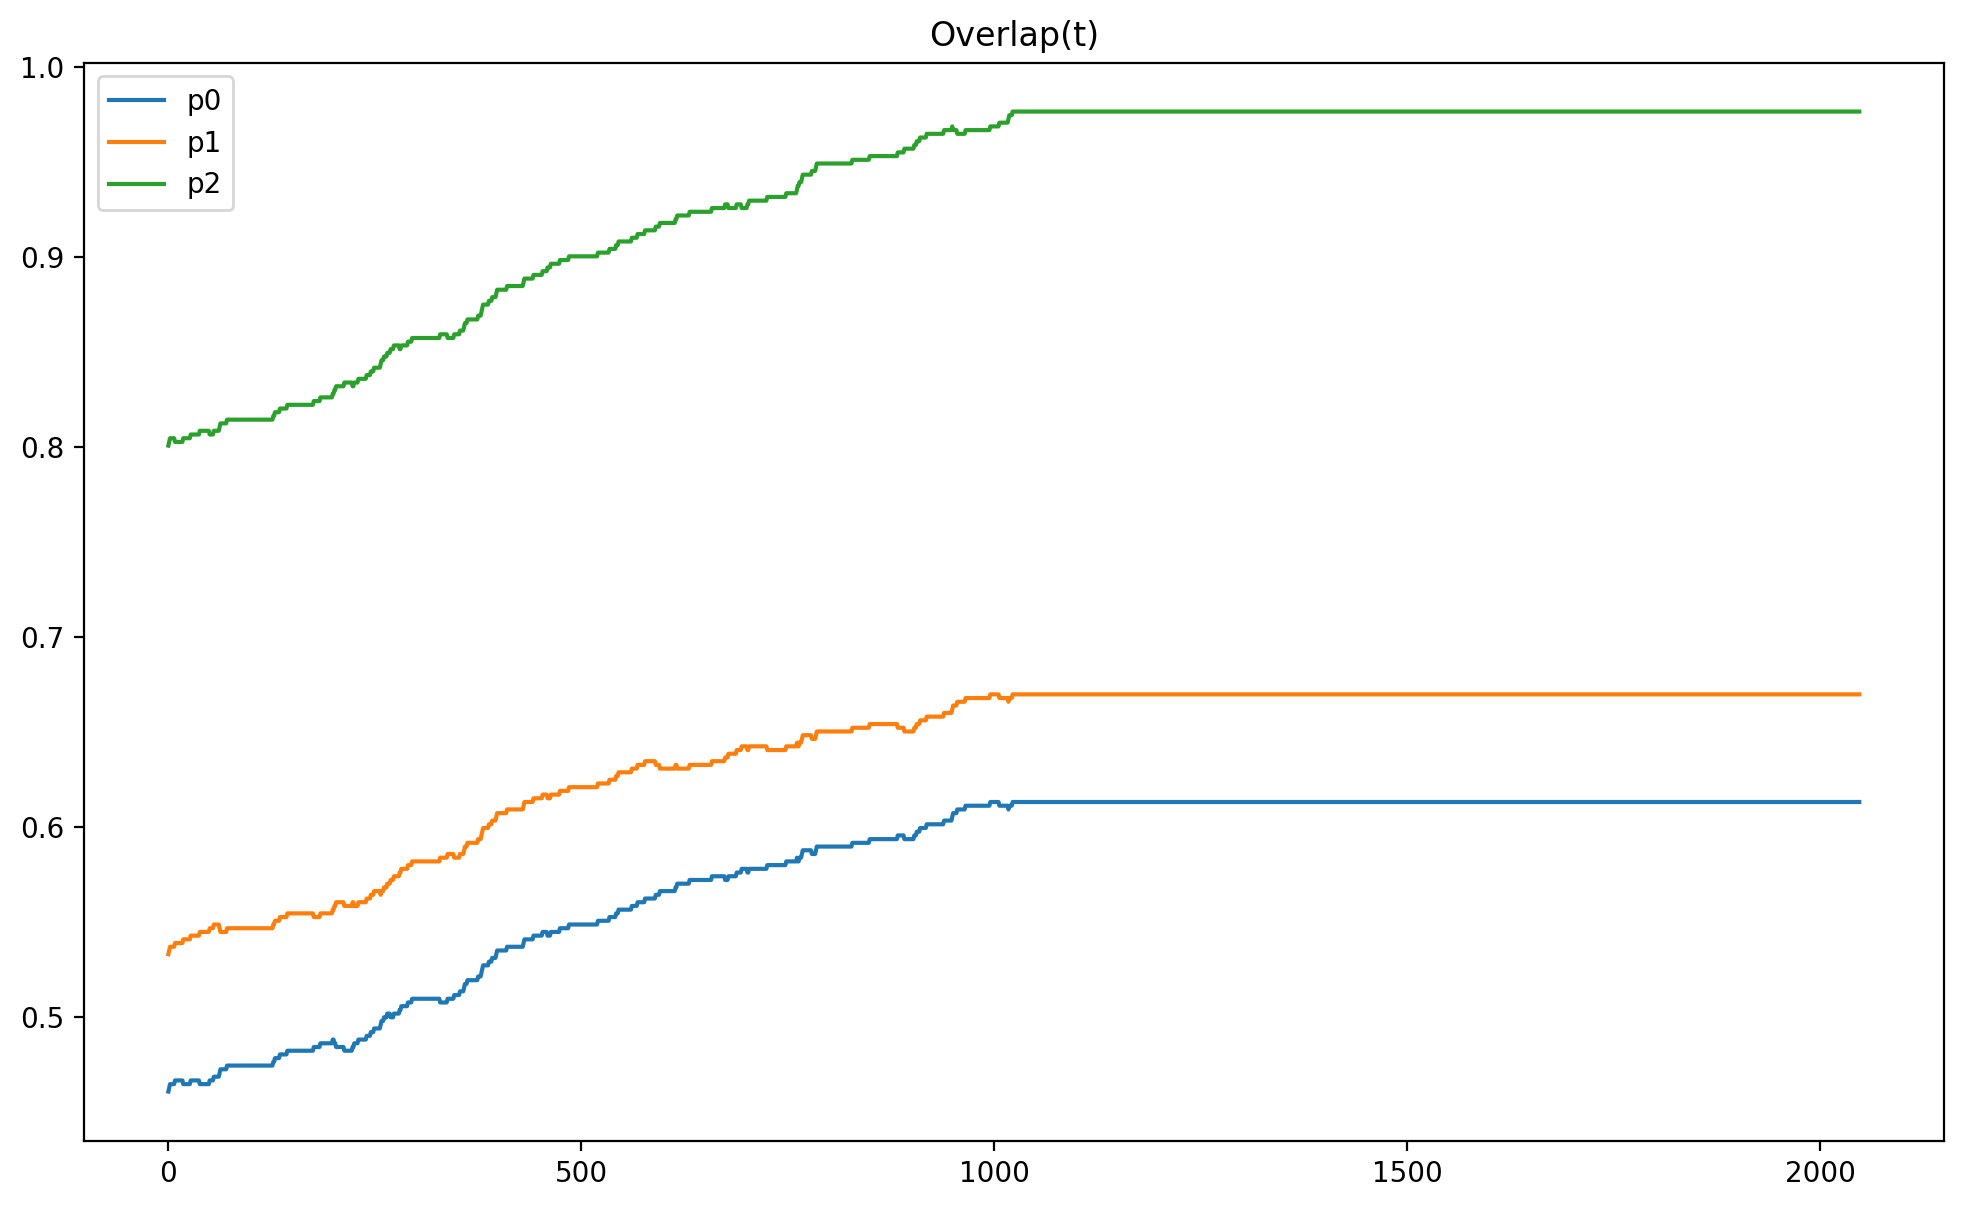

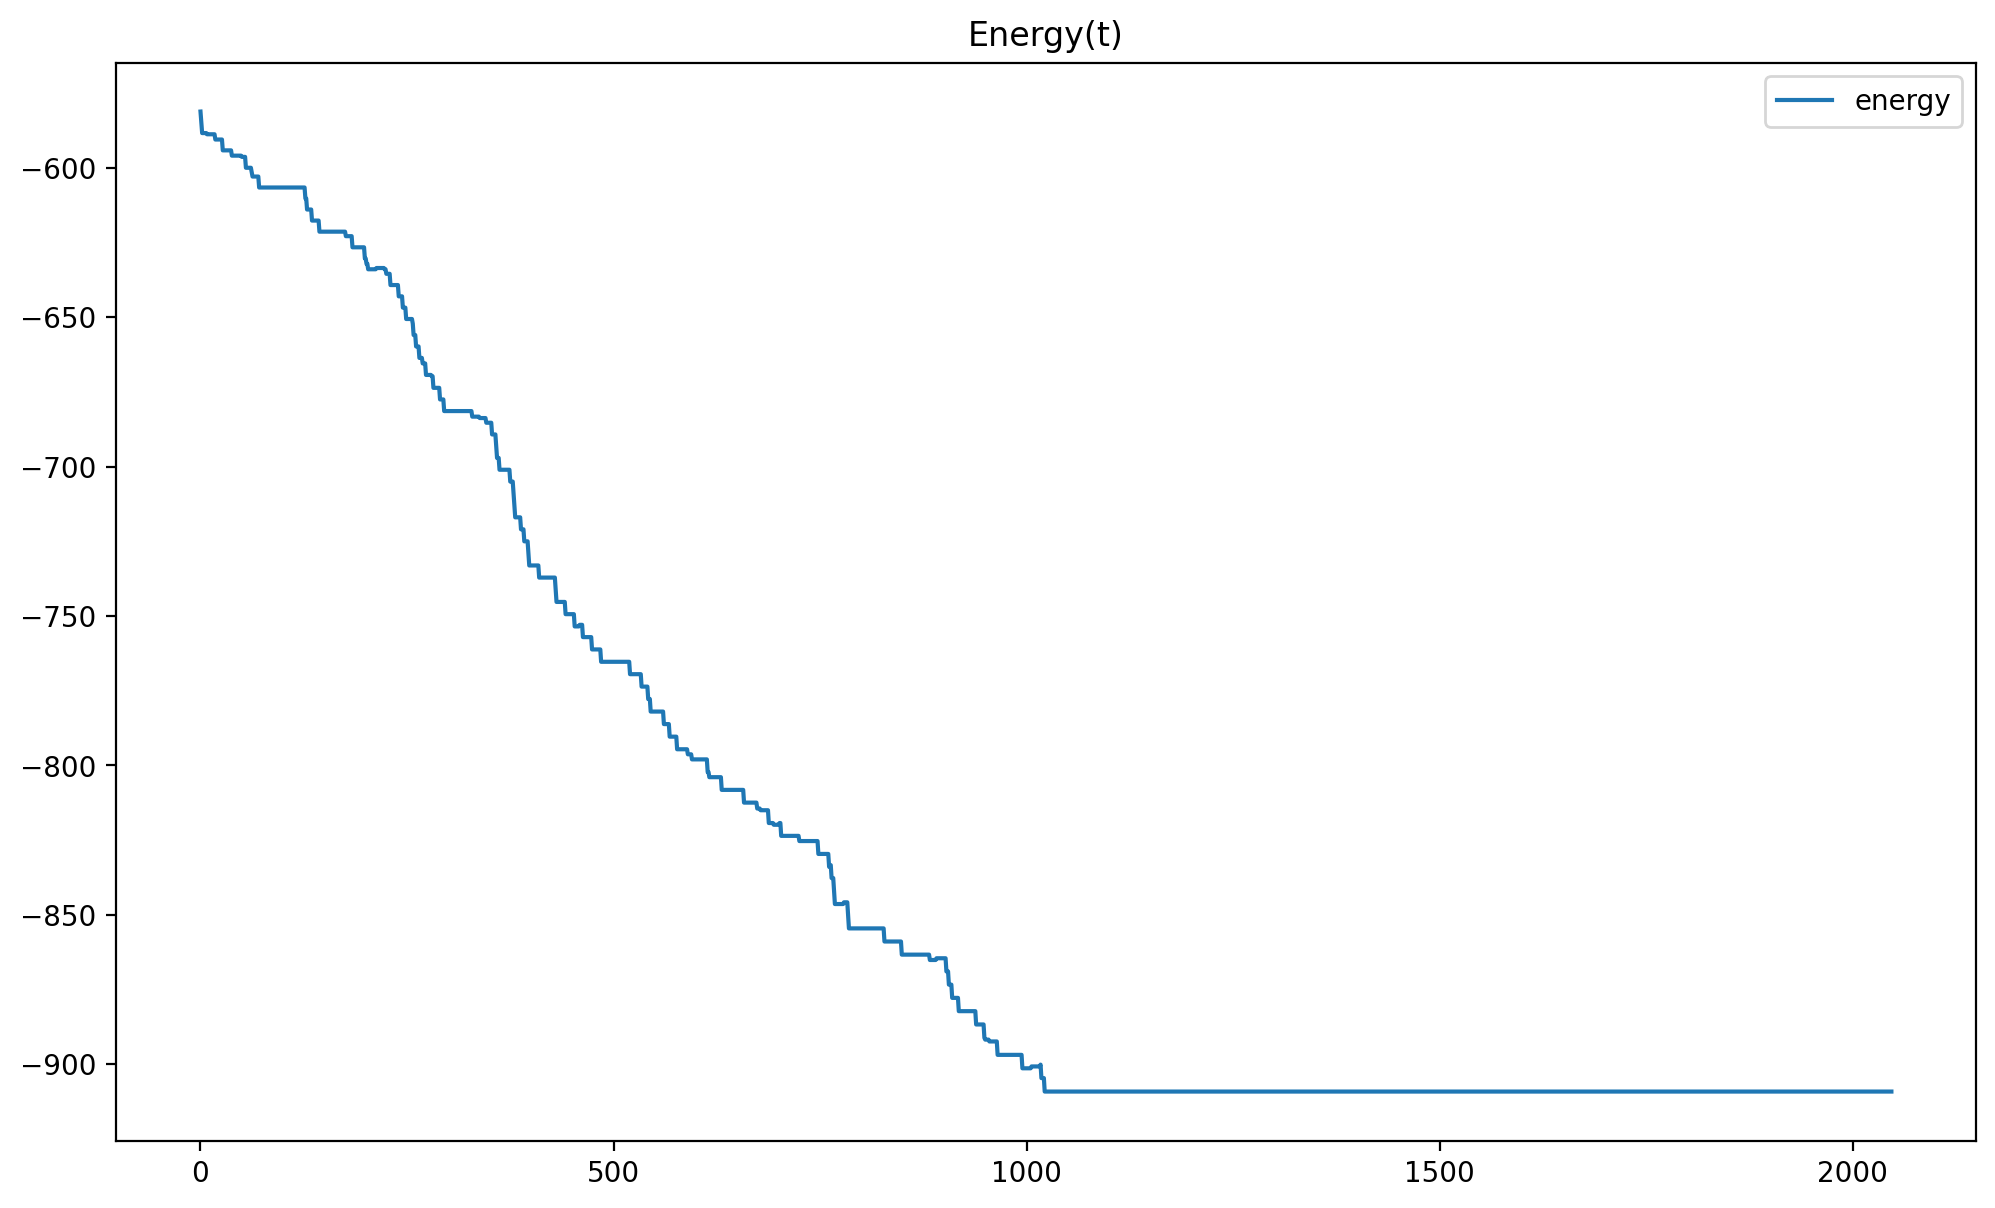

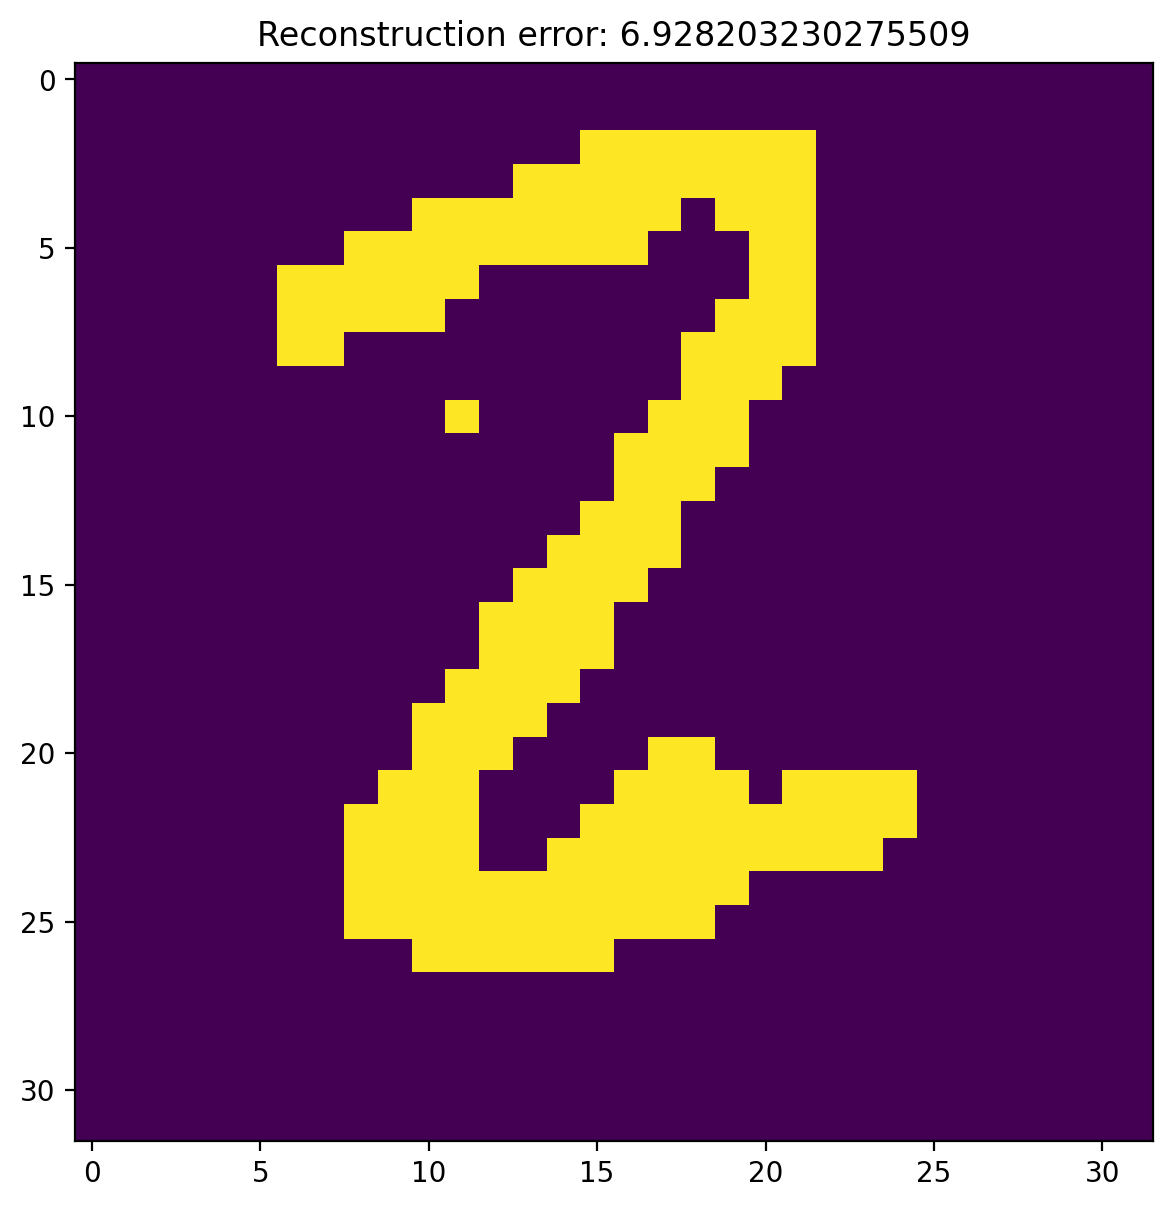

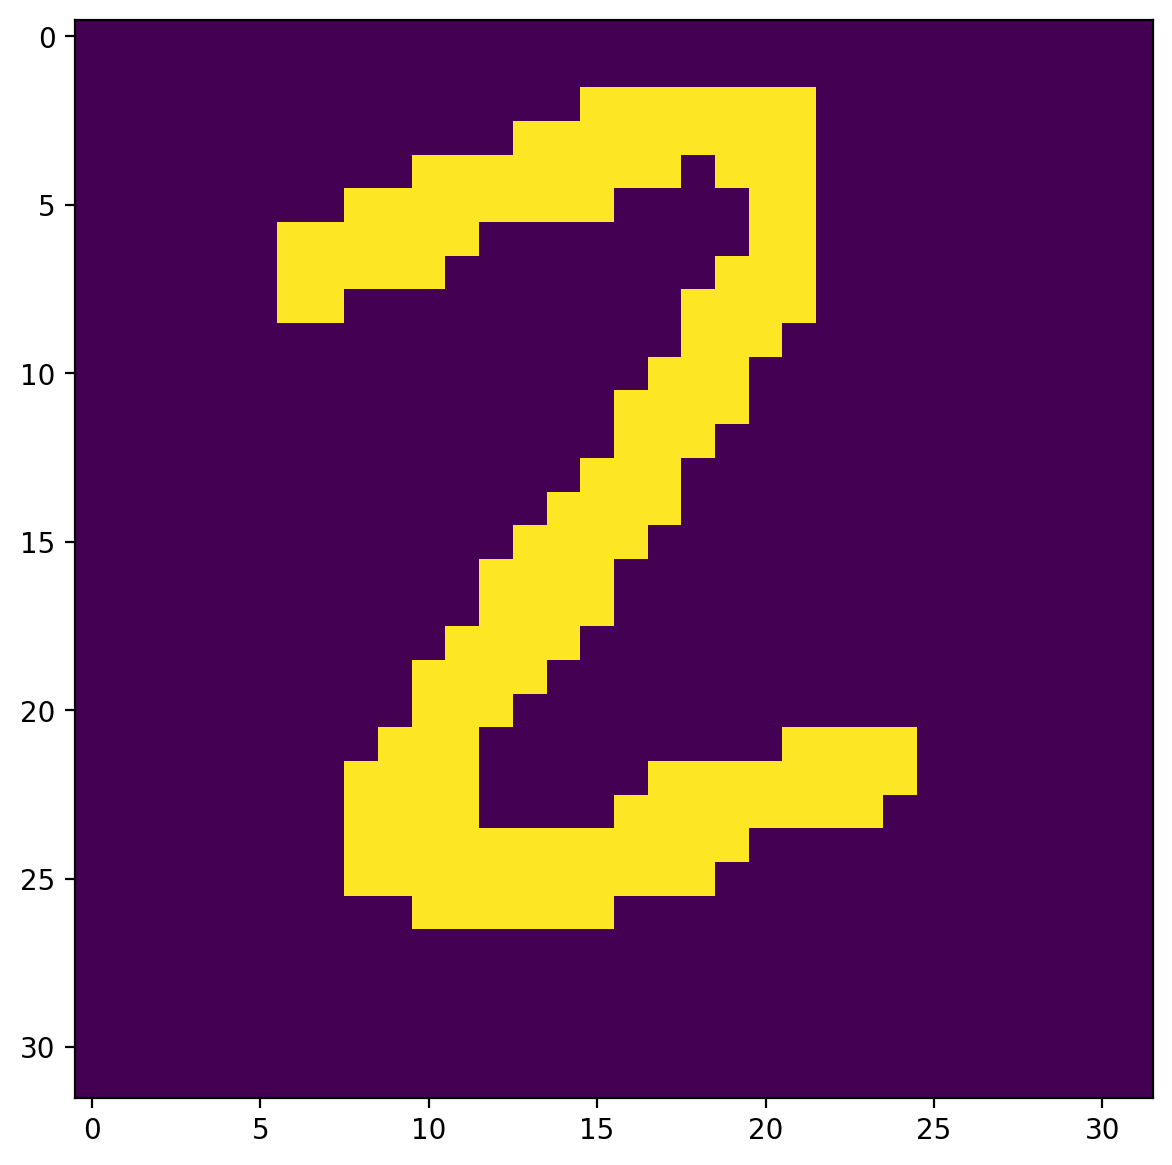

Retrieving pattern 2 with p = 0.25


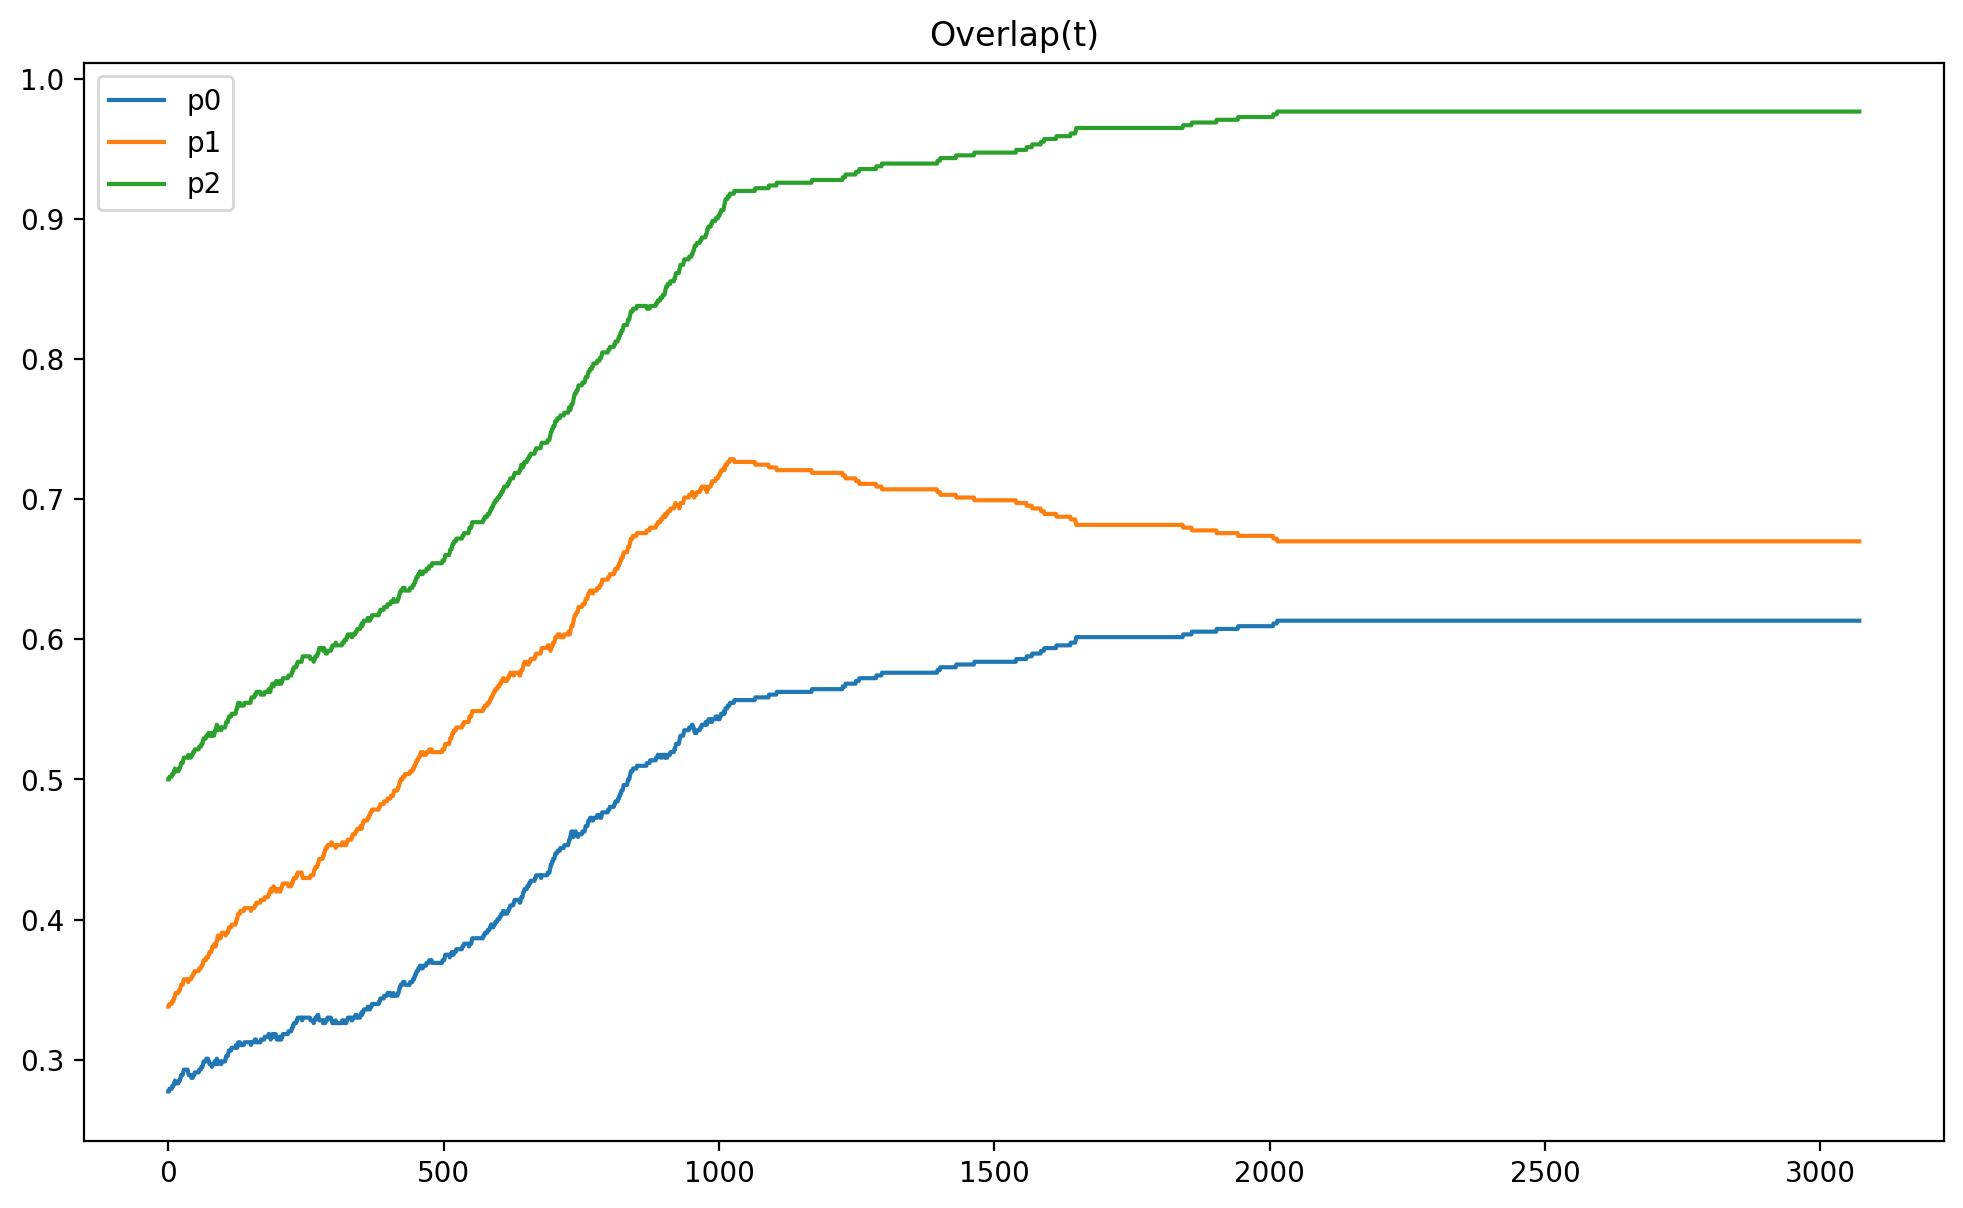

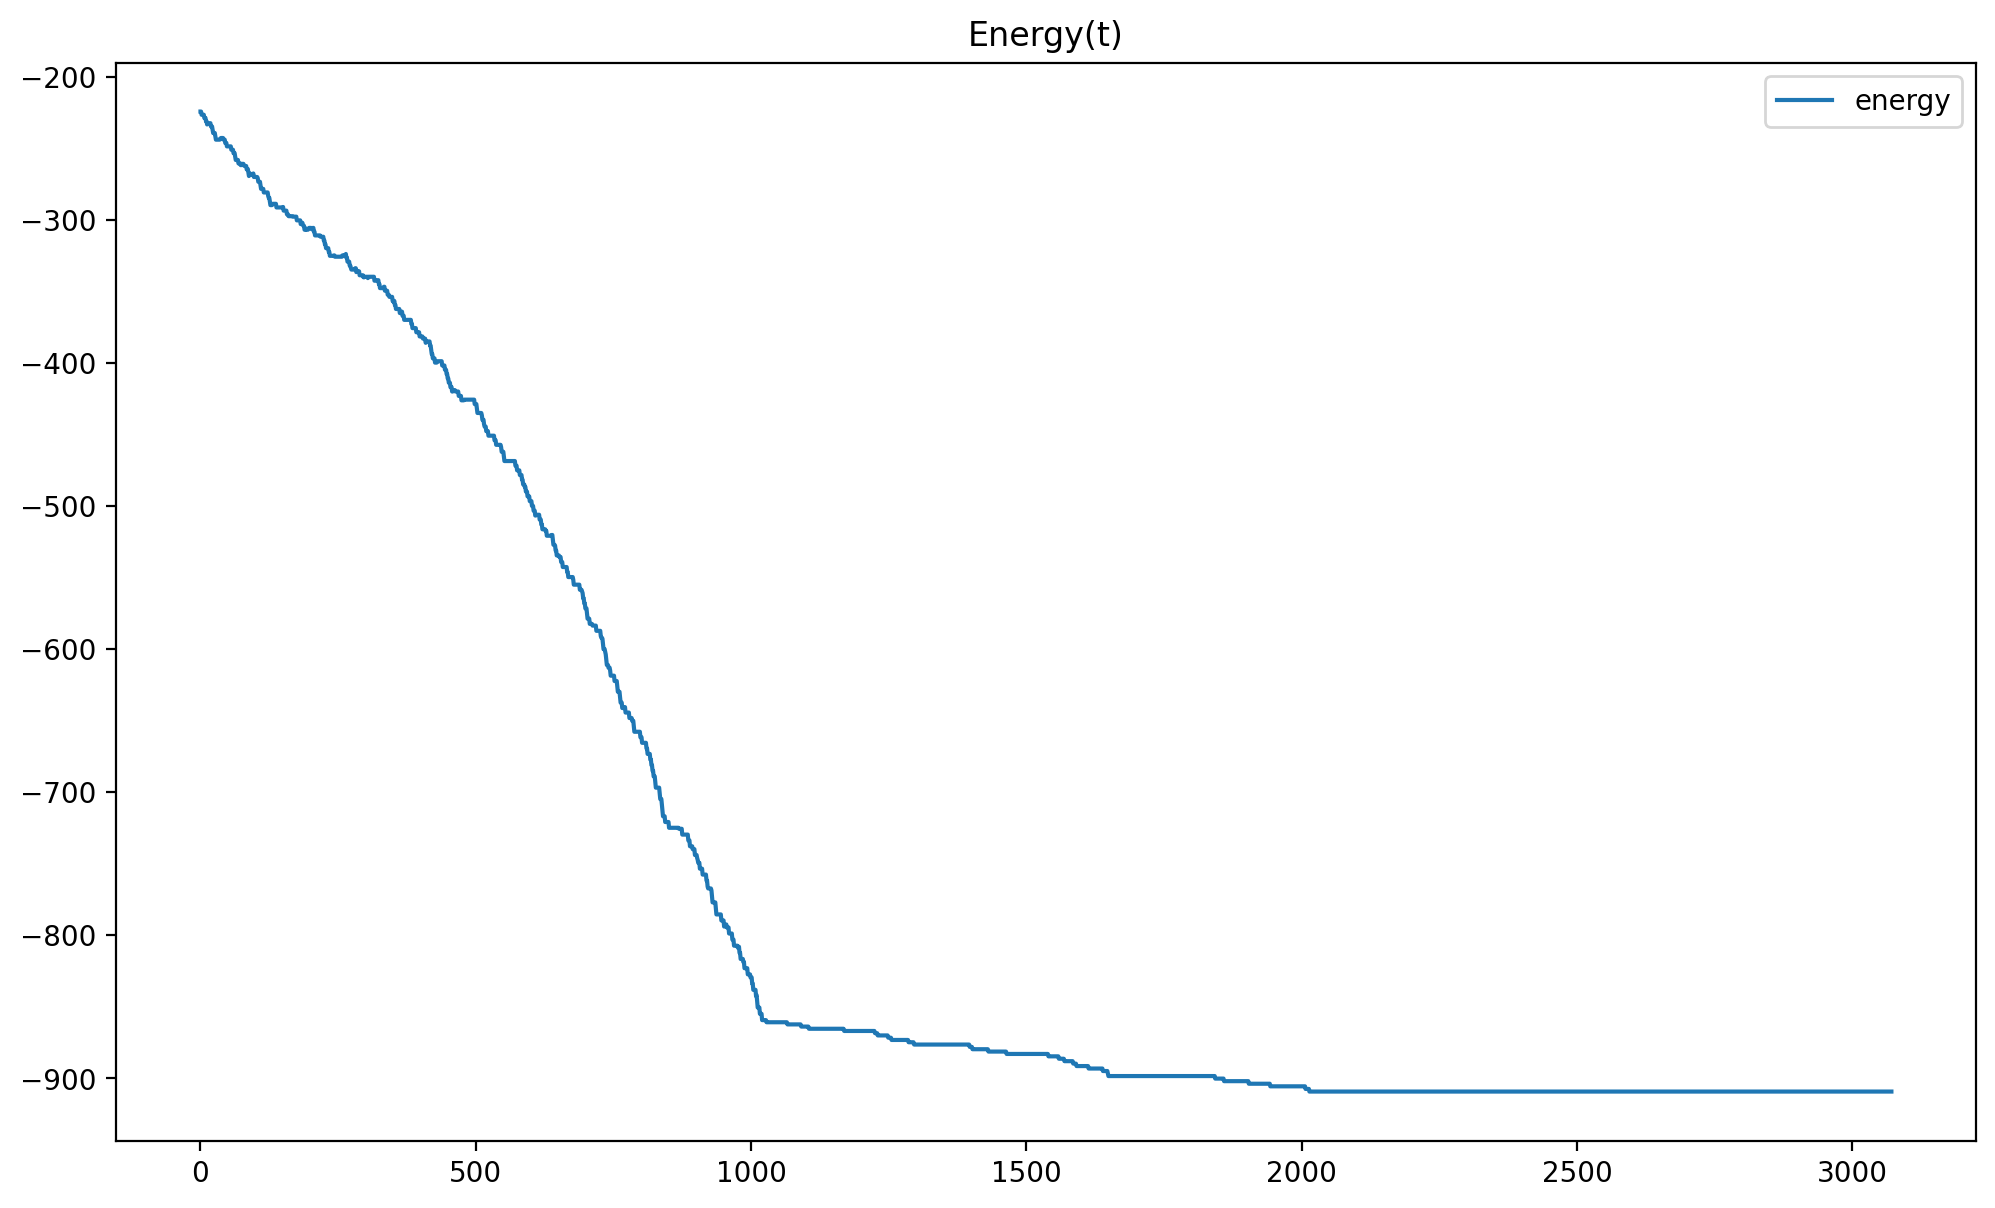

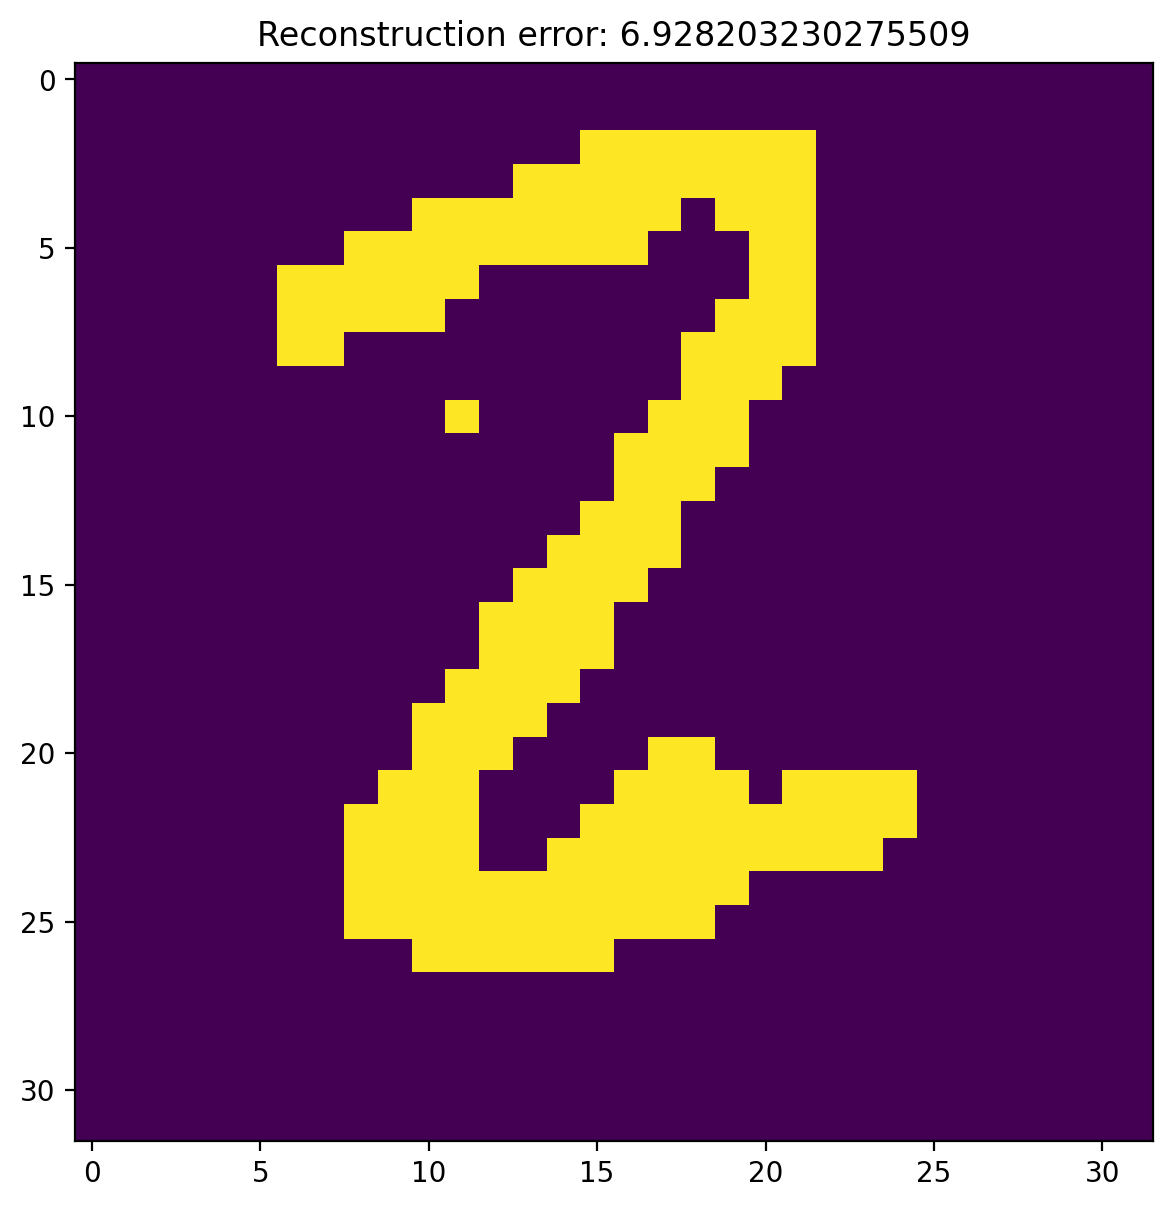

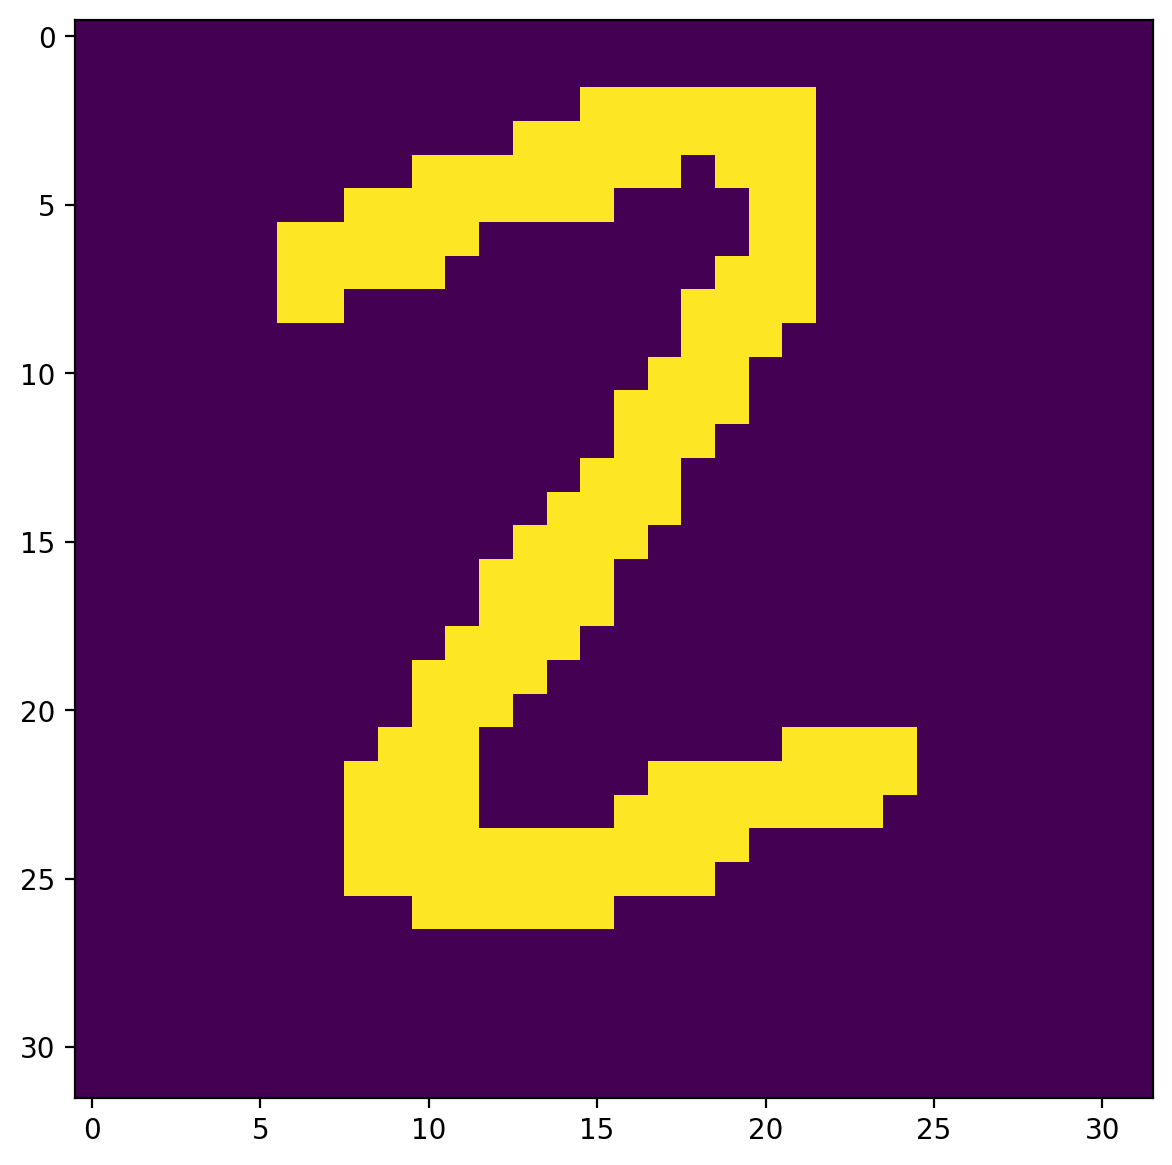

In [43]:
patterns = [p0, p1, p2]
hopfield = Hopfield(neurons = len(p0))

# learning phase
hopfield.store(patterns)

# generate perturbated versions of the patterns
perturbations = [0.05, 0.1, 0.25]
perturbed = [distort(mu, p) for mu in patterns for p in perturbations]
labels = [f'p{i}' for i in range(len(patterns))]

# retrieval phase
for i, p in enumerate(perturbed):
    p_val = perturbations[i % len(perturbations)]
    digit = i // len(patterns)
    print(f'Retrieving pattern {digit} with p = {p_val}')
    hopfield.probe(p)
    while hopfield.update_all():
        pass
    plot_overlaps(hopfield, labels, f'figures/overlap-{digit}-{p_val}.png')
    plot_energy(hopfield, f'figures/energy-{digit}-{p_val}.png')
    plot_reconstruction(hopfield, f'figures/reconstruction-{digit}-{p_val}.png')